<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/rain_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S5E3 - Rain Forecast**

<div class="container">
        <h1 class="mb-2">Problem Statement</h1>
        <p class="mb-2">
            Analyze weather data over a 5-day period to identify patterns and correlations between various meteorological factors such as pressure, temperature, humidity, and rainfall. This can help in understanding how these variables influence daily weather conditions.
        </p>
        <h1 class="mb-2">Dataset Description</h1>
        <p class="mb-2">The dataset captures weather data over five days with the following features:</p>
        <ul class="mb-2">
            <li class="mb-2"><strong>day:</strong> Sequential day number.</li>
            <li class="mb-2"><strong>pressure (hPa):</strong> Atmospheric pressure measured in hectopascals.</li>
            <li class="mb-2"><strong>maxtemp (°C):</strong> Maximum temperature recorded on the day.</li>
            <li class="mb-2"><strong>temperature (°C):</strong> Average temperature of the day.</li>
            <li class="mb-2"><strong>mintemp (°C):</strong> Minimum temperature recorded on the day.</li>
            <li class="mb-2"><strong>dewpoint (°C):</strong> Temperature at which air becomes saturated with moisture.</li>
            <li class="mb-2"><strong>humidity (%):</strong> Relative humidity percentage.</li>
            <li class="mb-2"><strong>cloud (%):</strong> Cloud cover percentage.</li>
            <li class="mb-2"><strong>rainfall:</strong> Indicates if rainfall occurred ("yes"/"no").</li>
            <li class="mb-2"><strong>sunshine (hours):</strong> Total sunshine hours.</li>
            <li class="mb-2"><strong>winddirection (°):</strong> Direction of the wind in degrees.</li>
            <li class="mb-2"><strong>windspeed (km/h):</strong> Speed of the wind.</li>
        </ul>
        <p class="mb-2">
            This dataset is ideal for basic weather pattern analysis and visualization.
        </p>
    </div>

In [ ]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
import skops.io as sio
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.count import CountEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/train.csv', index_col=0)

df_test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test.csv', index_col=0)

df_train_orig = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/Rainfall.csv')

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv")

In [ ]:
df_train.head()
df_train.shape,df_test.shape

((2190, 12), (730, 11))

In [ ]:
df_train.isna().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [ ]:
df_train_orig.isna().sum()

day                       0
pressure                  0
maxtemp                   0
temparature               0
mintemp                   0
dewpoint                  0
humidity                  0
cloud                     0
rainfall                  0
sunshine                  0
         winddirection    1
windspeed                 1
dtype: int64

In [ ]:
df_train_orig.rename({"pressure ":"pressure","humidity ":"humidity","cloud ":"cloud","         winddirection":"winddirection"},axis=1,inplace=True)
df_train_orig["rainfall"] = df_train_orig["rainfall"].map({"yes":1,"no":0})
df_train_orig.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [ ]:
# # Select the target variable and numerical features
# target_var = 'rainfall'
# numerical_features = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

# # Calculate the correlation between the numerical features and the target variable
# correlation_matrix = df_train_orig[numerical_features + [target_var]].corr()

# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# # Calculate the correlation between the numerical features and the target variable
# correlation_matrix = df_train[numerical_features + [target_var]].corr()

# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

In [ ]:
def plot_scatter(x="feat1",y="feat2", df=df_train):

  plt.figure(figsize=(5,5))
  plt.scatter(df[x],df[y])
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

In [ ]:
#plot_scatter(x="day",y="sunshine")

In [ ]:
print(df_train.shape)
df_train.groupby(["day"])[["pressure"]].agg(["mean","count"])
df_train.head()

(2190, 12)


day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
id                                                                            
0     1    1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1     2    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2     3    1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3     4    1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4     5    1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

    sunshine  winddirection  windspeed  rainfall  
id                                                
0        1.1           60.0       17.2         1  
1        0.0           50.0       21.9         1  
2        8.3           70.0       18.1         1  
3        0.0           60.0       35.6         1  
4        3.6           40.0       24.8         0

<Axes: xlabel='id'>

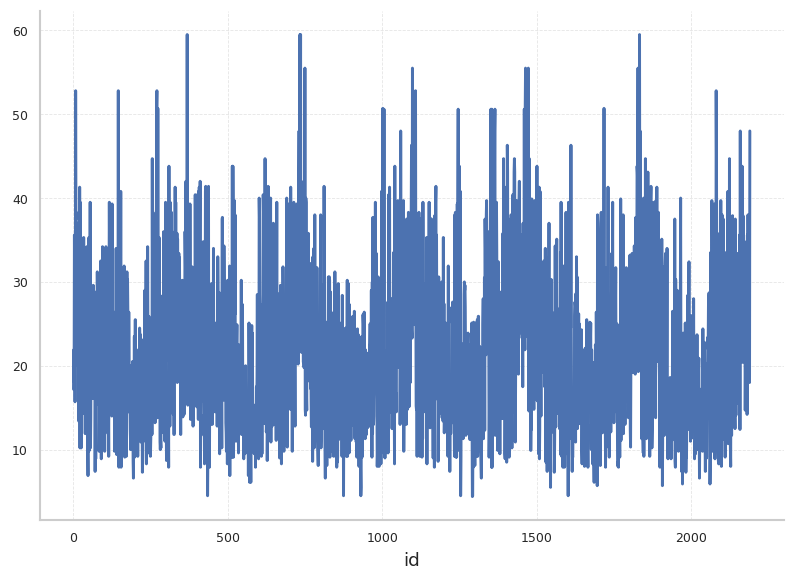

In [ ]:
df_train['winddirection_rad'] = np.radians(df_train['winddirection'])
df_train['winddirection_sin'] = np.sin(df_train['winddirection_rad'])

df_train['windspeed'].plot()

In [ ]:
# df_train["delta"]=df_train["day"].diff()
# df_train[(df_train["delta"]<0)&(df_train["delta"]>-364)]

In [ ]:
fft = tf.signal.rfft(df_train['rainfall'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_train['rainfall'])
days_per_year = 365
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.vlines(1.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(2.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(3.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(6.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(8.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(12, 0, 400, color='salmon', alpha=0.5)


plt.ylim(0, 400)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 3, 6], labels=['1/Year', '1/Sem', '1/Quart'])
_ = plt.xlabel('Frequency (log scale)')

**Descriptions of Loan Data**

Descriptions for the column names based on the data provided:

* **id**: Unique identifier for each record.
* **person_age**: Age of the individual, categorized into ranges.
* **person_income**: Income of the individual, categorized into income ranges.
* **person_home_ownership**: Homeownership status, which includes categories like 'RENT', 'MORTGAGE', etc.
* **person_emp_length**: Employment length of the individual, categorized into ranges based on years.
* **loan_intent**: The purpose of the loan, with categories such as 'EDUCATION', 'MEDICAL', etc.
* **loan_grade**: The credit grade of the loan, such as 'A', 'B', etc.
* **loan_amnt**: Loan amount, categorized into ranges.
* **loan_int_rate**: Loan interest rate, categorized into percentage ranges.
* **loan_percent_income**: Percentage of the individual’s income that the loan represents, categorized into - ranges.
* **cb_person_default_on_file**: Whether the person has a history of loan default, with values 'true' or 'false'.
* **cb_person_cred_hist_length**: Length of the individual’s credit history, categorized into ranges.
* **loan_status**: with values representing whether the loan status approval( binary values)

The dataset is a about loan applications, including personal, financial, and loan details. It's likely used for predicting whether a person will default on a loan, making it a binary classification problem. The goal is to figure out which applicants are at higher risk of not paying back their loans based on their age, income, employment, loan purpose, credit history, and other related information.

In [ ]:
class Config:

    state = 42
    n_splits = 10
    early_stop = 200

    target = 'rainfall'
    train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test.csv')
    submission = pd.read_csv( "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv",index_col=0)
    train_org = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/Rainfall.csv")

    train_org.rename({"pressure ":"pressure","humidity ":"humidity","cloud ":"cloud","         winddirection":"winddirection"},axis=1,inplace=True)
    train_org["rainfall"] = train_org["rainfall"].map({"yes":1,"no":0})

    original_data = 'Y'
    overwrite_data = 'Y'
    outliers = 'N'
    log_trf = 'N'
    scaler_trf = 'Y'
    feature_eng = 'Y'
    missing = 'Y'
    force_normalization="N"
    impose_normalization="N"
    add_mean_std_="Y"
    trg_enc = "N"
    metric_goal="AUC"
    direction_="maximize"
    norm_trf = ['pressure',
                'mintemp',
                'temparature',
                'maxtemp',
                'dewpoint',
                'humidity',
                'cloud',
                'sunshine',
                'windspeed',
                'Wdsx',
                'Wdsy',
                'temp_diff',
                'dewpoint_spread',
                'range_dist_cloud',
                'cloud_Humidity_Interaction',
                'cloud_sunshine',
                'rolling_cloud_mean',
                'rolling_humidity_mean',
                'cloud_ratio',
                'humidity_ratio']
    log_trans_cols = []
    force_norm_cols = []
    impose_norm_cols = []
    trg_enc_feat = []

In [ ]:
Config.submission

rainfall
id            
2190         0
2191         0
2192         0
2193         0
2194         0
...        ...
2915         0
2916         0
2917         0
2918         0
2919         0

[730 rows x 1 columns]

In [ ]:
class Preprocessing():

    def __init__(self):
        self.train = Config.train
        self.test = Config.test
        self.targets = Config.target

        self.prp_data()

    def prp_data(self):

        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, Config.train_org], ignore_index=True)#.drop_duplicates(ignore_index=True)

        self.train = self.train.drop(['id'], axis=1)
        self.test = self.test.drop(['id'], axis=1)

        self.cat_features = self.train.drop(self.targets, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.targets, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

In [ ]:
class EDA(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        self.data_info()
        self.heatmap()
        self.dist_plots()
        #self.cat_feature_plots()
        self.target_pie()

    def data_info(self):

        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', 'slategrey'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            },
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.RED+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))

            print(Style.BRIGHT+Fore.RED+f'\n{label} info\n'+Style.RESET_ALL)
            display(data.info())

            print(Style.BRIGHT+Fore.RED+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.targets, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))

            print(Style.BRIGHT+Fore.RED+f'\n{label} missing values\n'+Style.RESET_ALL)
            display(data.isna().sum())
        return self

    def heatmap(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Blues', annot=True, cbar=False)
        plt.show()

    def dist_plots(self):

        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Numerical\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'),
                        self.test[self.num_features].assign(Source = 'Test'),],
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (18, len(self.num_features) * 6),
                                 gridspec_kw = {'hspace': 0.3,
                                                'wspace': 0.2,
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            ax = axes[i,0]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source',
                        palette = ['royalblue', 'tomato'], ax = ax, alpha=0.7, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid('--',alpha=0.7)

            ax = axes[i,1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['royalblue', 'tomato']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()

    def cat_feature_plots(self):
        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Categorical\n")
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6),
                                 gridspec_kw = {'hspace': 0.5,
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):

            ax = axes[i,0]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='royalblue', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")

            ax = axes[i,1]
            sns.barplot(data=self.test[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='tomato', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()

    def target_pie(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        targets = self.train[self.targets]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=palette_9)
        plt.show()

## 1.0 EDA


Train head




Train info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2556 non-null   int32  
 1   pressure       2556 non-null   float32
 2   maxtemp        2556 non-null   float32
 3   temparature    2556 non-null   float32
 4   mintemp        2556 non-null   float32
 5   dewpoint       2556 non-null   float32
 6   humidity       2556 non-null   float32
 7   cloud          2556 non-null   float32
 8   sunshine       2556 non-null   float32
 9   winddirection  2555 non-null   float32
 10  windspeed      2555 non-null   float32
 11  rainfall       2556 non-null   int32  
dtypes: float32(10), int32(2)
memory usage: 119.9 KB


None


Train describe




Train missing values



day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        1
rainfall         0
dtype: int64


Test head




Test info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int32  
 1   pressure       730 non-null    float32
 2   maxtemp        730 non-null    float32
 3   temparature    730 non-null    float32
 4   mintemp        730 non-null    float32
 5   dewpoint       730 non-null    float32
 6   humidity       730 non-null    float32
 7   cloud          730 non-null    float32
 8   sunshine       730 non-null    float32
 9   winddirection  729 non-null    float32
 10  windspeed      730 non-null    float32
dtypes: float32(10), int32(1)
memory usage: 31.5 KB


None


Test describe




Test missing values



day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


Correlation Heatmap



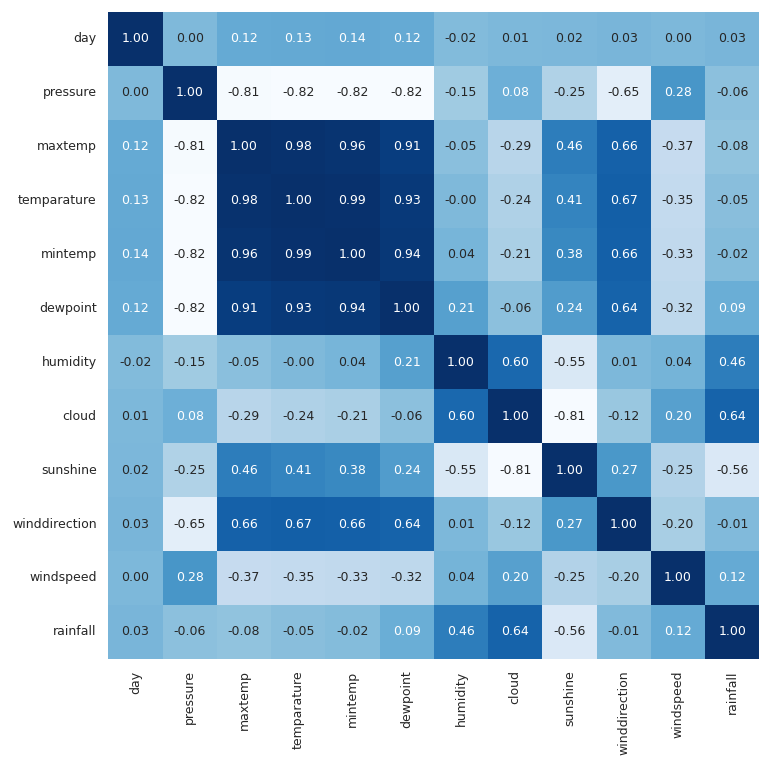


Distribution analysis - Numerical



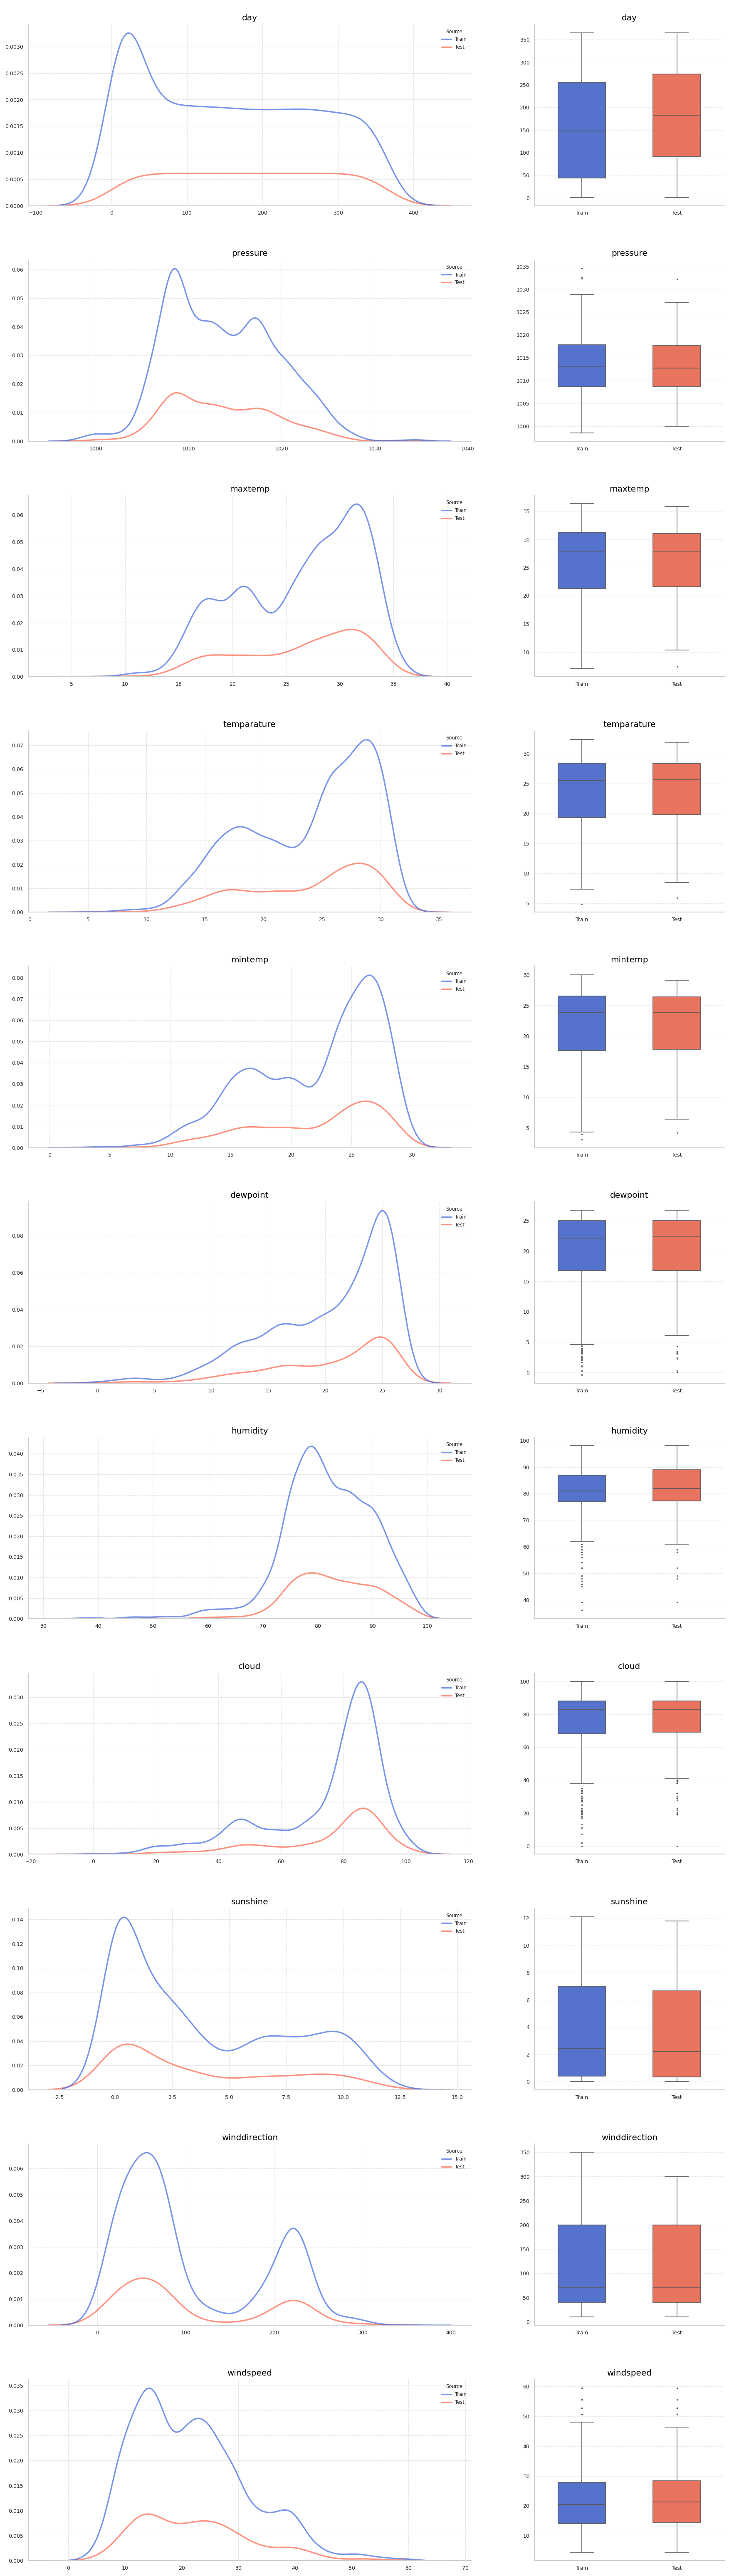


Target feature distribution



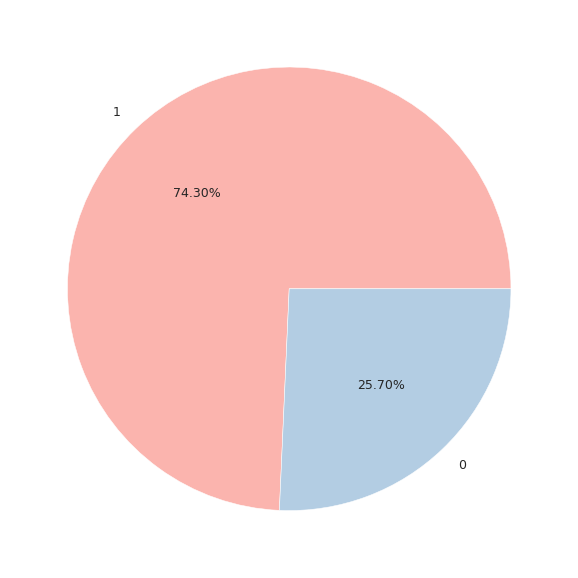

In [ ]:
eda = EDA()

## 2.0 Data Transformation and Feature Engeneering:

In [ ]:
class Transform(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        if self.missing == 'Y':
            self.missing_values()

        self.train_raw = self.train.copy()

        if self.overwrite_data == 'Y':
            self.train = self.overwrite(self.train)
            self.test = self.overwrite(self.test)

        if self.feature_eng == 'Y':
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)


        # self.train.drop(["day","Wdx","Wdy","maxtemp","mintemp","windspeed"], axis=1, inplace=True)
        # self.test.drop(["day","Wdx","Wdy","maxtemp","mintemp","windspeed"], axis=1, inplace=True)

        self.train.drop(["day","Wdx","Wdy"], axis=1, inplace=True)
        self.test.drop(["day","Wdx","Wdy"], axis=1, inplace=True)

        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()

        if self.outliers == 'Y':
            self.remove_outliers()

        if self.log_trf == 'Y':
            self.log_transformation()

        if self.force_normalization == 'Y':
            self.forced_norm_transformation()

        if self.impose_normalization == 'Y':
            self.impose_normalization_transformation()

        if self.trg_enc == 'Y':
            self.target_encoding()

        if self.scaler_trf == 'Y':
            self.scaler()

        if self.add_mean_std_ == 'Y':
            self.add_mean_std()

        if self.outliers == 'Y' or self.log_trf == 'Y' or self.scaler_trf =='Y':
            self.distribution()

        # self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        # self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()


    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype('category')
        self.test[self.cat_features] = self.test[self.cat_features].astype('category')
        data = pd.concat([self.test, self.train])
        self.train_enc, self.test_enc = self.encode(data)

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(1 + data[f].max())

        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)

        self.train = self.train.drop(['mintemp', 'maxtemp'],axis=1)
        self.train_enc = self.train_enc.drop(['mintemp', 'maxtemp'],axis=1)
        self.test = self.test.drop(['mintemp', 'maxtemp'],axis=1)
        self.test_enc = self.test_enc.drop(['mintemp', 'maxtemp'],axis=1)

 #       scaler = StandardScaler()
 #       self.train_enc[self.num_features] = scaler.fit_transform(self.train_enc[self.num_features])
 #       self.test_enc[self.num_features] = scaler.transform(self.test_enc[self.num_features])

        return self.train, self.train_enc, self.y, self.test, self.test_enc, self.cat_features


    def encode(self, data):

        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')

        train_enc = data[~data[self.target].isna()]
        test_enc = data[data[self.target].isna()].drop(self.target, axis=1)
        return train_enc, test_enc

    def overwrite(self, df):

        # Iterate through the rows, starting from the second row
        for i in range(1, len(df)):

            # Calculate the difference between the current day and the previous day
            diff = df.loc[i, 'day'] - df.loc[i-1, 'day']

            # If the difference is greater than 1, replace the current day with the previous day plus 1
            if diff > -360:
                df.loc[i, 'day'] = df.loc[i-1, 'day'] + 1

        return df

    def new_features(self, df):

        # Wind Speed and direction:
        #Replace Some entries that appears wrong in the dataset:
        wv = df['windspeed']

        # Convert to radians.
        wd_rad = df.pop('winddirection')*np.pi / 180

        # Calculate the wind x and y components.
        df['Wdx'] = np.cos(wd_rad)
        df['Wdy'] = np.sin(wd_rad)

        # Calculate the wind x and y components.
        df['Wdsx'] = wv*np.cos(wd_rad)
        df['Wdsy'] = wv*np.sin(wd_rad)

        # Temporal Features:
        # Annual Seasonalities:
        df['Year_sin'] = np.sin(df['day'] * (2 * np.pi / 365))
        df['Year_cos'] = np.cos(df['day'] * (2 * np.pi / 365))
        # Semester Seasonalities:
        df['sem_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 2)))
        df['sem_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 2)))
        # 4-time a year Seasonalities:
        df['m4_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 3)))
        df['m4_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 3)))
        # 6-time a year Seasonalities:
        df['m6_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 6)))
        df['m6_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 6)))
        # 8-time a year Seasonalities:
        df['m8_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 8)))
        df['m8_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 8)))

        # Month of the year:
        # Define the number of days in each month
        df["temp_diff"] = (df["maxtemp"] - df["mintemp"])
        df["dewpoint_spread"] = (df["temparature"] - df["dewpoint"])
        df["range_dist_cloud"] = (df["temp_diff"])*((df["cloud"]**2))

        # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
        df['cloud_Humidity_Interaction'] = np.log1p(((df['cloud'] + df['humidity']/10)+df["dewpoint_spread"])/(1+100*df["sunshine"]/12))
        #df['wind_chill'] = 13.12 + 0.6215 * df['temparature'] - 11.37 * (df['windspeed']**0.16) + 0.3965 * df['temparature'] * (df['windspeed']**0.16)

        # df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
        # df['temp_deviation'] = df['temparature'] - df['avg_temp']

        # Interaction features
        # df['humidity_temp'] = df['humidity'] * df['temparature']
        df['cloud_sunshine'] = df['cloud'] * df['sunshine']

        # Rolling statistical features
        df['rolling_cloud_mean'] = df['cloud'].rolling(window=7, min_periods=1).mean()
        #df['rolling_wind_mean'] = df['windspeed'].rolling(window=7, min_periods=1).mean()
        df['rolling_humidity_mean'] = df['humidity'].rolling(window=7, min_periods=1).mean()

        df['cloud_ratio'] = df['cloud'].div(df['rolling_cloud_mean'])
        #df['wind_ratio'] = df['windspeed'].div(df['rolling_wind_mean'])
        df['humidity_ratio'] = df['humidity'].div(df['rolling_humidity_mean'])

        return df

    def add_mean_std(self):
        feat = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'windspeed', 'Wdsx', 'Wdsy', 'temp_diff', 'dewpoint_spread',
       'range_dist_cloud', 'cloud_Humidity_Interaction', 'cloud_sunshine',
       'rolling_cloud_mean', 'rolling_humidity_mean', 'cloud_ratio',
       'humidity_ratio']

        self.train["mean"] = self.train[feat].mean(axis=1)
        self.train["std"] = self.train[feat].std(axis=1)
        self.test["mean"] = self.test[feat].mean(axis=1)
        self.test["std"] = self.test[feat].std(axis=1)

        scaler = StandardScaler()
        self.train[["mean","std"]] = scaler.fit_transform(self.train[["mean","std"]])
        self.test[["mean","std"]] = scaler.transform(self.test[["mean","std"]])

        return self


    def log_transformation(self):

        self.train[self.log_trans_cols] = np.log1p(self.train[self.log_trans_cols])
        self.test[self.log_trans_cols] = np.log1p(self.test[self.log_trans_cols])

        return self

    def forced_norm_transformation(self):

        self.train[self.force_norm_cols] = np.sqrt(self.train[self.force_norm_cols]+0.1)
        self.test[self.force_norm_cols] = np.sqrt(self.test[self.force_norm_cols]+0.1)

        return self

    def impose_normalization_transformation(self):

        scaler = QuantileTransformer(output_distribution='normal',subsample=20_000,random_state=42)
        self.train[self.impose_norm_cols] = scaler.fit_transform(self.train[self.impose_norm_cols])
        self.test[self.impose_norm_cols] = scaler.transform(self.test[self.impose_norm_cols])

        return self


    def distribution(self):

        print(Style.BRIGHT+Fore.RED+f'\nHistograms of distribution\n')
        fig, axes = plt.subplots(nrows=len(self.num_features), ncols=2, figsize=(15, len(self.num_features)*5))

        for (ax_r, ax_n), col in zip(axes, self.num_features):

            ax_r.set_title(f'{col} ($\mu=$ {self.train_raw[col].mean():.2f} and $\sigma=$ {self.train_raw[col].std():.2f} )')
            ax_r.hist(self.train_raw[col], bins=30, color='tomato',alpha=0.7)
            ax_r.axvline(self.train_raw[col].mean(), color='r', label='Mean')
            ax_r.axvline(self.train_raw[col].median(), color='y', linestyle='--', label='Median')
            ax_r.legend()

            ax_n.set_title(f'{col} Normalized ($\mu=$ {self.train[col].mean():.2f} and $\sigma=$ {self.train[col].std():.2f} )')
            ax_n.hist(self.train[col], bins=30, color='royalblue',alpha=0.7)
            ax_n.axvline(self.train[col].mean(), color='r', label='Mean')
            ax_n.axvline(self.train[col].median(), color='y', linestyle='--', label='Median')
            ax_n.legend()

    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
        self.train.reset_index(drop=True, inplace=True)

    def scaler(self):
        scaler = StandardScaler()
        #to_drop = ["Wdx",	"Wdy",	"Wdsx",	"Wdsy",	"Year_sin",	"Year_cos",	"sem_sin",	"sem_cos",	"m4_sin",	"m4_cos",	"m6_sin",	"m6_cos",	"m8_sin",	"m8_cos"]
        self.train[self.norm_trf] = scaler.fit_transform(self.train[self.norm_trf])
        self.test[self.norm_trf] = scaler.transform(self.test[self.norm_trf])
        return self

    def missing_values(self):

        self.train[self.num_features] = self.train[self.num_features].fillna(self.train[self.num_features].median())
        self.test[self.num_features] = self.test[self.num_features].fillna(self.test[self.num_features].median())
        for column in self.cat_features:
            self.train[column] = self.train[column].fillna(self.train[column].mode()[0])
            self.test[column] = self.test[column].fillna(self.test[column].mode()[0])
        return self

    def target_encoding(self):
        te = TargetEncoder()
        self.train[self.trg_enc_feat] = te.fit_transform(self.train[self.trg_enc_feat],self.train[self.target])
        self.test[self.trg_enc_feat] = te.transform(self.test[self.trg_enc_feat])

        for a in self.cat_features:
            self.cat_features.remove(a)

        return self

    @property
    def cat_features(self):
        return self._cat_features

    @cat_features.setter
    def cat_features(self, cat_features):
        self._cat_features = cat_features

    @property
    def num_features(self):
        return self._num_features

    @num_features.setter
    def num_features(self, num_features):
        self._num_features = num_features

    @property
    def cat_features_card(self):
        return self._cat_features_card

    @cat_features_card.setter
    def cat_features_card(self, cat_features_card):
        self._cat_features_card = cat_features_card

    @property
    def train(self):
        return self._train

    @train.setter
    def train(self, train):
        self._train = train

    @property
    def direction(self):
        return self._direction

    @direction.setter
    def direction(self, direction):
        self._direction= direction

In [ ]:
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()


Histograms of distribution



In [ ]:
X_enc.describe().T
# #X_enc.columns

count          mean       std       min  \
pressure                    2556.0  5.937869e-15  1.000196 -2.621764   
temparature                 2556.0 -2.613107e-16  1.000196 -3.601971   
dewpoint                    2556.0 -1.667941e-16  1.000196 -3.852658   
humidity                    2556.0 -3.891862e-16  1.000196 -5.591898   
cloud                       2556.0  2.223921e-16  1.000196 -4.019604   
sunshine                    2556.0  3.613872e-17  1.000196 -1.044309   
windspeed                   2556.0 -4.447842e-17  1.000196 -1.750976   
Wdsx                        2556.0  4.447842e-17  1.000196 -3.788324   
Wdsy                        2556.0  8.339703e-18  1.000196 -3.145310   
Year_sin                    2556.0  6.734490e-06  0.707107 -0.999991   
Year_cos                    2556.0  3.911783e-04  0.707383 -0.999963   
sem_sin                     2556.0  1.346698e-05  0.707107 -0.999991   
sem_cos                     2556.0  3.910045e-04  0.707383 -0.999963   
m4_sin                      2556.0  2.019549e-05  0.707108 -0.999991   
m4_cos                      2556.0  3.907147e-04  0.707383 -0.999963   
m6_sin                      2556.0  4.033713e-05  0.707110 -0.999991   
m6_cos                      2556.0  3.891513e-04  0.707380 -0.999963   
m8_sin                      2556.0  5.370844e-05  0.707112 -0.999991   
m8_cos                      2556.0  3.875323e-04  0.707378 -0.999963   
temp_diff                   2556.0 -6.115783e-17  1.000196 -2.792613   
dewpoint_spread             2556.0  1.389951e-17  1.000196 -2.949999   
range_dist_cloud            2556.0 -1.389951e-16  1.000196 -2.049748   
cloud_Humidity_Interaction  2556.0  1.195357e-16  1.000196 -1.332517   
cloud_sunshine              2556.0  0.000000e+00  1.000196 -1.143049   
rolling_cloud_mean          2556.0 -5.670998e-16  1.000196 -4.449239   
rolling_humidity_mean       2556.0  6.449371e-16  1.000196 -5.754945   
cloud_ratio                 2556.0 -8.200708e-17  1.000196 -4.118839   
humidity_ratio              2556.0 -1.433734e-15  1.000196 -5.269070   
mean                        2556.0 -2.223921e-17  1.000196 -5.592467   
std                         2556.0  3.335881e-17  1.000196 -2.118224   

                                 25%           50%       75%       max  
pressure                   -0.870720 -1.078823e-01  0.724297  3.636930  
temparature                -0.875442  2.984808e-01  0.847573  1.604943  
dewpoint                   -0.664954  3.173044e-01  0.854766  1.169830  
humidity                   -0.582807 -9.411523e-02  0.638922  1.982825  
cloud                      -0.378278  4.249554e-01  0.692700  1.335287  
sunshine                   -0.935557 -3.917993e-01  0.858844  2.245427  
windspeed                  -0.772944 -1.276445e-01  0.618483  3.804649  
Wdsx                       -0.845015  1.539334e-01  0.671714  3.390395  
Wdsy                       -0.781715  7.201163e-02  0.663782  2.671151  
Year_sin                   -0.705584 -2.449294e-16  0.705584  0.999991  
Year_cos                   -0.708627  4.303538e-03  0.702527  1.000000  
sem_sin                    -0.705584 -4.898587e-16  0.705584  0.999991  
sem_cos                    -0.708627  4.303538e-03  0.702527  1.000000  
m4_sin                     -0.705584 -7.347881e-16  0.705584  0.999991  
m4_cos                     -0.708627  4.303538e-03  0.702527  1.000000  
m6_sin                     -0.705584 -1.469576e-15  0.705584  0.999991  
m6_cos                     -0.708627  4.303538e-03  0.702527  1.000000  
m8_sin                     -0.705584 -1.959435e-15  0.705584  0.999991  
m8_cos                     -0.708627  4.303538e-03  0.702527  1.000000  
temp_diff                  -0.719294 -6.590187e-03  0.641322  4.269630  
dewpoint_spread            -0.686972 -6.978410e-02  0.547405  6.153538  
range_dist_cloud           -0.758129 -4.379622e-02  0.670537  5.021475  
cloud_Humidity_Interaction -0.852408 -2.758679e-01  0.758429  1.871434  
cloud_sunshine             -0.969981 -1.9314

In [ ]:
# plt.plot(np.array(X_enc['m8_sin'])[:3000])
# plt.plot(np.array(X_enc['m8_cos'])[:3000])
# plt.xlabel('Time [h]')
# plt.title('Time of day signal')

(-3.7883235395426604,
 3.3903947041311553,
 -3.145309908994898,
 2.671151397899364)

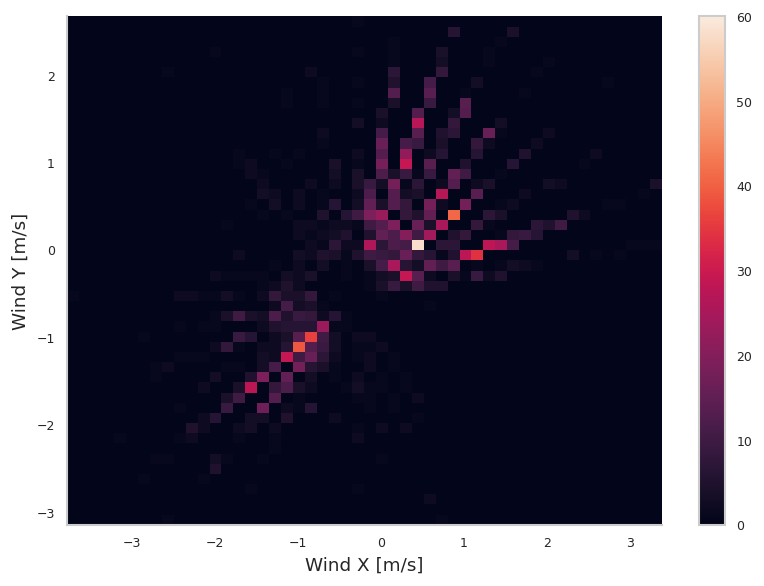

In [ ]:
plt.hist2d(X_enc['Wdsx'], X_enc['Wdsy'], bins=(50, 50), vmax=60)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [ ]:
X.shape, X_enc.shape, test.shape, test_enc.shape

((2556, 30), (2556, 30), (730, 30), (730, 30))

In [ ]:
X_enc_ext = X_enc.copy()
X_enc_ext["rainfall"] = y
X_enc_ext.columns

Index(['pressure', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine',
       'windspeed', 'Wdsx', 'Wdsy', 'Year_sin', 'Year_cos', 'sem_sin',
       'sem_cos', 'm4_sin', 'm4_cos', 'm6_sin', 'm6_cos', 'm8_sin', 'm8_cos',
       'temp_diff', 'dewpoint_spread', 'range_dist_cloud',
       'cloud_Humidity_Interaction', 'cloud_sunshine', 'rolling_cloud_mean',
       'rolling_humidity_mean', 'cloud_ratio', 'humidity_ratio', 'mean', 'std',
       'rainfall'],
      dtype='object')

In [ ]:
#X_enc_ext[["windspeed","humidity"]].describe()

In [ ]:
# columns_delta = [ 'rainfall',"temparature"]

# for col in columns_delta:
#   for delta in range(1, 8):
#     verify_lag = X_enc_ext[col].shift(delta).fillna(1)
#     df_corr = pd.concat([X_enc_ext[["rainfall"]],verify_lag],axis=1)
#     corr_verify = df_corr.corr().iloc[0,1]

#     print(f"{col} with lag {delta} corr: {corr_verify}")

In [ ]:
# X_enc_ext["temp_diff"] = (X_enc_ext["maxtemp"] - X_enc_ext["mintemp"])#/X_enc_ext["temparature"]
# X_enc_ext["dewpoint_spread"] = (X_enc_ext["temparature"] - X_enc_ext["dewpoint"])#/X_enc_ext["temparature"]
# X_enc_ext["range_dist_cloud"] = (X_enc_ext["temp_diff"])*((X_enc_ext["cloud"]**2))



# # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
# X_enc_ext['cloud_Humidity_Interaction'] = np.log1p(((X_enc_ext['cloud'] + X_enc_ext['humidity']/10)+X_enc_ext["dewpoint_spread"])/(1+100*X_enc_ext["sunshine"]/12))

# # Interaction Feature: Wind & Cloud Cover - Wind effect on cloud cover
# X_enc_ext['Wind_Cloud_Interaction'] = X_enc_ext['windspeed'] * 0.25*X_enc_ext['cloud']

In [ ]:
#Calculate the correlation between the numerical features and the target variable
correlation_matrix = X_enc_ext.corr()
fig,ax=plt.subplots(2,1,figsize=(15,10))

# Plot the heatmap
sns.heatmap(correlation_matrix.iloc[-12:,:], annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Correlation Matrix')

# Create a scatter plot of `humidity` vs `sunshine`
x1='mean'
x2='std'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x1, y=x2, hue='rainfall', data=X_enc_ext,ax=ax[1])
ax[1].set_title(f'Scatter Plot of {x1} vs {x2}')
ax[1].set_xlabel(x1)
ax[1].set_ylabel(x2)
plt.tight_layout()
plt.show()

<Figure size 1200x720 with 0 Axes>

In [ ]:
# X_enc_ext.temparature.plot()
# plt.show()
# X_enc_ext.temp_diff.plot()
# plt.show()
# X_enc_ext.isna().sum()
# #imputer = MixedDataImputer(X_enc, test_enc)

In [ ]:
#train_df_imputed, test_df_imputed = imputer.transform()
X_enc_ext.columns

Index(['pressure', 'temparature', 'dewpoint', 'humidity', 'cloud', 'sunshine',
       'windspeed', 'Wdsx', 'Wdsy', 'Year_sin', 'Year_cos', 'sem_sin',
       'sem_cos', 'm4_sin', 'm4_cos', 'm6_sin', 'm6_cos', 'm8_sin', 'm8_cos',
       'temp_diff', 'dewpoint_spread', 'range_dist_cloud',
       'cloud_Humidity_Interaction', 'cloud_sunshine', 'rolling_cloud_mean',
       'rolling_humidity_mean', 'cloud_ratio', 'humidity_ratio', 'mean', 'std',
       'rainfall'],
      dtype='object')

In [ ]:
#X_enc_ext.isna().sum()

## 3.0 Advanced Feature Engeneering

In [ ]:
X_enc.sample(3)

pressure  temparature  dewpoint  humidity     cloud  sunshine  \
1608 -0.645329     0.980113  0.984498 -0.338461 -1.020865  0.886032   
1087  0.550926    -0.742902 -0.664954  0.394577  0.424955 -0.881182   
1894  0.498917    -1.443469 -1.239482 -0.338461  0.746249 -1.044309   

      windspeed      Wdsx      Wdsy  Year_sin  Year_cos   sem_sin   sem_cos  \
1608   1.788088 -0.754642  1.923972  0.545240 -0.838280 -0.914128  0.405426   
1087   0.557986  0.314869  1.085220 -0.120208  0.992749 -0.238673  0.971100   
1894   0.709228  1.485396  0.084550  0.933837  0.357698  0.668064 -0.744104   

        m4_sin    m4_cos    m6_sin    m6_cos    m8_sin    m8_cos  temp_diff  \
1608  0.987349  0.158559  0.313107 -0.949718  0.995105 -0.098820   0.382157   
1087 -0.353676  0.935368 -0.661635  0.749826 -0.821477  0.570242  -1.626372   
1894 -0.455907 -0.890028  0.811539  0.584298 -0.213521 -0.976938  -1.561580   

      dewpoint_spread  range_dist_cloud  cloud_Humidity_Interaction  \
1608        -0.069784         -0.729685                   -0.921343   
1087        -0.172648         -1.009896                    0.521094   
1894        -0.481243         -0.796352                    1.768472   

      cloud_sunshine  rolling_cloud_mean  rolling_humidity_mean  cloud_ratio  \
1608        0.811828           -0.905273              -0.697503    -0.588893   
1087       -0.898197            0.723388               0.109205    -0.012575   
1894       -1.143049           -2.064880              -1.690375     2.851740   

      humidity_ratio      mean       std  
1608        0.058517  0.803774  0.102710  
1087        0.366413 -0.532347 -0.696624  
1894        0.753150 -1.254518  1.313616

In [ ]:
X_enc_y = pd.concat([X_enc, y], axis=1)
X_enc_y.sample(3)

pressure  temparature  dewpoint  humidity     cloud  sunshine  \
1100  1.209734    -2.030430 -2.518270 -2.781920 -2.680881 -0.391799   
2391 -0.662672     0.999048  0.965965  0.028058 -0.271180  0.695717   
2035 -0.836043     1.207324  0.891833 -0.460634 -0.164083  0.913220   

      windspeed      Wdsx      Wdsy  Year_sin  Year_cos   sem_sin   sem_cos  \
1100   1.183120  1.777040  0.186336  0.103102  0.994671  0.205104  0.978740   
2391   0.084094 -1.444933 -1.459007 -0.329408 -0.944188  0.622047  0.782980   
2035  -0.581371 -1.111070 -1.190380 -0.471160 -0.882048  0.831171  0.556017   

        m4_sin    m4_cos    m6_sin    m6_cos    m8_sin    m8_cos  temp_diff  \
1100  0.304921  0.952378  0.580800  0.814046  0.735417  0.677615   1.418817   
2391 -0.845249 -0.534373  0.903356 -0.428892  0.440519 -0.897743   1.354024   
2035 -0.995105 -0.098820  0.196673 -0.980469 -0.705584 -0.708627   0.511739   

      dewpoint_spread  range_dist_cloud  cloud_Humidity_Interaction  \
1100         1.473188         -1.656547                   -0.732928   
2391         0.033081          0.596708                   -0.804423   
2035         0.804566          0.181613                   -0.836796   

      cloud_sunshine  rolling_cloud_mean  rolling_humidity_mean  cloud_ratio  \
1100       -0.848047            0.475832              -0.356204    -2.840198   
2391        1.059629           -0.084428              -0.418258    -0.242020   
2035        1.405764            0.710359               0.760777    -0.550637   

      humidity_ratio      mean       std  rainfall  
1100       -2.952819 -3.369037  2.288587         0  
2391        0.297608  0.509327 -0.451234         1  
2035       -0.957846  0.644593 -0.188387         1

In [ ]:
X_enc_y.info()
t.cat_features

<class 'pandas.core.frame.DataFrame'>
Index: 2556 entries, 0 to 2555
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pressure                    2556 non-null   float64
 1   temparature                 2556 non-null   float64
 2   dewpoint                    2556 non-null   float64
 3   humidity                    2556 non-null   float64
 4   cloud                       2556 non-null   float64
 5   sunshine                    2556 non-null   float64
 6   windspeed                   2556 non-null   float64
 7   Wdsx                        2556 non-null   float64
 8   Wdsy                        2556 non-null   float64
 9   Year_sin                    2556 non-null   float64
 10  Year_cos                    2556 non-null   float64
 11  sem_sin                     2556 non-null   float64
 12  sem_cos                     2556 non-null   float64
 13  m4_sin                      2556 non-n

[]

In [ ]:
class plot_class():

    def __init__(self,df, target_variable, features_cat,features_num):
      self.df = df
      self.target_variable = target_variable
      self.features_cat = features_cat
      self.features_num = features_num

    @classmethod
    def plot_categorical_features(cls, df, target_variable, features_cat, features_num):
        """
        Plots the frequency of the target variable for each value of multiple categorical features.

        Args:
          df: Pandas DataFrame containing the data.
          target_variable: Name of the target variable column in the DataFrame.
          features: List of names of the categorical feature columns to plot.
        """

        num_features = len(features_cat)
        if num_features>0:
          num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

          fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
          axes = axes.flatten()  # Flatten the axes array for easier iteration

          for i, feature in enumerate(features_cat):
              cross_tab = pd.crosstab(df[feature], df[target_variable])
              cross_tab.plot(kind='bar', stacked=False, position=0.3, width=0.4, ax=axes[i],colormap=palette_1, alpha=0.6)
              axes[i].set_xlabel(feature)
              axes[i].set_ylabel('Frequency')
              axes[i].set_title(f'Frequency of {target_variable} by {feature}')

          # Hide any unused subplots
          for i in range(num_features, len(axes)):
              axes[i].axis('off')

          plt.tight_layout()
          plt.show()

        else:
          print("No categorical features to plot.")

        return cls(df, target_variable, features_cat, features_num)

    @classmethod
    def plot_numerical_features(cls, df, target_variable, features_cat, features_num):
        """
        Generates violin plots for numerical features, showing the distribution for each target class.

        Args:
          df: Pandas DataFrame containing the data.
          target_variable: Name of the target variable column in the DataFrame.
          features: List of names of the numerical feature columns to plot.
        """

        num_features = len(features_num)
        num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
        axes = axes.flatten()  # Flatten the axes array for easier iteration

        for i, feature in enumerate(features_num):
            sns.violinplot(x=target_variable, y=feature, data=df, ax=axes[i],
                           hue=target_variable,  # Use 'hue' to color by target class
                           palette=palette_9)
            axes[i].set_xlabel(target_variable)
            axes[i].set_ylabel(feature)
            axes[i].set_title(f'Distribution of {feature} by {target_variable}')

        # Hide any unused subplots
        for i in range(num_features, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        return cls(df, target_variable, features_cat, features_num)

    def scatter_comp(self, feat_01, feat_02, hue_def):
        """
        Generates a scatter plot between two features, colored by a third
        categorical feature using Seaborn.

        Args:
          df: Pandas DataFrame containing the data.
          x_feature: Name of the feature to plot on the x-axis.
          y_feature: Name of the feature to plot on the y-axis.
          color_feature: Name of the categorical feature to use for coloring.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.scatterplot(
            x=feat_01,
            y=feat_02,
            hue=hue_def,  # Use 'hue' for color encoding
            data=self.df,
            ax=ax
        )

        plt.xlabel(feat_01)
        plt.ylabel(feat_02)
        plt.title(f'ScatterPlot of {feat_01} vs. {feat_02} colored by {hue_def}')
        plt.show()

    def heatmap_corr(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.df.select_dtypes(exclude='int').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = "Reds", annot=True, cbar=False)
        plt.show()

In [ ]:
plot_instance = plot_class.plot_categorical_features(df=X_enc_y, target_variable="rainfall", features_cat=t.cat_features, features_num=t.num_features);

No categorical features to plot.


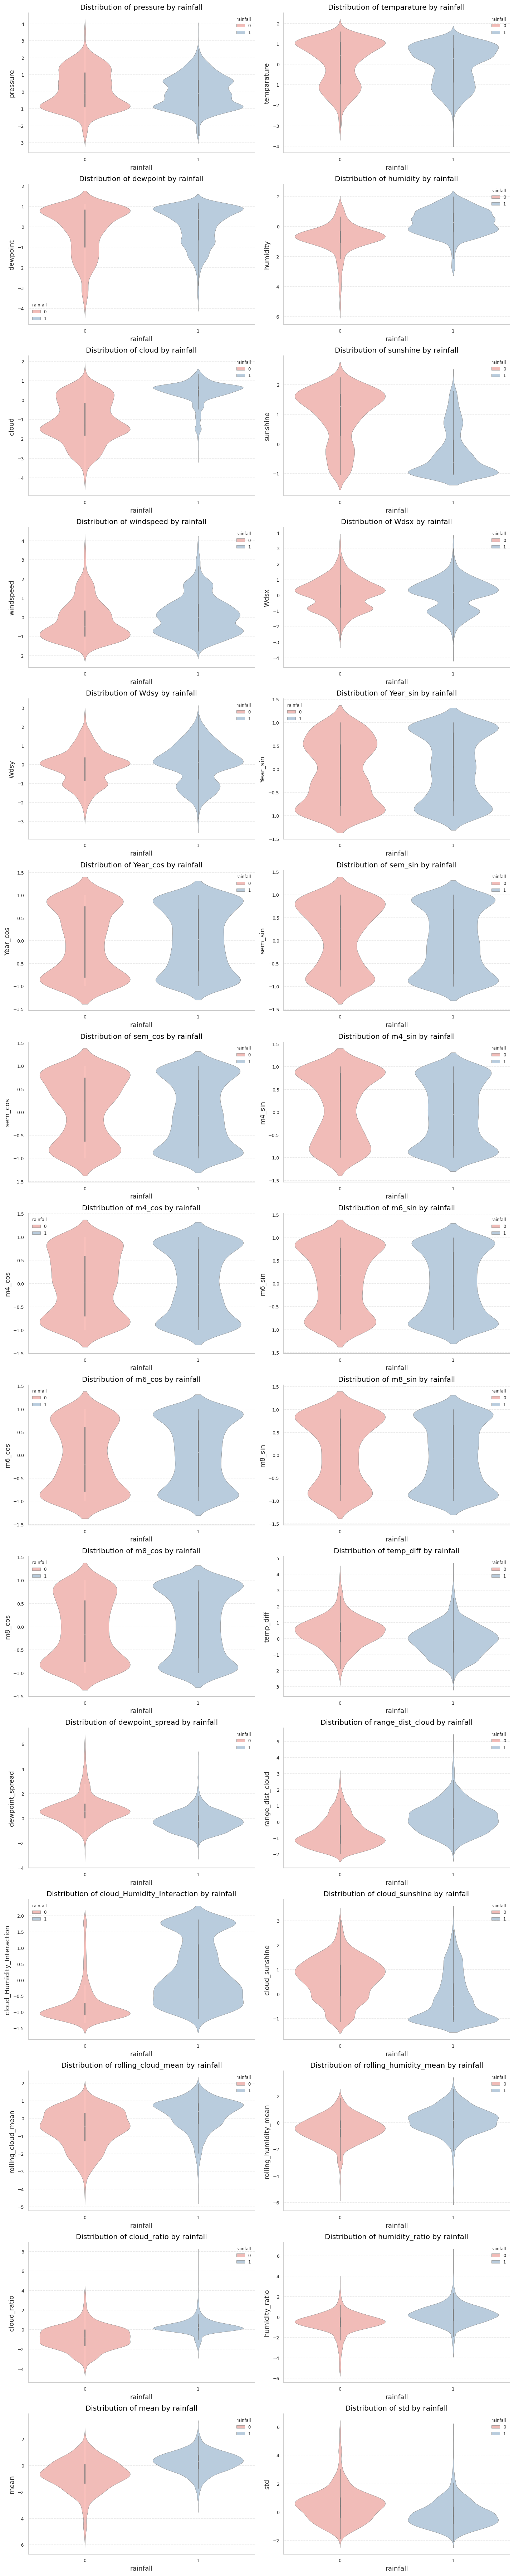

In [ ]:
plot_instance.plot_numerical_features(df=X_enc_y, target_variable="rainfall", features_cat=t.cat_features, features_num=X_enc.columns);

In [ ]:
plot_instance.scatter_comp(feat_01="mean", feat_02="sunshine", hue_def="rainfall")


Correlation Heatmap



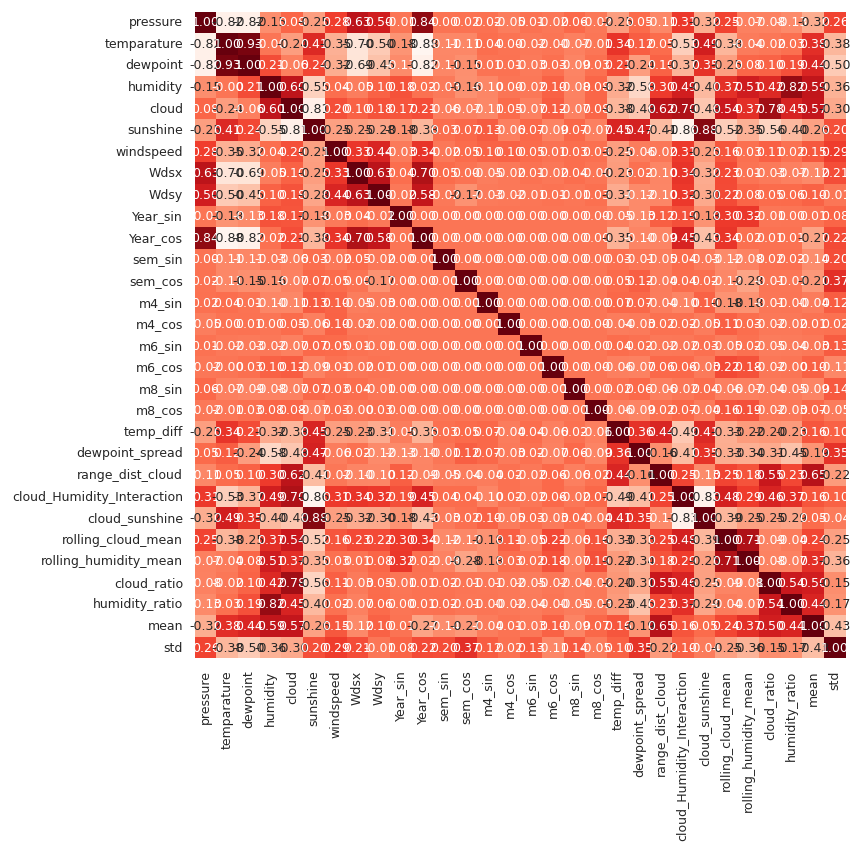

In [ ]:
plot_instance.heatmap_corr()

In [ ]:
print(X_enc_y.shape,test_enc.shape)
X_enc_y_old = X_enc_y.iloc[2191:,:]
X_enc_y_new = X_enc_y.iloc[:2190,:]
print(X_enc_y_new.shape,X_enc_y_old.shape,test_enc.shape)

(2556, 31) (730, 30)
(2190, 31) (365, 31) (730, 30)


In [ ]:
# verify = X_enc_y_old.copy()

In [ ]:
X_enc_y_old.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old_all_ext.csv", index=False)
X_enc_y_new.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new_all_ext.csv", index=False)
test_enc.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc_all_ext.csv", index=False)

In [ ]:
# X_enc_y_old = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old.csv")
# X_enc_y_new = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new.csv")
# test_enc = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc.csv")

X_enc_y_old = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old_all_ext.csv")
X_enc_y_new = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new_all_ext.csv")
test_enc = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc_all_ext.csv")

In [ ]:
print(X_enc_y_old.shape)
X_enc_y_old.head()

(365, 31)


pressure  temparature  dewpoint  humidity     cloud  sunshine  windspeed  \
0  1.452458    -0.951179 -0.887351 -0.094115  0.424955 -0.881182  -0.651950   
1  1.053707    -0.875442 -0.368423  1.616306  0.853347 -1.044309  -0.762861   
2  0.915012    -0.629296 -0.294290  1.005441  0.692700 -0.772430  -0.490625   
3  0.394898    -0.610362 -0.090425  1.616306  0.317858 -1.044309  -0.813275   
4  0.897668    -0.572494 -0.442555  0.272404 -1.288609  1.049159  -0.732613   

       Wdsx      Wdsy  Year_sin  Year_cos   sem_sin   sem_cos    m4_sin  \
0  0.347721  0.202977  0.034422  0.999407  0.068802  0.997630  0.103102   
1  0.416607  0.038796  0.051620  0.998667  0.103102  0.994671  0.154309   
2  0.415635  0.280586  0.068802  0.997630  0.137279  0.990532  0.205104   
3  0.391314  0.018445  0.085965  0.996298  0.171293  0.985220  0.255353   
4  0.598051 -0.225140  0.103102  0.994671  0.205104  0.978740  0.304921   

     m4_cos    m6_sin    m6_cos    m8_sin    m8_cos  temp_diff  \
0  0.994671  0.205104  0.978740  0.271958  0.962309   0.187783   
1  0.988023  0.304921  0.952378  0.401488  0.915864  -1.237624   
2  0.978740  0.401488  0.915864  0.523416  0.852078  -0.654504   
3  0.966848  0.493776  0.869589  0.635432  0.772157  -2.015119   
4  0.952378  0.580800  0.814046  0.735417  0.677615   0.576529   

   dewpoint_spread  range_dist_cloud  cloud_Humidity_Interaction  \
0        -0.121217          0.607652                    0.519015   
1        -1.355594         -0.394800                    1.781525   
2        -0.892702          0.086081                    0.262796   
3        -1.407026         -1.386770                    1.709152   
4        -0.326946         -0.879598                   -0.976980   

   cloud_sunshine  rolling_cloud_mean  rolling_humidity_mean  cloud_ratio  \
0       -0.898197            0.554007               0.884886     0.081406   
1       -1.143049            0.593095               0.822832     0.462054   
2       -0.710380            0.593095               0.791805     0.311036   
3       -1.143049            0.619154               1.288241    -0.055573   
4        0.787736            0.071924               1.040023    -1.358131   

   humidity_ratio      mean       std  rainfall  
0       -0.635153 -0.349467 -0.764193         1  
1        1.229741 -0.038102  0.226233         1  
2        0.595958  0.044371 -0.994526         1  
3        0.926429 -0.545031  0.320329         1  
4       -0.334662 -0.593965 -0.622513         1

## **4.0 Baseline Stacked Model**

In [ ]:
X_enc.shape, y.shape, test_enc.shape, cat_features

((2556, 30), (2556,), (730, 30), [])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

sample_pos_weight = class_weights[1]/class_weights[0]
sample_pos_weight

0.3459715639810426

In [ ]:
Config.submission

rainfall
id            
2190         0
2191         0
2192         0
2193         0
2194         0
...        ...
2915         0
2916         0
2917         0
2918         0
2919         0

[730 rows x 1 columns]

In [ ]:
# Meta-learner

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 1500  # Number of estimators for the ensemble models

X = X_enc.copy()
y = y.copy()

X_test = test_enc.copy()

df_subm_stack = Config.submission.copy()

cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_SEED)
auc_ = []

# Initialize the Stack
df_subm_stack['rainfall'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    lgbm_params = {
              'num_leaves': 97,
              'learning_rate': 0.02,
              'min_child_samples': 35,
              'subsample': 0.51,
              'subsample_freq': 1,
              'colsample_bytree': 0.60,
              "reg_alpha" :         0.08,
              "reg_lambda" :        0.036,
              "boosting_type":      'gbdt',
              'n_estimators': 500,
              "objective":"binary",
              "eval_metric":"auc",
              'device': 'cpu',
              'verbose': -1,
              'scale_pos_weight': sample_pos_weight,
              'random_state': RANDOM_SEED,
              }

    cat_params = {
                'iterations': 250,
                'learning_rate': 0.025,
                'depth': 7,
                'l2_leaf_reg': 0.0002,
                "bootstrap_type": "Bernoulli",
                'subsample': 0.9,
                'random_strength': 0.74,
                'task_type': 'CPU',
                'random_seed':RANDOM_SEED,
                'verbose': 100,
                "objective":"Logloss",
                "eval_metric":"AUC",
                #"od_type":'EBS',
                #"od_wait":101,
                "scale_pos_weight":sample_pos_weight,
                "sampling_frequency":"PerTreeLevel",
                #"use_best_model":True,
                }

    xgb_params = {
              'n_estimators': 500,
              'learning_rate': 0.02,
              'max_depth': 6,
              'min_child_weight': 9,
              'subsample': 0.75,
              'colsample_bytree': 0.78,
              'gamma': 0.46,
              'reg_alpha': 0.0006,
              'reg_lambda': 0.00034,
              'objective': 'binary:logistic',
              'eval_metric': "auc",
              #"early_stopping_rounds":101,
              'tree_method': 'hist',  # Use GPU if available
              'random_state': RANDOM_SEED,
              'scale_pos_weight': sample_pos_weight,
             }

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMClassifier(**lgbm_params)),
        ('xgb', XGBClassifier(**xgb_params)),
        ('catboost', CatBoostClassifier(**cat_params))
    ]


    meta_model = LogisticRegression(C=1.0, class_weight="balanced")

    # Create StackingRegressor
    stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_model)
    if i >= 0:
        #print(stacking_model.get_params())
        # Fit the StackingRegressor
        stacking_model.fit(X_train, y_train)
        obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E3/staked_base_{i}_00.skops")

    else:
        unknown_types = sio.get_untrusted_types(file=f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E3/staked_base_{i}_00.skops")
        stacking_model = sio.load(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E3/staked_base_{i}_00.skops", trusted=unknown_types)


    stack_preds = stacking_model.predict_proba(X_valid)[:, 1]

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions
    error = roc_auc_score(y_valid, stack_preds)

    auc_.append(error)
    print(f"AUC fold {i}: {error}")

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['rainfall'] += stacking_model.predict_proba(X_test)[:, 1] / 5
    i += 1

In [ ]:
auc_

#### Save Results and Upload

In [ ]:
# df_subm_stack.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/stacking_baseline_01.csv")
# oof_results_stack.mean(axis=1).to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/oof_results_stack_baseline_01.csv")

df_subm_stack = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/stacking_baseline_01.csv", index_col=0)
oof_results_stack = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/oof_results_stack_baseline_01.csv", index_col=0)

In [ ]:
results_round = oof_results_stack.mean(axis=1)
results_round = [np.round(z) for z in results_round]

#oof_results_stack,df_subm_stack
ConfusionMatrixDisplay.from_predictions(y,results_round,normalize="all");

In [ ]:
results_round = oof_results_stack.mean(axis=1)
results_round = [np.round(z) for z in results_round]

#oof_results_stack,df_subm_stack
ConfusionMatrixDisplay.from_predictions(y,results_round,normalize="all");

In [ ]:
roc_auc_score(y,oof_results_stack.mean(axis=1))

## **5.0 MODELS**

--------------------

### **4.1 TREE BASED MODELS**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

sample_pos_weight = class_weights[1]/class_weights[0]
sample_pos_weight

0.3459715639810426

#### 4.1.1 CatBoostClassifier:

    class CatBoostClassifier(iterations=None,
                            learning_rate=None,
                            depth=None,
                            l2_leaf_reg=None,
                            model_size_reg=None,
                            rsm=None,
                            loss_function=None,
                            border_count=None,
                            feature_border_type=None,
                            per_float_feature_quantization=None,
                            input_borders=None,
                            output_borders=None,
                            fold_permutation_block=None,
                            od_pval=None,
                            od_wait=None,
                            od_type=None,
                            nan_mode=None,
                            counter_calc_method=None,
                            leaf_estimation_iterations=None,
                            leaf_estimation_method=None,
                            thread_count=None,
                            random_seed=None,
                            use_best_model=None,
                            verbose=None,
                            logging_level=None,
                            metric_period=None,
                            ctr_leaf_count_limit=None,
                            store_all_simple_ctr=None,
                            max_ctr_complexity=None,
                            has_time=None,
                            allow_const_label=None,
                            classes_count=None,
                            class_weights=None,
                            auto_class_weights=None,
                            one_hot_max_size=None,
                            random_strength=None,
                            name=None,
                            ignored_features=None,
                            train_dir=None,
                            custom_loss=None,
                            custom_metric=None,
                            eval_metric=None,
                            bagging_temperature=None,
                            save_snapshot=None,
                            snapshot_file=None,
                            snapshot_interval=None,
                            fold_len_multiplier=None,
                            used_ram_limit=None,
                            gpu_ram_part=None,
                            allow_writing_files=None,
                            final_ctr_computation_mode=None,
                            approx_on_full_history=None,
                            boosting_type=None,
                            simple_ctr=None,
                            combinations_ctr=None,
                            per_feature_ctr=None,
                            task_type=None,
                            device_config=None,
                            devices=None,
                            bootstrap_type=None,
                            subsample=None,
                            sampling_unit=None,
                            dev_score_calc_obj_block_size=None,
                            max_depth=None,
                            n_estimators=None,
                            num_boost_round=None,
                            num_trees=None,
                            colsample_bylevel=None,
                            random_state=None,
                            reg_lambda=None,
                            objective=None,
                            eta=None,
                            max_bin=None,
                            scale_pos_weight=None,
                            gpu_cat_features_storage=None,
                            data_partition=None
                            metadata=None,
                            early_stopping_rounds=None,
                            cat_features=None,
                            grow_policy=None,
                            min_data_in_leaf=None,
                            min_child_samples=None,
                            max_leaves=None,
                            num_leaves=None,
                            score_function=None,
                            leaf_estimation_backtracking=None,
                            ctr_history_unit=None,
                            monotone_constraints=None,
                            feature_weights=None,
                            penalties_coefficient=None,
                            first_feature_use_penalties=None,
                            model_shrink_rate=None,
                            model_shrink_mode=None,
                            langevin=None,
                            diffusion_temperature=None,
                            posterior_sampling=None,
                            boost_from_average=None,
                            text_features=None,
                            tokenizers=None,
                            dictionaries=None,
                            feature_calcers=None,
                            text_processing=None,
                            fixed_binary_splits=None)


In [ ]:
cat_prob = {"objective":"Logloss","eval_metric":"AUC"}

##### 4.1.2 Optuna Optimization:

In [ ]:
def objective_catboost(trial, X, y, n_splits, n_repeats, model=CatBoostClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="StratKFold", metrics=cat_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'iterations': 2501,
        'learning_rate': 0.025, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 5, 11),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 0.1, log=True),
        "bootstrap_type": "Bernoulli",
        'subsample': trial.suggest_float('subsample', 0.55, 0.95,step=0.025),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        #'border_count': trial.suggest_int('border_count', 32, 255),
        'cat_features': categorical_features,
        'task_type': 'GPU' if use_gpu else 'CPU',
        'random_seed':rs,
        'verbose': 100,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', #Early stopping hyperparmeter
        "od_wait":101,
        "scale_pos_weight":sample_pos_weight,
        "sampling_frequency":"PerTreeLevel",
        "use_best_model":True,
    }

    if cv_strategy == 'RepKFold':
      kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
      kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
      kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
      kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1,1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1,1)

        if fit_scaling:
          scaler = StandardScaler()
          X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
          X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the Pool objects for CatBoost
        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
        valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

        # Create the pipeline
        model = model_class(**params)
        # Fit the model:
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=101,
                  #callbacks=[optuna.integration.CatBoostPruningCallback(trial, "RMSE")]
                  )

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

#        y_pred = np.expm1(y_pred)
#        y_valid = np.expm1(y_valid)

        # Calculate the RMSE for the current fold

        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_catboost(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")

In [ ]:
# usage with XGBRegressor
cat_study = tune_hyperparameters(X_enc, y, model_class=CatBoostClassifier, n_trials=61, n_splits_ = 3 ,n_repeats_=5, use_gpu=False)
save_results(cat_study, CatBoostClassifier, "CatBoost_ext")
cat_params = cat_study.best_params

[I 2025-03-08 21:42:13,526] A new study created in memory with name: no-name-b4e69fd0-4ee2-473f-b221-7f38a9ab0da5


0:	test: 0.8781478	best: 0.8781478 (0)	total: 5.54ms	remaining: 13.8s
100:	test: 0.8875327	best: 0.8928672 (1)	total: 517ms	remaining: 12.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8928671904
bestIteration = 1

Shrink model to first 2 iterations.
0:	test: 0.8392160	best: 0.8392160 (0)	total: 5.63ms	remaining: 14.1s
100:	test: 0.8775707	best: 0.8857005 (7)	total: 900ms	remaining: 21.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8857004768
bestIteration = 7

Shrink model to first 8 iterations.
0:	test: 0.8475838	best: 0.8475838 (0)	total: 15.3ms	remaining: 38.2s
100:	test: 0.8795689	best: 0.8815022 (71)	total: 1.04s	remaining: 24.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8815021605
bestIteration = 71

Shrink model to first 72 iterations.


[I 2025-03-08 21:42:17,209] Trial 0 finished with value: 0.886689942555683 and parameters: {'depth': 5, 'l2_leaf_reg': 0.0004358523393421516, 'subsample': 0.625, 'random_strength': 0.3711985907628581}. Best is trial 0 with value: 0.886689942555683.


0:	test: 0.8503755	best: 0.8503755 (0)	total: 15.3ms	remaining: 38.4s
100:	test: 0.8925245	best: 0.8929718 (85)	total: 1.47s	remaining: 35s
200:	test: 0.8898627	best: 0.8931449 (103)	total: 2.41s	remaining: 27.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.893144914
bestIteration = 103

Shrink model to first 104 iterations.
0:	test: 0.8611742	best: 0.8611742 (0)	total: 6.77ms	remaining: 16.9s
100:	test: 0.8740144	best: 0.8762939 (48)	total: 827ms	remaining: 19.7s
200:	test: 0.8760270	best: 0.8766763 (126)	total: 1.7s	remaining: 19.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8766762608
bestIteration = 126

Shrink model to first 127 iterations.
0:	test: 0.8546495	best: 0.8546495 (0)	total: 9.18ms	remaining: 22.9s
100:	test: 0.8816320	best: 0.8816320 (100)	total: 885ms	remaining: 21s
200:	test: 0.8783570	best: 0.8818484 (102)	total: 1.81s	remaining: 20.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8818484134
be

[I 2025-03-08 21:42:24,009] Trial 1 finished with value: 0.8838898627251547 and parameters: {'depth': 6, 'l2_leaf_reg': 0.03454226849782487, 'subsample': 0.7000000000000001, 'random_strength': 0.0798325257396083}. Best is trial 0 with value: 0.886689942555683.


0:	test: 0.8221631	best: 0.8221631 (0)	total: 93.3ms	remaining: 3m 53s
100:	test: 0.8920196	best: 0.8920196 (100)	total: 11s	remaining: 4m 21s
200:	test: 0.8910097	best: 0.8933830 (127)	total: 18.4s	remaining: 3m 30s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8933829629
bestIteration = 127

Shrink model to first 128 iterations.
0:	test: 0.8333045	best: 0.8333045 (0)	total: 131ms	remaining: 5m 28s
100:	test: 0.8722904	best: 0.8754211 (69)	total: 7.92s	remaining: 3m 8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.875421094
bestIteration = 69

Shrink model to first 70 iterations.
0:	test: 0.8278041	best: 0.8278041 (0)	total: 73ms	remaining: 3m 2s
100:	test: 0.8765681	best: 0.8776573 (81)	total: 7.7s	remaining: 3m 3s
200:	test: 0.8766474	best: 0.8786744 (151)	total: 16.9s	remaining: 3m 12s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8786744285
bestIteration = 151

Shrink model to first 152 iterations.


[I 2025-03-08 21:43:21,913] Trial 2 finished with value: 0.8824928284773769 and parameters: {'depth': 10, 'l2_leaf_reg': 0.04549279780190865, 'subsample': 0.7250000000000001, 'random_strength': 0.9208574963806935}. Best is trial 0 with value: 0.886689942555683.


0:	test: 0.8238006	best: 0.8238006 (0)	total: 36.3ms	remaining: 1m 30s
100:	test: 0.8880810	best: 0.8901080 (75)	total: 4.32s	remaining: 1m 42s
200:	test: 0.8912622	best: 0.8919475 (196)	total: 9.28s	remaining: 1m 46s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8919474561
bestIteration = 196

Shrink model to first 197 iterations.
0:	test: 0.8086628	best: 0.8086628 (0)	total: 34.5ms	remaining: 1m 26s
100:	test: 0.8779242	best: 0.8781839 (79)	total: 3.71s	remaining: 1m 28s
200:	test: 0.8783426	best: 0.8788043 (191)	total: 9.1s	remaining: 1m 44s
300:	test: 0.8775780	best: 0.8790495 (226)	total: 12.9s	remaining: 1m 34s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8790495358
bestIteration = 226

Shrink model to first 227 iterations.
0:	test: 0.8503646	best: 0.8503646 (0)	total: 35.2ms	remaining: 1m 28s
100:	test: 0.8757096	best: 0.8774770 (88)	total: 4.23s	remaining: 1m 40s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.

[I 2025-03-08 21:43:58,181] Trial 3 finished with value: 0.8828246541678989 and parameters: {'depth': 9, 'l2_leaf_reg': 0.0004203046539432103, 'subsample': 0.9000000000000001, 'random_strength': 0.5743550202269027}. Best is trial 0 with value: 0.886689942555683.


0:	test: 0.8637892	best: 0.8637892 (0)	total: 4.74ms	remaining: 11.9s
100:	test: 0.8931305	best: 0.8944073 (88)	total: 460ms	remaining: 10.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8944072944
bestIteration = 88

Shrink model to first 89 iterations.
0:	test: 0.8602329	best: 0.8602329 (0)	total: 4.94ms	remaining: 12.4s
100:	test: 0.8837095	best: 0.8837095 (100)	total: 469ms	remaining: 11.1s
200:	test: 0.8813723	best: 0.8842361 (135)	total: 929ms	remaining: 10.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8842361156
bestIteration = 135

Shrink model to first 136 iterations.
0:	test: 0.8547108	best: 0.8547108 (0)	total: 5.1ms	remaining: 12.8s
100:	test: 0.8874173	best: 0.8876121 (95)	total: 462ms	remaining: 11s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8876120813
bestIteration = 95

Shrink model to first 96 iterations.


[I 2025-03-08 21:44:01,375] Trial 4 finished with value: 0.8887518304514993 and parameters: {'depth': 5, 'l2_leaf_reg': 0.013550523651205027, 'subsample': 0.9000000000000001, 'random_strength': 0.05563053447291366}. Best is trial 4 with value: 0.8887518304514993.


0:	test: 0.7920535	best: 0.7920535 (0)	total: 158ms	remaining: 6m 35s
100:	test: 0.8862776	best: 0.8862776 (100)	total: 16.9s	remaining: 6m 41s
200:	test: 0.8869412	best: 0.8881098 (124)	total: 33.9s	remaining: 6m 27s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8881098199
bestIteration = 124

Shrink model to first 125 iterations.
0:	test: 0.7930923	best: 0.7930923 (0)	total: 149ms	remaining: 6m 12s
100:	test: 0.8691525	best: 0.8713959 (63)	total: 16.5s	remaining: 6m 32s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8713959041
bestIteration = 63

Shrink model to first 64 iterations.
0:	test: 0.8197104	best: 0.8197104 (0)	total: 159ms	remaining: 6m 36s
100:	test: 0.8716340	best: 0.8721966 (81)	total: 16.6s	remaining: 6m 34s
200:	test: 0.8714248	best: 0.8735816 (116)	total: 33.2s	remaining: 6m 20s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8735816255
bestIteration = 116

Shrink model to first 117 iterations.


[I 2025-03-08 21:45:44,425] Trial 5 finished with value: 0.877695783168743 and parameters: {'depth': 11, 'l2_leaf_reg': 0.00011270104161672113, 'subsample': 0.6000000000000001, 'random_strength': 0.8094450231762358}. Best is trial 4 with value: 0.8887518304514993.


0:	test: 0.8502817	best: 0.8502817 (0)	total: 118ms	remaining: 4m 54s
100:	test: 0.8829954	best: 0.8832334 (98)	total: 8.96s	remaining: 3m 32s
200:	test: 0.8829232	best: 0.8832406 (115)	total: 17.9s	remaining: 3m 25s
300:	test: 0.8825698	best: 0.8841207 (240)	total: 25.3s	remaining: 3m 4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.884120698
bestIteration = 240

Shrink model to first 241 iterations.
0:	test: 0.8073067	best: 0.8073067 (0)	total: 127ms	remaining: 5m 18s
100:	test: 0.8641895	best: 0.8647161 (88)	total: 8.23s	remaining: 3m 15s
200:	test: 0.8679839	best: 0.8679839 (200)	total: 17s	remaining: 3m 14s
300:	test: 0.8688062	best: 0.8688062 (298)	total: 24.2s	remaining: 2m 57s
400:	test: 0.8691885	best: 0.8692463 (339)	total: 33.1s	remaining: 2m 53s
500:	test: 0.8693833	best: 0.8693905 (421)	total: 40.6s	remaining: 2m 42s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8693905228
bestIteration = 421

Shrink model to first 422 iteratio

[I 2025-03-08 21:47:13,240] Trial 6 finished with value: 0.8750844592563739 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0002568044947131076, 'subsample': 0.6000000000000001, 'random_strength': 0.10689252966272567}. Best is trial 4 with value: 0.8887518304514993.


0:	test: 0.8440888	best: 0.8440888 (0)	total: 4.74ms	remaining: 11.8s
100:	test: 0.8946021	best: 0.8973865 (47)	total: 475ms	remaining: 11.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.897386512
bestIteration = 47

Shrink model to first 48 iterations.
0:	test: 0.8234796	best: 0.8234796 (0)	total: 4.41ms	remaining: 11s
100:	test: 0.8776140	best: 0.8788981 (58)	total: 476ms	remaining: 11.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8788980502
bestIteration = 58

Shrink model to first 59 iterations.
0:	test: 0.8238114	best: 0.8238114 (0)	total: 4.84ms	remaining: 12.1s
100:	test: 0.8866094	best: 0.8889755 (75)	total: 443ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8889754521
bestIteration = 75

Shrink model to first 76 iterations.


[I 2025-03-08 21:47:15,756] Trial 7 finished with value: 0.8884200047609774 and parameters: {'depth': 5, 'l2_leaf_reg': 0.0002326820098997978, 'subsample': 0.8, 'random_strength': 0.9094791411832498}. Best is trial 4 with value: 0.8887518304514993.


0:	test: 0.8558037	best: 0.8558037 (0)	total: 4.46ms	remaining: 11.1s
100:	test: 0.8967517	best: 0.8974226 (48)	total: 446ms	remaining: 10.6s
200:	test: 0.8966219	best: 0.8979131 (190)	total: 932ms	remaining: 10.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.897913105
bestIteration = 190

Shrink model to first 191 iterations.
0:	test: 0.8235986	best: 0.8235986 (0)	total: 4.6ms	remaining: 11.5s
100:	test: 0.8842000	best: 0.8848853 (96)	total: 470ms	remaining: 11.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8848853398
bestIteration = 96

Shrink model to first 97 iterations.
0:	test: 0.8381484	best: 0.8381484 (0)	total: 5.14ms	remaining: 12.9s
100:	test: 0.8825626	best: 0.8828295 (95)	total: 481ms	remaining: 11.4s
200:	test: 0.8787466	best: 0.8835508 (106)	total: 924ms	remaining: 10.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8835508234
bestIteration = 106

Shrink model to first 107 iterations.


[I 2025-03-08 21:47:19,282] Trial 8 finished with value: 0.88878308939336 and parameters: {'depth': 5, 'l2_leaf_reg': 0.05402103799154452, 'subsample': 0.9000000000000001, 'random_strength': 0.6745441699987869}. Best is trial 8 with value: 0.88878308939336.


0:	test: 0.8172614	best: 0.8172614 (0)	total: 69.5ms	remaining: 2m 53s
100:	test: 0.8828367	best: 0.8843804 (54)	total: 8.97s	remaining: 3m 33s
200:	test: 0.8840991	best: 0.8856572 (172)	total: 16.8s	remaining: 3m 12s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8856571952
bestIteration = 172

Shrink model to first 173 iterations.
0:	test: 0.8174778	best: 0.8174778 (0)	total: 70.8ms	remaining: 2m 57s
100:	test: 0.8639010	best: 0.8657260 (54)	total: 8.35s	remaining: 3m 18s
200:	test: 0.8660146	best: 0.8665989 (197)	total: 16.2s	remaining: 3m 5s
300:	test: 0.8666349	best: 0.8671543 (262)	total: 25.1s	remaining: 3m 3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8671543062
bestIteration = 262

Shrink model to first 263 iterations.
0:	test: 0.8198295	best: 0.8198295 (0)	total: 70.9ms	remaining: 2m 57s
100:	test: 0.8721894	best: 0.8747286 (53)	total: 8.88s	remaining: 3m 31s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8

[I 2025-03-08 21:48:25,326] Trial 9 finished with value: 0.8758466965309788 and parameters: {'depth': 10, 'l2_leaf_reg': 0.000122308747648158, 'subsample': 0.7000000000000001, 'random_strength': 0.5002500916321347}. Best is trial 8 with value: 0.88878308939336.


0:	test: 0.8648784	best: 0.8648784 (0)	total: 30ms	remaining: 1m 14s
100:	test: 0.8857221	best: 0.8873380 (92)	total: 1.12s	remaining: 26.6s
200:	test: 0.8888672	best: 0.8888672 (200)	total: 2.21s	remaining: 25.3s
300:	test: 0.8909448	best: 0.8911684 (245)	total: 3.29s	remaining: 24.1s
400:	test: 0.8925750	best: 0.8925750 (400)	total: 4.4s	remaining: 23s
500:	test: 0.8920701	best: 0.8934046 (405)	total: 6.26s	remaining: 25s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8934046037
bestIteration = 405

Shrink model to first 406 iterations.
0:	test: 0.8485793	best: 0.8485793 (0)	total: 21.8ms	remaining: 54.4s
100:	test: 0.8730334	best: 0.8765464 (83)	total: 2.1s	remaining: 50s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8765464159
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.8361178	best: 0.8361178 (0)	total: 10.7ms	remaining: 26.9s
100:	test: 0.8798214	best: 0.8800739 (84)	total: 1.1s	remaining: 26.3s
Stopped by overf

[I 2025-03-08 21:48:37,217] Trial 10 finished with value: 0.8833416289755963 and parameters: {'depth': 7, 'l2_leaf_reg': 0.00453283368806925, 'subsample': 0.95, 'random_strength': 0.6907208677833672}. Best is trial 8 with value: 0.88878308939336.


0:	test: 0.8671832	best: 0.8671832 (0)	total: 11.1ms	remaining: 27.8s
100:	test: 0.8903388	best: 0.8929646 (53)	total: 1.11s	remaining: 26.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.892964574
bestIteration = 53

Shrink model to first 54 iterations.
0:	test: 0.8394937	best: 0.8394937 (0)	total: 10.6ms	remaining: 26.5s
100:	test: 0.8787682	best: 0.8790640 (87)	total: 1.12s	remaining: 26.6s
200:	test: 0.8752191	best: 0.8799512 (137)	total: 2.21s	remaining: 25.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8799512361
bestIteration = 137

Shrink model to first 138 iterations.
0:	test: 0.8500328	best: 0.8500328 (0)	total: 10.4ms	remaining: 26s
100:	test: 0.8746348	best: 0.8751109 (85)	total: 1.1s	remaining: 26.1s
200:	test: 0.8768710	best: 0.8778737 (167)	total: 2.21s	remaining: 25.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8778737187
bestIteration = 167

Shrink model to first 168 iterations.


[I 2025-03-08 21:48:45,601] Trial 11 finished with value: 0.883596509578461 and parameters: {'depth': 7, 'l2_leaf_reg': 0.011053267840368638, 'subsample': 0.8500000000000001, 'random_strength': 0.31493456624863725}. Best is trial 8 with value: 0.88878308939336.


0:	test: 0.8670136	best: 0.8670136 (0)	total: 8.09ms	remaining: 20.2s
100:	test: 0.8921711	best: 0.8930006 (67)	total: 1.51s	remaining: 36s
200:	test: 0.8921206	best: 0.8951214 (139)	total: 2.42s	remaining: 27.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.895121441
bestIteration = 139

Shrink model to first 140 iterations.
0:	test: 0.8435298	best: 0.8435298 (0)	total: 6.73ms	remaining: 16.8s
100:	test: 0.8781767	best: 0.8797853 (50)	total: 678ms	remaining: 16.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8797853232
bestIteration = 50

Shrink model to first 51 iterations.
0:	test: 0.8402620	best: 0.8402620 (0)	total: 6.7ms	remaining: 16.7s
100:	test: 0.8789053	best: 0.8805860 (93)	total: 669ms	remaining: 15.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.880586033
bestIteration = 93

Shrink model to first 94 iterations.


[I 2025-03-08 21:48:51,045] Trial 12 finished with value: 0.8851642657394784 and parameters: {'depth': 6, 'l2_leaf_reg': 0.09643110464249793, 'subsample': 0.95, 'random_strength': 0.2665249413728147}. Best is trial 8 with value: 0.88878308939336.


0:	test: 0.8741190	best: 0.8741190 (0)	total: 5.08ms	remaining: 12.7s
100:	test: 0.8965425	best: 0.8989447 (44)	total: 481ms	remaining: 11.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.89894465
bestIteration = 44

Shrink model to first 45 iterations.
0:	test: 0.8504079	best: 0.8504079 (0)	total: 4.69ms	remaining: 11.7s
100:	test: 0.8795328	best: 0.8797204 (99)	total: 446ms	remaining: 10.6s
200:	test: 0.8785662	best: 0.8798142 (108)	total: 903ms	remaining: 10.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8798141776
bestIteration = 108

Shrink model to first 109 iterations.
0:	test: 0.8471149	best: 0.8471149 (0)	total: 4.71ms	remaining: 11.8s
100:	test: 0.8821370	best: 0.8830675 (82)	total: 442ms	remaining: 10.5s
200:	test: 0.8793020	best: 0.8838394 (128)	total: 906ms	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8838393675
bestIteration = 128

Shrink model to first 129 iterations.


[I 2025-03-08 21:48:54,046] Trial 13 finished with value: 0.8875327317189292 and parameters: {'depth': 5, 'l2_leaf_reg': 0.014403902244456129, 'subsample': 0.8250000000000001, 'random_strength': 0.6586182061277678}. Best is trial 8 with value: 0.88878308939336.


0:	test: 0.8355335	best: 0.8355335 (0)	total: 10.6ms	remaining: 26.5s
100:	test: 0.8916445	best: 0.8931161 (90)	total: 1.1s	remaining: 26.2s
200:	test: 0.8917743	best: 0.8942774 (144)	total: 2.19s	remaining: 25s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8942774496
bestIteration = 144

Shrink model to first 145 iterations.
0:	test: 0.8587973	best: 0.8587973 (0)	total: 10.6ms	remaining: 26.4s
100:	test: 0.8732426	best: 0.8736393 (88)	total: 1.36s	remaining: 32.2s
200:	test: 0.8724058	best: 0.8750316 (148)	total: 3.51s	remaining: 40.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8750315595
bestIteration = 148

Shrink model to first 149 iterations.
0:	test: 0.8367634	best: 0.8367634 (0)	total: 10.7ms	remaining: 26.7s
100:	test: 0.8776862	best: 0.8796771 (89)	total: 1.11s	remaining: 26.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8796771192
bestIteration = 89

Shrink model to first 90 iterations.


[I 2025-03-08 21:49:03,695] Trial 14 finished with value: 0.8829953760811385 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0017452601023904772, 'subsample': 0.875, 'random_strength': 0.00319786043112278}. Best is trial 8 with value: 0.88878308939336.


0:	test: 0.8775275	best: 0.8775275 (0)	total: 6.54ms	remaining: 16.4s
100:	test: 0.8954316	best: 0.9016498 (26)	total: 679ms	remaining: 16.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.9016497508
bestIteration = 26

Shrink model to first 27 iterations.
0:	test: 0.8173732	best: 0.8173732 (0)	total: 6.42ms	remaining: 16.1s
100:	test: 0.8810477	best: 0.8815599 (98)	total: 671ms	remaining: 15.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8815598693
bestIteration = 98

Shrink model to first 99 iterations.
0:	test: 0.8306066	best: 0.8306066 (0)	total: 6.96ms	remaining: 17.4s
100:	test: 0.8811992	best: 0.8819422 (93)	total: 690ms	remaining: 16.4s
200:	test: 0.8777294	best: 0.8835075 (134)	total: 1.38s	remaining: 15.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8835075418
bestIteration = 134

Shrink model to first 135 iterations.


[I 2025-03-08 21:49:07,817] Trial 15 finished with value: 0.8889057206268139 and parameters: {'depth': 6, 'l2_leaf_reg': 0.013746289832773767, 'subsample': 0.775, 'random_strength': 0.42443987822790524}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8484783	best: 0.8484783 (0)	total: 18.6ms	remaining: 46.5s
100:	test: 0.8856211	best: 0.8874029 (71)	total: 1.95s	remaining: 46.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8874028869
bestIteration = 71

Shrink model to first 72 iterations.
0:	test: 0.8049226	best: 0.8049226 (0)	total: 19.7ms	remaining: 49.4s
100:	test: 0.8639587	best: 0.8652788 (86)	total: 3.42s	remaining: 1m 21s
200:	test: 0.8665195	best: 0.8680632 (178)	total: 5.48s	remaining: 1m 2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.86806322
bestIteration = 178

Shrink model to first 179 iterations.
0:	test: 0.8332468	best: 0.8332468 (0)	total: 23.6ms	remaining: 58.9s
100:	test: 0.8733724	best: 0.8766979 (60)	total: 1.9s	remaining: 45.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8766979016
bestIteration = 60

Shrink model to first 61 iterations.


[I 2025-03-08 21:49:21,526] Trial 16 finished with value: 0.8773880028181139 and parameters: {'depth': 8, 'l2_leaf_reg': 0.0026146020819680696, 'subsample': 0.775, 'random_strength': 0.4326287590127972}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8614592	best: 0.8614592 (0)	total: 7.88ms	remaining: 19.7s
100:	test: 0.8948401	best: 0.9014838 (38)	total: 682ms	remaining: 16.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.9014838379
bestIteration = 38

Shrink model to first 39 iterations.
0:	test: 0.8267545	best: 0.8267545 (0)	total: 6.45ms	remaining: 16.1s
100:	test: 0.8781911	best: 0.8808601 (22)	total: 669ms	remaining: 15.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8808601499
bestIteration = 22

Shrink model to first 23 iterations.
0:	test: 0.8519733	best: 0.8519733 (0)	total: 6.58ms	remaining: 16.5s
100:	test: 0.8814877	best: 0.8836590 (38)	total: 673ms	remaining: 16s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8836590275
bestIteration = 38

Shrink model to first 39 iterations.


[I 2025-03-08 21:49:24,521] Trial 17 finished with value: 0.8886676717618741 and parameters: {'depth': 6, 'l2_leaf_reg': 0.03752227966062675, 'subsample': 0.65, 'random_strength': 0.746247260502467}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8440131	best: 0.8440131 (0)	total: 19.4ms	remaining: 48.6s
100:	test: 0.8874029	best: 0.8874967 (95)	total: 3.1s	remaining: 1m 13s
200:	test: 0.8886508	best: 0.8891919 (136)	total: 5.58s	remaining: 1m 3s
300:	test: 0.8899926	best: 0.8901585 (256)	total: 7.52s	remaining: 55s
400:	test: 0.8902018	best: 0.8906129 (383)	total: 9.42s	remaining: 49.3s
500:	test: 0.8907284	best: 0.8910025 (451)	total: 11.3s	remaining: 45.3s
600:	test: 0.8902739	best: 0.8912838 (522)	total: 13.2s	remaining: 41.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8912838047
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.8301593	best: 0.8301593 (0)	total: 19.5ms	remaining: 48.8s
100:	test: 0.8662454	best: 0.8689216 (21)	total: 3.24s	remaining: 1m 16s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8689216386
bestIteration = 21

Shrink model to first 22 iterations.
0:	test: 0.8049406	best: 0.8049406 (0)	total: 36.3ms	remaining: 1m 30s
100:	

[I 2025-03-08 21:49:46,858] Trial 18 finished with value: 0.8816752869210184 and parameters: {'depth': 8, 'l2_leaf_reg': 0.09099993742892383, 'subsample': 0.775, 'random_strength': 0.5705524698019849}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8710893	best: 0.8710893 (0)	total: 6.5ms	remaining: 16.3s
100:	test: 0.8866238	best: 0.8877996 (96)	total: 667ms	remaining: 15.8s
200:	test: 0.8879583	best: 0.8881964 (195)	total: 1.33s	remaining: 15.3s
300:	test: 0.8866599	best: 0.8890548 (245)	total: 2s	remaining: 14.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8890548017
bestIteration = 245

Shrink model to first 246 iterations.
0:	test: 0.8217591	best: 0.8217591 (0)	total: 6.61ms	remaining: 16.5s
100:	test: 0.8763589	best: 0.8763589 (100)	total: 682ms	remaining: 16.2s
200:	test: 0.8746997	best: 0.8779891 (160)	total: 1.32s	remaining: 15.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8779891363
bestIteration = 160

Shrink model to first 161 iterations.
0:	test: 0.8531563	best: 0.8531563 (0)	total: 6.42ms	remaining: 16.1s
100:	test: 0.8821875	best: 0.8829016 (89)	total: 697ms	remaining: 16.6s
200:	test: 0.8784508	best: 0.8840269 (112)	total: 1.36s	remaining: 15.6s
Stopped

[I 2025-03-08 21:49:52,737] Trial 19 finished with value: 0.8836902864040436 and parameters: {'depth': 6, 'l2_leaf_reg': 0.00646121196106418, 'subsample': 0.55, 'random_strength': 0.2263539863961238}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8719009	best: 0.8719009 (0)	total: 13.7ms	remaining: 34.3s
100:	test: 0.8884344	best: 0.8911395 (56)	total: 2.17s	remaining: 51.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8911395327
bestIteration = 56

Shrink model to first 57 iterations.
0:	test: 0.8324388	best: 0.8324388 (0)	total: 10.7ms	remaining: 26.8s
100:	test: 0.8702922	best: 0.8734518 (77)	total: 1.09s	remaining: 26s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8734517807
bestIteration = 77

Shrink model to first 78 iterations.
0:	test: 0.8358076	best: 0.8358076 (0)	total: 12.3ms	remaining: 30.8s
100:	test: 0.8741948	best: 0.8762146 (82)	total: 1.1s	remaining: 26.1s
200:	test: 0.8754572	best: 0.8778088 (160)	total: 2.19s	remaining: 25.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8778087963
bestIteration = 160

Shrink model to first 161 iterations.


[I 2025-03-08 21:50:01,360] Trial 20 finished with value: 0.8808000365489166 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0011850058403864046, 'subsample': 0.8250000000000001, 'random_strength': 0.49016392762177113}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8704906	best: 0.8704906 (0)	total: 6.62ms	remaining: 16.6s
100:	test: 0.8898772	best: 0.8906418 (89)	total: 467ms	remaining: 11.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8906417942
bestIteration = 89

Shrink model to first 90 iterations.
0:	test: 0.8406948	best: 0.8406948 (0)	total: 5.66ms	remaining: 14.2s
100:	test: 0.8819422	best: 0.8858700 (23)	total: 453ms	remaining: 10.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8858699965
bestIteration = 23

Shrink model to first 24 iterations.
0:	test: 0.8506099	best: 0.8506099 (0)	total: 4.48ms	remaining: 11.2s
100:	test: 0.8748873	best: 0.8751542 (97)	total: 475ms	remaining: 11.3s
200:	test: 0.8753490	best: 0.8774120 (159)	total: 914ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8774120482
bestIteration = 159

Shrink model to first 160 iterations.


[I 2025-03-08 21:50:04,332] Trial 21 finished with value: 0.8846412795968077 and parameters: {'depth': 5, 'l2_leaf_reg': 0.01578759104434612, 'subsample': 0.9000000000000001, 'random_strength': 0.13362758378819817}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8558037	best: 0.8558037 (0)	total: 5.25ms	remaining: 13.1s
100:	test: 0.8944866	best: 0.8949267 (93)	total: 468ms	remaining: 11.1s
200:	test: 0.8945948	best: 0.8961891 (189)	total: 925ms	remaining: 10.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8961890541
bestIteration = 189

Shrink model to first 190 iterations.
0:	test: 0.8234796	best: 0.8234796 (0)	total: 4.57ms	remaining: 11.4s
100:	test: 0.8857943	best: 0.8863641 (90)	total: 449ms	remaining: 10.7s
200:	test: 0.8842650	best: 0.8872225 (138)	total: 1.39s	remaining: 15.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8872225468
bestIteration = 138

Shrink model to first 139 iterations.
0:	test: 0.8381484	best: 0.8381484 (0)	total: 9.31ms	remaining: 23.3s
100:	test: 0.8812569	best: 0.8818845 (65)	total: 938ms	remaining: 22.3s
200:	test: 0.8781695	best: 0.8830314 (112)	total: 1.87s	remaining: 21.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.88303144

[I 2025-03-08 21:50:09,818] Trial 22 finished with value: 0.888814348335221 and parameters: {'depth': 5, 'l2_leaf_reg': 0.02167117577114895, 'subsample': 0.9000000000000001, 'random_strength': 0.8060602224412831}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8729252	best: 0.8729252 (0)	total: 9.85ms	remaining: 24.6s
100:	test: 0.8884416	best: 0.8928131 (40)	total: 853ms	remaining: 20.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8928130884
bestIteration = 40

Shrink model to first 41 iterations.
0:	test: 0.8267545	best: 0.8267545 (0)	total: 6.55ms	remaining: 16.4s
100:	test: 0.8789774	best: 0.8813362 (73)	total: 695ms	remaining: 16.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8813362476
bestIteration = 73

Shrink model to first 74 iterations.
0:	test: 0.8298347	best: 0.8298347 (0)	total: 9.92ms	remaining: 24.8s
100:	test: 0.8785013	best: 0.8797060 (76)	total: 703ms	remaining: 16.7s
200:	test: 0.8755798	best: 0.8799368 (148)	total: 1.38s	remaining: 15.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8799368088
bestIteration = 148

Shrink model to first 149 iterations.


[I 2025-03-08 21:50:14,188] Trial 23 finished with value: 0.8846953816115669 and parameters: {'depth': 6, 'l2_leaf_reg': 0.02236791935554475, 'subsample': 0.925, 'random_strength': 0.840150635447693}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.74ms	remaining: 11.9s
100:	test: 0.8954677	best: 0.8961097 (99)	total: 488ms	remaining: 11.6s
200:	test: 0.8933757	best: 0.8961097 (99)	total: 926ms	remaining: 10.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8961097045
bestIteration = 99

Shrink model to first 100 iterations.
0:	test: 0.8504440	best: 0.8504440 (0)	total: 4.4ms	remaining: 11s
100:	test: 0.8841712	best: 0.8841712 (100)	total: 473ms	remaining: 11.2s
200:	test: 0.8837095	best: 0.8857726 (109)	total: 910ms	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8857726128
bestIteration = 109

Shrink model to first 110 iterations.
0:	test: 0.8471149	best: 0.8471149 (0)	total: 4.54ms	remaining: 11.3s
100:	test: 0.8800955	best: 0.8830387 (80)	total: 480ms	remaining: 11.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8830386577
bestIteration = 80

Shrink model to first 81 iterations.


[I 2025-03-08 21:50:17,226] Trial 24 finished with value: 0.8883069916634807 and parameters: {'depth': 5, 'l2_leaf_reg': 0.006209905776711746, 'subsample': 0.8500000000000001, 'random_strength': 0.6306632612923226}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8561572	best: 0.8561572 (0)	total: 6.82ms	remaining: 17s
100:	test: 0.8934912	best: 0.8940755 (97)	total: 691ms	remaining: 16.4s
200:	test: 0.8943279	best: 0.8947463 (195)	total: 1.35s	remaining: 15.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8947463337
bestIteration = 195

Shrink model to first 196 iterations.
0:	test: 0.8267545	best: 0.8267545 (0)	total: 8.97ms	remaining: 22.4s
100:	test: 0.8792732	best: 0.8841279 (35)	total: 678ms	remaining: 16.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8841279116
bestIteration = 35

Shrink model to first 36 iterations.
0:	test: 0.8329799	best: 0.8329799 (0)	total: 14.9ms	remaining: 37.2s
100:	test: 0.8777294	best: 0.8841423 (15)	total: 1.34s	remaining: 31.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8841423388
bestIteration = 15

Shrink model to first 16 iterations.


[I 2025-03-08 21:50:22,255] Trial 25 finished with value: 0.887672194690308 and parameters: {'depth': 6, 'l2_leaf_reg': 0.054018155506772, 'subsample': 0.75, 'random_strength': 0.9804557877038305}. Best is trial 15 with value: 0.8889057206268139.


0:	test: 0.8558037	best: 0.8558037 (0)	total: 7.76ms	remaining: 19.4s
100:	test: 0.8963622	best: 0.8977977 (80)	total: 985ms	remaining: 23.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8977976873
bestIteration = 80

Shrink model to first 81 iterations.
0:	test: 0.8234796	best: 0.8234796 (0)	total: 12.4ms	remaining: 30.9s
100:	test: 0.8826131	best: 0.8857798 (32)	total: 481ms	remaining: 11.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8857798264
bestIteration = 32

Shrink model to first 33 iterations.
0:	test: 0.8381484	best: 0.8381484 (0)	total: 4.59ms	remaining: 11.5s
100:	test: 0.8848926	best: 0.8859241 (79)	total: 464ms	remaining: 11s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8859240985
bestIteration = 79

Shrink model to first 80 iterations.


[I 2025-03-08 21:50:25,696] Trial 26 finished with value: 0.88983387074668 and parameters: {'depth': 5, 'l2_leaf_reg': 0.02315006171633829, 'subsample': 0.875, 'random_strength': 0.7837261080845455}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8542600	best: 0.8542600 (0)	total: 6.74ms	remaining: 16.9s
100:	test: 0.8918465	best: 0.8952441 (26)	total: 687ms	remaining: 16.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8952440722
bestIteration = 26

Shrink model to first 27 iterations.
0:	test: 0.8285471	best: 0.8285471 (0)	total: 6.53ms	remaining: 16.3s
100:	test: 0.8833200	best: 0.8833200 (100)	total: 688ms	remaining: 16.3s
200:	test: 0.8830819	best: 0.8854624 (121)	total: 1.34s	remaining: 15.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.885462428
bestIteration = 121

Shrink model to first 122 iterations.
0:	test: 0.8346390	best: 0.8346390 (0)	total: 6.66ms	remaining: 16.6s
100:	test: 0.8770297	best: 0.8786961 (77)	total: 676ms	remaining: 16.1s
200:	test: 0.8712949	best: 0.8798142 (117)	total: 1.37s	remaining: 15.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8798141776
bestIteration = 117

Shrink model to first 118 iterations.


[I 2025-03-08 21:50:29,892] Trial 27 finished with value: 0.8868402259300137 and parameters: {'depth': 6, 'l2_leaf_reg': 0.022406856332808794, 'subsample': 0.8500000000000001, 'random_strength': 0.7678037350463299}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8596377	best: 0.8596377 (0)	total: 10.6ms	remaining: 26.5s
100:	test: 0.8898339	best: 0.8942342 (71)	total: 1.09s	remaining: 26s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8942341679
bestIteration = 71

Shrink model to first 72 iterations.
0:	test: 0.8465126	best: 0.8465126 (0)	total: 10.5ms	remaining: 26.3s
100:	test: 0.8729829	best: 0.8734013 (97)	total: 1.08s	remaining: 25.8s
200:	test: 0.8751686	best: 0.8762939 (175)	total: 2.42s	remaining: 27.7s
300:	test: 0.8747574	best: 0.8768710 (244)	total: 4.64s	remaining: 33.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.876871028
bestIteration = 244

Shrink model to first 245 iterations.
0:	test: 0.8439626	best: 0.8439626 (0)	total: 10.7ms	remaining: 26.8s
100:	test: 0.8840341	best: 0.8845102 (90)	total: 1.1s	remaining: 26.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8845102325
bestIteration = 90

Shrink model to first 91 iterations.


[I 2025-03-08 21:50:39,799] Trial 28 finished with value: 0.8852051428172963 and parameters: {'depth': 7, 'l2_leaf_reg': 0.008082062798177433, 'subsample': 0.8, 'random_strength': 0.8650624851648944}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 6.04ms	remaining: 15.1s
100:	test: 0.8935561	best: 0.8938158 (99)	total: 439ms	remaining: 10.4s
200:	test: 0.8959149	best: 0.8964199 (191)	total: 906ms	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8964198893
bestIteration = 191

Shrink model to first 192 iterations.
0:	test: 0.8547469	best: 0.8547469 (0)	total: 4.28ms	remaining: 10.7s
100:	test: 0.8776285	best: 0.8859602 (15)	total: 463ms	remaining: 11s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8859601665
bestIteration = 15

Shrink model to first 16 iterations.
0:	test: 0.8503394	best: 0.8503394 (0)	total: 4.48ms	remaining: 11.2s
100:	test: 0.8827862	best: 0.8839548 (72)	total: 434ms	remaining: 10.3s
200:	test: 0.8842217	best: 0.8847050 (144)	total: 898ms	remaining: 10.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8847049997
bestIteration = 144

Shrink model to first 145 iterations.


[I 2025-03-08 21:50:43,066] Trial 29 finished with value: 0.8890283518602677 and parameters: {'depth': 5, 'l2_leaf_reg': 0.02544315572888581, 'subsample': 0.675, 'random_strength': 0.37402558483949166}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.42ms	remaining: 11.1s
100:	test: 0.8920124	best: 0.8934984 (55)	total: 452ms	remaining: 10.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8934983805
bestIteration = 55

Shrink model to first 56 iterations.
0:	test: 0.8547469	best: 0.8547469 (0)	total: 4.39ms	remaining: 11s
100:	test: 0.8808097	best: 0.8852172 (9)	total: 441ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8852171655
bestIteration = 9

Shrink model to first 10 iterations.
0:	test: 0.8409112	best: 0.8409112 (0)	total: 4.53ms	remaining: 11.3s
100:	test: 0.8831685	best: 0.8831685 (100)	total: 462ms	remaining: 11s
200:	test: 0.8774842	best: 0.8832767 (102)	total: 904ms	remaining: 10.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8832767066
bestIteration = 102

Shrink model to first 103 iterations.


[I 2025-03-08 21:50:45,486] Trial 30 finished with value: 0.8873307508638288 and parameters: {'depth': 5, 'l2_leaf_reg': 0.003469786843239763, 'subsample': 0.675, 'random_strength': 0.3603826907385106}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.5ms	remaining: 11.2s
100:	test: 0.8940755	best: 0.8968166 (59)	total: 460ms	remaining: 10.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8968166375
bestIteration = 59

Shrink model to first 60 iterations.
0:	test: 0.8391691	best: 0.8391691 (0)	total: 4.46ms	remaining: 11.2s
100:	test: 0.8837312	best: 0.8847050 (66)	total: 456ms	remaining: 10.8s
200:	test: 0.8829809	best: 0.8848132 (146)	total: 906ms	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8848132038
bestIteration = 146

Shrink model to first 147 iterations.
0:	test: 0.8504115	best: 0.8504115 (0)	total: 7.47ms	remaining: 18.7s
100:	test: 0.8852677	best: 0.8859602 (30)	total: 916ms	remaining: 21.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8859601665
bestIteration = 30

Shrink model to first 31 iterations.


[I 2025-03-08 21:50:48,916] Trial 31 finished with value: 0.889196669239518 and parameters: {'depth': 5, 'l2_leaf_reg': 0.02532372958819328, 'subsample': 0.7250000000000001, 'random_strength': 0.4156114288687344}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8600922	best: 0.8600922 (0)	total: 14.1ms	remaining: 35.3s
100:	test: 0.8940683	best: 0.8964343 (76)	total: 1.43s	remaining: 34s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8964343165
bestIteration = 76

Shrink model to first 77 iterations.
0:	test: 0.8172650	best: 0.8172650 (0)	total: 9.18ms	remaining: 22.9s
100:	test: 0.8784075	best: 0.8785157 (67)	total: 674ms	remaining: 16s
200:	test: 0.8777222	best: 0.8803191 (157)	total: 1.35s	remaining: 15.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8803191298
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.8337698	best: 0.8337698 (0)	total: 6.62ms	remaining: 16.6s
100:	test: 0.8847194	best: 0.8853542 (85)	total: 678ms	remaining: 16.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8853542239
bestIteration = 85

Shrink model to first 86 iterations.


[I 2025-03-08 21:50:54,592] Trial 32 finished with value: 0.8873692234076577 and parameters: {'depth': 6, 'l2_leaf_reg': 0.021935325491379318, 'subsample': 0.7000000000000001, 'random_strength': 0.4447711375584709}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.5ms	remaining: 11.2s
100:	test: 0.8882685	best: 0.8939240 (61)	total: 440ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8939239831
bestIteration = 61

Shrink model to first 62 iterations.
0:	test: 0.8391222	best: 0.8391222 (0)	total: 5.04ms	remaining: 12.6s
100:	test: 0.8822235	best: 0.8841063 (72)	total: 442ms	remaining: 10.5s
200:	test: 0.8828727	best: 0.8845896 (158)	total: 883ms	remaining: 10.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8845895821
bestIteration = 158

Shrink model to first 159 iterations.
0:	test: 0.8499066	best: 0.8499066 (0)	total: 4.81ms	remaining: 12s
100:	test: 0.8855057	best: 0.8864146 (83)	total: 445ms	remaining: 10.6s
200:	test: 0.8831108	best: 0.8869845 (133)	total: 908ms	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.886984498
bestIteration = 133

Shrink model to first 134 iterations.


[I 2025-03-08 21:50:57,871] Trial 33 finished with value: 0.888499354382624 and parameters: {'depth': 5, 'l2_leaf_reg': 0.03277394077205561, 'subsample': 0.7250000000000001, 'random_strength': 0.38118063921827017}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8808133	best: 0.8808133 (0)	total: 6.51ms	remaining: 16.3s
100:	test: 0.8914497	best: 0.8963478 (44)	total: 685ms	remaining: 16.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8963477533
bestIteration = 44

Shrink model to first 45 iterations.
0:	test: 0.8550643	best: 0.8550643 (0)	total: 6.93ms	remaining: 17.3s
100:	test: 0.8795256	best: 0.8796555 (86)	total: 681ms	remaining: 16.2s
200:	test: 0.8799224	best: 0.8806798 (126)	total: 1.34s	remaining: 15.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8806798098
bestIteration = 126

Shrink model to first 127 iterations.
0:	test: 0.8546495	best: 0.8546495 (0)	total: 7.95ms	remaining: 19.9s
100:	test: 0.8797637	best: 0.8802758 (89)	total: 829ms	remaining: 19.7s
200:	test: 0.8794246	best: 0.8812064 (111)	total: 2.16s	remaining: 24.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8812064028
bestIteration = 111

Shrink model to first 112 iterations.


[I 2025-03-08 21:51:03,044] Trial 34 finished with value: 0.8860779886554085 and parameters: {'depth': 6, 'l2_leaf_reg': 0.009361885307923706, 'subsample': 0.65, 'random_strength': 0.19071557552808216}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8729180	best: 0.8729180 (0)	total: 8.05ms	remaining: 20.1s
100:	test: 0.8953956	best: 0.8961602 (96)	total: 854ms	remaining: 20.3s
200:	test: 0.8939889	best: 0.8969898 (112)	total: 1.82s	remaining: 20.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8969897639
bestIteration = 112

Shrink model to first 113 iterations.
0:	test: 0.8392160	best: 0.8392160 (0)	total: 4.46ms	remaining: 11.2s
100:	test: 0.8836085	best: 0.8850621 (16)	total: 453ms	remaining: 10.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.885062073
bestIteration = 16

Shrink model to first 17 iterations.
0:	test: 0.8504260	best: 0.8504260 (0)	total: 4.5ms	remaining: 11.2s
100:	test: 0.8815599	best: 0.8840991 (82)	total: 436ms	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8840990572
bestIteration = 82

Shrink model to first 83 iterations.


[I 2025-03-08 21:51:06,609] Trial 35 finished with value: 0.8887169647086547 and parameters: {'depth': 5, 'l2_leaf_reg': 0.06633452154929312, 'subsample': 0.7250000000000001, 'random_strength': 0.5277138456524206}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8493403	best: 0.8493403 (0)	total: 40ms	remaining: 1m 40s
100:	test: 0.8893506	best: 0.8907644 (92)	total: 3.67s	remaining: 1m 27s
200:	test: 0.8923009	best: 0.8927987 (195)	total: 7.28s	remaining: 1m 23s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8927986612
bestIteration = 195

Shrink model to first 196 iterations.
0:	test: 0.7948704	best: 0.7948704 (0)	total: 34ms	remaining: 1m 25s
100:	test: 0.8742741	best: 0.8746709 (98)	total: 3.54s	remaining: 1m 24s
200:	test: 0.8768277	best: 0.8773327 (181)	total: 7.06s	remaining: 1m 20s
300:	test: 0.8758900	best: 0.8780901 (252)	total: 11.7s	remaining: 1m 25s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8780901267
bestIteration = 252

Shrink model to first 253 iterations.
0:	test: 0.8398364	best: 0.8398364 (0)	total: 37.5ms	remaining: 1m 33s
100:	test: 0.8759260	best: 0.8762218 (96)	total: 3.6s	remaining: 1m 25s
200:	test: 0.8776140	best: 0.8791289 (124)	total: 7.24s	remaining: 1m 22s

[I 2025-03-08 21:51:41,802] Trial 36 finished with value: 0.8833392244416071 and parameters: {'depth': 9, 'l2_leaf_reg': 0.03271739592204973, 'subsample': 0.75, 'random_strength': 0.31649367852547156}. Best is trial 26 with value: 0.88983387074668.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.46ms	remaining: 11.2s
100:	test: 0.8930223	best: 0.8937581 (96)	total: 478ms	remaining: 11.4s
200:	test: 0.8947752	best: 0.8961963 (141)	total: 1.47s	remaining: 16.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8961962677
bestIteration = 141

Shrink model to first 142 iterations.
0:	test: 0.8547866	best: 0.8547866 (0)	total: 11.2ms	remaining: 28s
100:	test: 0.8859602	best: 0.8913920 (9)	total: 1.05s	remaining: 25s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8913920088
bestIteration = 9

Shrink model to first 10 iterations.
0:	test: 0.8504981	best: 0.8504981 (0)	total: 11.9ms	remaining: 29.7s
100:	test: 0.8827429	best: 0.8827429 (100)	total: 893ms	remaining: 21.2s
200:	test: 0.8827068	best: 0.8838610 (111)	total: 1.35s	remaining: 15.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8838610083
bestIteration = 111

Shrink model to first 112 iterations.


[I 2025-03-08 21:51:46,615] Trial 37 finished with value: 0.8904830949237882 and parameters: {'depth': 5, 'l2_leaf_reg': 0.030380191575573277, 'subsample': 0.675, 'random_strength': 0.38788502558455706}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8531239	best: 0.8531239 (0)	total: 4.42ms	remaining: 11s
100:	test: 0.8981295	best: 0.8981872 (91)	total: 451ms	remaining: 10.7s
200:	test: 0.8967806	best: 0.8996011 (125)	total: 916ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8996010878
bestIteration = 125

Shrink model to first 126 iterations.
0:	test: 0.8425920	best: 0.8425920 (0)	total: 4.48ms	remaining: 11.2s
100:	test: 0.8776645	best: 0.8796988 (4)	total: 437ms	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.87969876
bestIteration = 4

Shrink model to first 5 iterations.
0:	test: 0.8504115	best: 0.8504115 (0)	total: 4.37ms	remaining: 10.9s
100:	test: 0.8806077	best: 0.8812136 (95)	total: 459ms	remaining: 10.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8812136164
bestIteration = 95

Shrink model to first 96 iterations.


[I 2025-03-08 21:51:49,310] Trial 38 finished with value: 0.8868378213960243 and parameters: {'depth': 5, 'l2_leaf_reg': 0.0008892157159275615, 'subsample': 0.625, 'random_strength': 0.5784267113815911}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.47ms	remaining: 11.2s
100:	test: 0.8954821	best: 0.8956192 (98)	total: 452ms	remaining: 10.7s
200:	test: 0.8978770	best: 0.8980862 (198)	total: 886ms	remaining: 10.1s
300:	test: 0.8957418	best: 0.8985118 (256)	total: 1.34s	remaining: 9.81s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8985118339
bestIteration = 256

Shrink model to first 257 iterations.
0:	test: 0.8547866	best: 0.8547866 (0)	total: 4.35ms	remaining: 10.9s
100:	test: 0.8795545	best: 0.8853542 (9)	total: 465ms	remaining: 11s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8853542239
bestIteration = 9

Shrink model to first 10 iterations.
0:	test: 0.8503394	best: 0.8503394 (0)	total: 4.79ms	remaining: 12s
100:	test: 0.8810044	best: 0.8814733 (77)	total: 453ms	remaining: 10.8s
200:	test: 0.8810621	best: 0.8835869 (144)	total: 916ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8835868914
bestI

[I 2025-03-08 21:51:52,891] Trial 39 finished with value: 0.8891509830937215 and parameters: {'depth': 5, 'l2_leaf_reg': 0.03966902321015989, 'subsample': 0.675, 'random_strength': 0.3623779289180691}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.7966305	best: 0.7966305 (0)	total: 150ms	remaining: 6m 14s
100:	test: 0.8863425	best: 0.8868691 (81)	total: 16.5s	remaining: 6m 31s
200:	test: 0.8870711	best: 0.8882108 (166)	total: 34.4s	remaining: 6m 33s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8882108103
bestIteration = 166

Shrink model to first 167 iterations.
0:	test: 0.8012581	best: 0.8012581 (0)	total: 151ms	remaining: 6m 16s
100:	test: 0.8688423	best: 0.8693905 (87)	total: 18.1s	remaining: 7m 9s
200:	test: 0.8712444	best: 0.8713670 (193)	total: 34.4s	remaining: 6m 33s
300:	test: 0.8719009	best: 0.8724779 (279)	total: 50.6s	remaining: 6m 9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8724779444
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.8179720	best: 0.8179720 (0)	total: 147ms	remaining: 6m 6s
100:	test: 0.8825049	best: 0.8840918 (92)	total: 16.5s	remaining: 6m 31s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.88409

[I 2025-03-08 21:54:14,092] Trial 40 finished with value: 0.8815935327653824 and parameters: {'depth': 11, 'l2_leaf_reg': 0.07296739774180867, 'subsample': 0.5750000000000001, 'random_strength': 0.29075305154588094}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.44ms	remaining: 11.1s
100:	test: 0.8925750	best: 0.8930584 (65)	total: 798ms	remaining: 19s
200:	test: 0.8914714	best: 0.8951359 (131)	total: 1.8s	remaining: 20.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8951358682
bestIteration = 131

Shrink model to first 132 iterations.
0:	test: 0.8547866	best: 0.8547866 (0)	total: 6.32ms	remaining: 15.8s
100:	test: 0.8801099	best: 0.8839512 (15)	total: 1.05s	remaining: 24.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8839511783
bestIteration = 15

Shrink model to first 16 iterations.
0:	test: 0.8503394	best: 0.8503394 (0)	total: 10ms	remaining: 25.1s
100:	test: 0.8841496	best: 0.8841640 (99)	total: 700ms	remaining: 16.6s
200:	test: 0.8831974	best: 0.8857798 (121)	total: 1.19s	remaining: 13.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8857798264
bestIteration = 121

Shrink model to first 122 iterations.


[I 2025-03-08 21:54:19,053] Trial 41 finished with value: 0.888288957658561 and parameters: {'depth': 5, 'l2_leaf_reg': 0.036752339042728926, 'subsample': 0.675, 'random_strength': 0.3899056808821551}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8582058	best: 0.8582058 (0)	total: 4.87ms	remaining: 12.2s
100:	test: 0.8919547	best: 0.8924163 (90)	total: 458ms	remaining: 10.9s
200:	test: 0.8915074	best: 0.8931377 (109)	total: 921ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8931377004
bestIteration = 109

Shrink model to first 110 iterations.
0:	test: 0.8547866	best: 0.8547866 (0)	total: 4.64ms	remaining: 11.6s
100:	test: 0.8765320	best: 0.8846942 (16)	total: 446ms	remaining: 10.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8846941793
bestIteration = 16

Shrink model to first 17 iterations.
0:	test: 0.8409112	best: 0.8409112 (0)	total: 4.53ms	remaining: 11.3s
100:	test: 0.8838754	best: 0.8854985 (61)	total: 467ms	remaining: 11.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.885498496
bestIteration = 61

Shrink model to first 62 iterations.


[I 2025-03-08 21:54:21,615] Trial 42 finished with value: 0.8877767919188422 and parameters: {'depth': 5, 'l2_leaf_reg': 0.02573507719415405, 'subsample': 0.675, 'random_strength': 0.34411906439543305}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8845788	best: 0.8845788 (0)	total: 4.43ms	remaining: 11.1s
100:	test: 0.8941043	best: 0.8944145 (24)	total: 480ms	remaining: 11.4s
200:	test: 0.8914641	best: 0.8945299 (105)	total: 942ms	remaining: 10.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8945299256
bestIteration = 105

Shrink model to first 106 iterations.
0:	test: 0.8479806	best: 0.8479806 (0)	total: 4.64ms	remaining: 11.6s
100:	test: 0.8790063	best: 0.8805572 (84)	total: 482ms	remaining: 11.5s
200:	test: 0.8824616	best: 0.8827934 (197)	total: 960ms	remaining: 11s
300:	test: 0.8793092	best: 0.8835075 (208)	total: 1.42s	remaining: 10.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8835075418
bestIteration = 208

Shrink model to first 209 iterations.
0:	test: 0.8559372	best: 0.8559372 (0)	total: 5.13ms	remaining: 12.8s
100:	test: 0.8787826	best: 0.8840197 (13)	total: 458ms	remaining: 10.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8840197076

[I 2025-03-08 21:54:24,931] Trial 43 finished with value: 0.8873523916697325 and parameters: {'depth': 5, 'l2_leaf_reg': 0.04886456970383306, 'subsample': 0.625, 'random_strength': 0.25393430188300603}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8727448	best: 0.8727448 (0)	total: 4.55ms	remaining: 11.4s
100:	test: 0.8881603	best: 0.8911323 (29)	total: 479ms	remaining: 11.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8911323191
bestIteration = 29

Shrink model to first 30 iterations.
0:	test: 0.8420870	best: 0.8420870 (0)	total: 4.73ms	remaining: 11.8s
100:	test: 0.8818051	best: 0.8846040 (11)	total: 476ms	remaining: 11.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8846040093
bestIteration = 11

Shrink model to first 12 iterations.
0:	test: 0.8504260	best: 0.8504260 (0)	total: 4.66ms	remaining: 11.6s
100:	test: 0.8807952	best: 0.8807952 (100)	total: 478ms	remaining: 11.4s
200:	test: 0.8782200	best: 0.8820288 (147)	total: 956ms	remaining: 10.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8820287534
bestIteration = 147

Shrink model to first 148 iterations.


[I 2025-03-08 21:54:27,568] Trial 44 finished with value: 0.8859216939461049 and parameters: {'depth': 5, 'l2_leaf_reg': 0.01688079190912232, 'subsample': 0.7000000000000001, 'random_strength': 0.4897839543750796}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8147511	best: 0.8147511 (0)	total: 35.7ms	remaining: 1m 29s
100:	test: 0.8905336	best: 0.8929646 (61)	total: 5.82s	remaining: 2m 18s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.892964574
bestIteration = 61

Shrink model to first 62 iterations.
0:	test: 0.7959164	best: 0.7959164 (0)	total: 34.6ms	remaining: 1m 26s
100:	test: 0.8734662	best: 0.8736682 (99)	total: 3.75s	remaining: 1m 29s
200:	test: 0.8753490	best: 0.8763156 (167)	total: 8.36s	remaining: 1m 35s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8763155807
bestIteration = 167

Shrink model to first 168 iterations.
0:	test: 0.8224913	best: 0.8224913 (0)	total: 38.2ms	remaining: 1m 35s
100:	test: 0.8753201	best: 0.8753201 (100)	total: 3.62s	remaining: 1m 25s
200:	test: 0.8754644	best: 0.8772750 (118)	total: 7.22s	remaining: 1m 22s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8772749897
bestIteration = 118

Shrink model to first 119 iterations.


[I 2025-03-08 21:54:55,555] Trial 45 finished with value: 0.8821850481267478 and parameters: {'depth': 9, 'l2_leaf_reg': 0.04373622683993871, 'subsample': 0.65, 'random_strength': 0.17932258624277886}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8600922	best: 0.8600922 (0)	total: 6.91ms	remaining: 17.3s
100:	test: 0.8901441	best: 0.8954677 (17)	total: 1.1s	remaining: 26.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8954676939
bestIteration = 17

Shrink model to first 18 iterations.
0:	test: 0.8174201	best: 0.8174201 (0)	total: 9.65ms	remaining: 24.1s
100:	test: 0.8748801	best: 0.8748801 (100)	total: 1.41s	remaining: 33.4s
200:	test: 0.8738485	best: 0.8756519 (106)	total: 2.7s	remaining: 30.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8756519293
bestIteration = 106

Shrink model to first 107 iterations.
0:	test: 0.8337193	best: 0.8337193 (0)	total: 7.11ms	remaining: 17.8s
100:	test: 0.8810116	best: 0.8818773 (93)	total: 722ms	remaining: 17.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8818772678
bestIteration = 93

Shrink model to first 94 iterations.


[I 2025-03-08 21:55:01,398] Trial 46 finished with value: 0.884332296979184 and parameters: {'depth': 6, 'l2_leaf_reg': 0.029263472082289167, 'subsample': 0.7250000000000001, 'random_strength': 0.44687894399009476}. Best is trial 37 with value: 0.8904830949237882.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 5.55ms	remaining: 13.9s
100:	test: 0.8954965	best: 0.8954965 (100)	total: 561ms	remaining: 13.3s
200:	test: 0.8902090	best: 0.8970042 (120)	total: 1.02s	remaining: 11.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8970041911
bestIteration = 120

Shrink model to first 121 iterations.
0:	test: 0.8547072	best: 0.8547072 (0)	total: 7.87ms	remaining: 19.7s
100:	test: 0.8841351	best: 0.8916228 (9)	total: 458ms	remaining: 10.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.891622844
bestIteration = 9

Shrink model to first 10 iterations.
0:	test: 0.8504115	best: 0.8504115 (0)	total: 6.63ms	remaining: 16.6s
100:	test: 0.8823029	best: 0.8824039 (76)	total: 480ms	remaining: 11.4s
200:	test: 0.8803408	best: 0.8828439 (110)	total: 920ms	remaining: 10.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8828438904
bestIteration = 110

Shrink model to first 111 iterations.


[I 2025-03-08 21:55:04,348] Trial 47 finished with value: 0.8904903085257562 and parameters: {'depth': 5, 'l2_leaf_reg': 0.01107272755110425, 'subsample': 0.675, 'random_strength': 0.3977567615201899}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8551184	best: 0.8551184 (0)	total: 8.34ms	remaining: 20.9s
100:	test: 0.8936715	best: 0.8969032 (15)	total: 687ms	remaining: 16.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8969032007
bestIteration = 15

Shrink model to first 16 iterations.
0:	test: 0.8173660	best: 0.8173660 (0)	total: 6.38ms	remaining: 16s
100:	test: 0.8800378	best: 0.8805428 (94)	total: 694ms	remaining: 16.5s
200:	test: 0.8785229	best: 0.8808097 (123)	total: 1.35s	remaining: 15.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8808096547
bestIteration = 123

Shrink model to first 124 iterations.
0:	test: 0.8263975	best: 0.8263975 (0)	total: 6.68ms	remaining: 16.7s
100:	test: 0.8827501	best: 0.8863281 (75)	total: 685ms	remaining: 16.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8863280602
bestIteration = 75

Shrink model to first 76 iterations.


[I 2025-03-08 21:55:08,223] Trial 48 finished with value: 0.8880136385167873 and parameters: {'depth': 6, 'l2_leaf_reg': 0.011130743866664182, 'subsample': 0.6000000000000001, 'random_strength': 0.40938949882691616}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8518110	best: 0.8518110 (0)	total: 4.5ms	remaining: 11.3s
100:	test: 0.8953018	best: 0.8953883 (98)	total: 463ms	remaining: 11s
200:	test: 0.8967661	best: 0.8971990 (163)	total: 921ms	remaining: 10.5s
300:	test: 0.8934335	best: 0.8975380 (243)	total: 1.4s	remaining: 10.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8975379976
bestIteration = 243

Shrink model to first 244 iterations.
0:	test: 0.8234796	best: 0.8234796 (0)	total: 5.93ms	remaining: 14.8s
100:	test: 0.8819855	best: 0.8819855 (100)	total: 929ms	remaining: 22.1s
200:	test: 0.8835292	best: 0.8855129 (144)	total: 1.9s	remaining: 21.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8855129232
bestIteration = 144

Shrink model to first 145 iterations.
0:	test: 0.8503827	best: 0.8503827 (0)	total: 14.3ms	remaining: 35.8s
100:	test: 0.8804490	best: 0.8815743 (54)	total: 896ms	remaining: 21.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8815742965
b

[I 2025-03-08 21:55:13,938] Trial 49 finished with value: 0.8882084057699197 and parameters: {'depth': 5, 'l2_leaf_reg': 0.017145595781641734, 'subsample': 0.7000000000000001, 'random_strength': 0.5618158453125192}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8652788	best: 0.8652788 (0)	total: 10.8ms	remaining: 26.9s
100:	test: 0.8906779	best: 0.8941260 (81)	total: 1.13s	remaining: 26.8s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8941259639
bestIteration = 81

Shrink model to first 82 iterations.
0:	test: 0.8417841	best: 0.8417841 (0)	total: 11.2ms	remaining: 27.9s
100:	test: 0.8759910	best: 0.8763661 (31)	total: 1.12s	remaining: 26.5s
200:	test: 0.8767340	best: 0.8773543 (142)	total: 2.23s	remaining: 25.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8773543393
bestIteration = 142

Shrink model to first 143 iterations.
0:	test: 0.8588082	best: 0.8588082 (0)	total: 11.5ms	remaining: 28.7s
100:	test: 0.8763516	best: 0.8780324 (90)	total: 1.13s	remaining: 26.8s
200:	test: 0.8793814	best: 0.8810910 (170)	total: 2.23s	remaining: 25.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8810909852
bestIteration = 170

Shrink model to first 171 iterations.


[I 2025-03-08 21:55:22,110] Trial 50 finished with value: 0.8841904294738159 and parameters: {'depth': 7, 'l2_leaf_reg': 0.06437003955169446, 'subsample': 0.75, 'random_strength': 0.3252396982080764}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8727448	best: 0.8727448 (0)	total: 4.54ms	remaining: 11.4s
100:	test: 0.8936138	best: 0.8940178 (91)	total: 488ms	remaining: 11.6s
200:	test: 0.8947752	best: 0.8953595 (114)	total: 943ms	remaining: 10.8s
300:	test: 0.8944001	best: 0.8968599 (217)	total: 1.54s	remaining: 11.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8968599191
bestIteration = 217

Shrink model to first 218 iterations.
0:	test: 0.8591075	best: 0.8591075 (0)	total: 11.9ms	remaining: 29.7s
100:	test: 0.8802470	best: 0.8854552 (5)	total: 974ms	remaining: 23.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8854552144
bestIteration = 5

Shrink model to first 6 iterations.
0:	test: 0.8504981	best: 0.8504981 (0)	total: 7.63ms	remaining: 19.1s
100:	test: 0.8804057	best: 0.8823678 (85)	total: 882ms	remaining: 21s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8823677927
bestIteration = 85

Shrink model to first 86 iterations.


[I 2025-03-08 21:55:26,962] Trial 51 finished with value: 0.8882276420418341 and parameters: {'depth': 5, 'l2_leaf_reg': 0.011243146080259975, 'subsample': 0.675, 'random_strength': 0.46829843326720255}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8781478	best: 0.8781478 (0)	total: 8.36ms	remaining: 20.9s
100:	test: 0.8928347	best: 0.8944506 (56)	total: 732ms	remaining: 17.4s
200:	test: 0.8896463	best: 0.8950854 (135)	total: 1.18s	remaining: 13.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.895085373
bestIteration = 135

Shrink model to first 136 iterations.
0:	test: 0.8392160	best: 0.8392160 (0)	total: 4.82ms	remaining: 12.1s
100:	test: 0.8800739	best: 0.8839728 (30)	total: 470ms	remaining: 11.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8839728191
bestIteration = 30

Shrink model to first 31 iterations.
0:	test: 0.8371060	best: 0.8371060 (0)	total: 6.16ms	remaining: 15.4s
100:	test: 0.8854841	best: 0.8854985 (99)	total: 512ms	remaining: 12.2s
200:	test: 0.8858952	best: 0.8869340 (185)	total: 963ms	remaining: 11s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8869340028
bestIteration = 185

Shrink model to first 186 iterations.


[I 2025-03-08 21:55:30,700] Trial 52 finished with value: 0.8886640649608903 and parameters: {'depth': 5, 'l2_leaf_reg': 0.04676909060304933, 'subsample': 0.65, 'random_strength': 0.3671642929384571}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8753742	best: 0.8753742 (0)	total: 5.43ms	remaining: 13.6s
100:	test: 0.8904759	best: 0.8910385 (96)	total: 464ms	remaining: 11s
200:	test: 0.8916517	best: 0.8917960 (198)	total: 1.01s	remaining: 11.5s
300:	test: 0.8898699	best: 0.8939456 (237)	total: 1.54s	remaining: 11.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8939456239
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.8512988	best: 0.8512988 (0)	total: 4.92ms	remaining: 12.3s
100:	test: 0.8826275	best: 0.8862848 (39)	total: 481ms	remaining: 11.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8862847786
bestIteration = 39

Shrink model to first 40 iterations.
0:	test: 0.8409112	best: 0.8409112 (0)	total: 6.15ms	remaining: 15.4s
100:	test: 0.8834354	best: 0.8841207 (82)	total: 476ms	remaining: 11.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.884120698
bestIteration = 82

Shrink model to first 83 iterations.


[I 2025-03-08 21:55:34,356] Trial 53 finished with value: 0.8881170334783267 and parameters: {'depth': 5, 'l2_leaf_reg': 0.018847136799436524, 'subsample': 0.7000000000000001, 'random_strength': 0.27964521775732487}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8590246	best: 0.8590246 (0)	total: 8.26ms	remaining: 20.7s
100:	test: 0.8954965	best: 0.8983603 (71)	total: 688ms	remaining: 16.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8983603483
bestIteration = 71

Shrink model to first 72 iterations.
0:	test: 0.8432340	best: 0.8432340 (0)	total: 6.9ms	remaining: 17.3s
100:	test: 0.8751037	best: 0.8766835 (11)	total: 719ms	remaining: 17.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8766834744
bestIteration = 11

Shrink model to first 12 iterations.
0:	test: 0.8520598	best: 0.8520598 (0)	total: 7.51ms	remaining: 18.8s
100:	test: 0.8826563	best: 0.8829232 (95)	total: 822ms	remaining: 19.5s
200:	test: 0.8846689	best: 0.8856211 (153)	total: 2.27s	remaining: 26s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8856211272
bestIteration = 153

Shrink model to first 154 iterations.


[I 2025-03-08 21:55:39,826] Trial 54 finished with value: 0.8868883166097995 and parameters: {'depth': 6, 'l2_leaf_reg': 0.028613848561725417, 'subsample': 0.675, 'random_strength': 0.530625474223594}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8518398	best: 0.8518398 (0)	total: 10.8ms	remaining: 26.9s
100:	test: 0.8980357	best: 0.8991827 (29)	total: 983ms	remaining: 23.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8991826989
bestIteration = 29

Shrink model to first 30 iterations.
0:	test: 0.8504079	best: 0.8504079 (0)	total: 4.42ms	remaining: 11s
100:	test: 0.8851522	best: 0.8886148 (38)	total: 468ms	remaining: 11.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.888614772
bestIteration = 38

Shrink model to first 39 iterations.
0:	test: 0.8504548	best: 0.8504548 (0)	total: 4.42ms	remaining: 11.1s
100:	test: 0.8816464	best: 0.8832406 (95)	total: 484ms	remaining: 11.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8832406385
bestIteration = 95

Shrink model to first 96 iterations.


[I 2025-03-08 21:55:43,093] Trial 55 finished with value: 0.8903460364863988 and parameters: {'depth': 5, 'l2_leaf_reg': 0.00565251521288552, 'subsample': 0.7250000000000001, 'random_strength': 0.6267313990554133}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8587252	best: 0.8587252 (0)	total: 6.67ms	remaining: 16.7s
100:	test: 0.8858375	best: 0.8893506 (41)	total: 699ms	remaining: 16.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8893505594
bestIteration = 41

Shrink model to first 42 iterations.
0:	test: 0.8267545	best: 0.8267545 (0)	total: 7.04ms	remaining: 17.6s
100:	test: 0.8728531	best: 0.8773760 (46)	total: 726ms	remaining: 17.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8773759801
bestIteration = 46

Shrink model to first 47 iterations.
0:	test: 0.8364821	best: 0.8364821 (0)	total: 6.63ms	remaining: 16.6s
100:	test: 0.8812136	best: 0.8820432 (84)	total: 697ms	remaining: 16.6s
200:	test: 0.8805788	best: 0.8826563 (117)	total: 1.4s	remaining: 16.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8826563368
bestIteration = 117

Shrink model to first 118 iterations.


[I 2025-03-08 21:55:46,976] Trial 56 finished with value: 0.8831276254505497 and parameters: {'depth': 6, 'l2_leaf_reg': 0.005532656363951898, 'subsample': 0.7250000000000001, 'random_strength': 0.7178166937407097}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8648279	best: 0.8648279 (0)	total: 5.3ms	remaining: 13.3s
100:	test: 0.8916806	best: 0.8946922 (6)	total: 526ms	remaining: 12.5s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8946922317
bestIteration = 6

Shrink model to first 7 iterations.
0:	test: 0.8504440	best: 0.8504440 (0)	total: 5.26ms	remaining: 13.2s
100:	test: 0.8784220	best: 0.8843263 (25)	total: 477ms	remaining: 11.3s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8843262856
bestIteration = 25

Shrink model to first 26 iterations.
0:	test: 0.8416687	best: 0.8416687 (0)	total: 6.6ms	remaining: 16.5s
100:	test: 0.8836735	best: 0.8847627 (61)	total: 471ms	remaining: 11.2s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8847627086
bestIteration = 61

Shrink model to first 62 iterations.


[I 2025-03-08 21:55:49,258] Trial 57 finished with value: 0.8879270752931728 and parameters: {'depth': 5, 'l2_leaf_reg': 0.004231066052153215, 'subsample': 0.775, 'random_strength': 0.6318121595315782}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8656034	best: 0.8656034 (0)	total: 18.8ms	remaining: 47.1s
100:	test: 0.8824832	best: 0.8883046 (26)	total: 2.01s	remaining: 47.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8883045871
bestIteration = 26

Shrink model to first 27 iterations.
0:	test: 0.8412394	best: 0.8412394 (0)	total: 45.3ms	remaining: 1m 53s
100:	test: 0.8743535	best: 0.8757241 (34)	total: 3.31s	remaining: 1m 18s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8757240653
bestIteration = 34

Shrink model to first 35 iterations.
0:	test: 0.8235553	best: 0.8235553 (0)	total: 20.1ms	remaining: 50.2s
100:	test: 0.8776357	best: 0.8780757 (97)	total: 2.02s	remaining: 48s
200:	test: 0.8777655	best: 0.8797204 (135)	total: 3.99s	remaining: 45.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8797204008
bestIteration = 135

Shrink model to first 136 iterations.


[I 2025-03-08 21:56:01,451] Trial 58 finished with value: 0.881249684404914 and parameters: {'depth': 8, 'l2_leaf_reg': 0.008288426006986677, 'subsample': 0.75, 'random_strength': 0.6028452763739012}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8579173	best: 0.8579173 (0)	total: 4.9ms	remaining: 12.3s
100:	test: 0.8918248	best: 0.8922216 (98)	total: 557ms	remaining: 13.2s
200:	test: 0.8898483	best: 0.8922793 (101)	total: 1.05s	remaining: 12s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8922792818
bestIteration = 101

Shrink model to first 102 iterations.
0:	test: 0.8392160	best: 0.8392160 (0)	total: 6.08ms	remaining: 15.2s
100:	test: 0.8859313	best: 0.8880521 (83)	total: 507ms	remaining: 12s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8880521111
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.8471726	best: 0.8471726 (0)	total: 6.03ms	remaining: 15.1s
100:	test: 0.8813940	best: 0.8816753 (98)	total: 551ms	remaining: 13.1s
200:	test: 0.8810116	best: 0.8823534 (109)	total: 1.13s	remaining: 12.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8823533655
bestIteration = 109

Shrink model to first 110 iterations.


[I 2025-03-08 21:56:05,056] Trial 59 finished with value: 0.8875615861268007 and parameters: {'depth': 5, 'l2_leaf_reg': 0.010799033345792327, 'subsample': 0.8, 'random_strength': 0.5210175463530091}. Best is trial 47 with value: 0.8904903085257562.


0:	test: 0.8600922	best: 0.8600922 (0)	total: 15.2ms	remaining: 38s
100:	test: 0.8882180	best: 0.8938230 (20)	total: 1.41s	remaining: 33.4s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8938229926
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.8173660	best: 0.8173660 (0)	total: 11.1ms	remaining: 27.8s
100:	test: 0.8794751	best: 0.8794751 (100)	total: 1.66s	remaining: 39.4s
200:	test: 0.8782200	best: 0.8813218 (126)	total: 2.63s	remaining: 30.1s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8813218204
bestIteration = 126

Shrink model to first 127 iterations.
0:	test: 0.8338058	best: 0.8338058 (0)	total: 6.84ms	remaining: 17.1s
100:	test: 0.8842433	best: 0.8843587 (96)	total: 745ms	remaining: 17.7s
200:	test: 0.8774770	best: 0.8844020 (105)	total: 1.57s	remaining: 17.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8844020285
bestIteration = 105

Shrink model to first 106 iterations.


[I 2025-03-08 21:56:11,641] Trial 60 finished with value: 0.8865156138414595 and parameters: {'depth': 6, 'l2_leaf_reg': 0.003097294829421616, 'subsample': 0.7250000000000001, 'random_strength': 0.40742074462571143}. Best is trial 47 with value: 0.8904903085257562.


Best parameters for CatBoost_ext saved to CatBoost_ext_best_params.joblib
Optuna verbose for CatBoost_ext saved to CatBoost_ext_optuna_verbose.log


* Trial 11 finished with value: 0.8862871831124769
* parameters: {'depth': 7, 'l2_leaf_reg': 0.0669730463843852, 'subsample': 0.75, 'random_strength': 0.02634777294378854}. Best is trial 11 with value: 0.8862871831124769.

* Trial 47 finished with value: 0.8904903085257562
* parameters: {'depth': 5, 'l2_leaf_reg': 0.01107272755110425, 'subsample': 0.675, 'random_strength': 0.3977567615201899}.

##### **FIT THE MODEL**

In [ ]:
n_splits=5
n_repeats=5
random_state=42
RANDOM_SEED=42

In [ ]:
X_enc.shape

(2556, 30)

In [ ]:
kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
rmsle = []

# Initialize the Stack
df_subm_stack = Config.submission.copy()
df_subm_stack['rainfall'] = 0.0
auc_scores = []
categorical_features = t.cat_features.copy()

i=0

cat_params = {
              'iterations': 2501,
              'learning_rate': 0.025, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'depth': 5,
              'l2_leaf_reg': 0.0111,
              "bootstrap_type": "Bernoulli",
              'subsample': 0.675,
              'random_strength': 0.40,
              'cat_features': [],
              'task_type': 'CPU',
              'random_seed':random_state,
              'verbose': 100,
              'objective': "Logloss",
              'eval_metric': "AUC",
              "od_type":'EBS', #Early stopping hyperparmeter
              "od_wait":101,
              "scale_pos_weight":sample_pos_weight,
              "sampling_frequency":"PerTreeLevel",
              "use_best_model":True,
            }

oof_results_stack = pd.DataFrame(columns=list(range(n_splits*n_repeats)), index=X.index)

for idx_train, idx_valid in kf.split(X_enc, y):

    print(f"Working on Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)
    X_test_ = test_enc.copy()

    # Create the Pool objects for CatBoost
    train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
    valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)
    test_pool = Pool(data=X_test_, label=None, cat_features=categorical_features)

    # Create the pipeline
    model = CatBoostClassifier(**cat_params)
    # Fit the model:
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=101,
              #callbacks=[optuna.integration.CatBoostPruningCallback(trial, "RMSE")]
              )

    stack_preds = model.predict_proba(valid_pool)[:, 1]

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Calculate the AUC for the current fold
    auc_score = roc_auc_score(y_valid, stack_preds)
    auc_scores.append(auc_score)

    print(f"AUC Score fold {i}: {auc_score}")

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['rainfall'] += model.predict_proba(test_pool)[:, 1] / (n_splits*n_repeats)
    i += 1

print(f"All AUC Scores: {auc_scores}")

Working on Fold 0
0:	test: 0.8703449	best: 0.8703449 (0)	total: 7.52ms	remaining: 18.8s
100:	test: 0.8877193	best: 0.8941388 (6)	total: 460ms	remaining: 10.9s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.894138756
bestIteration = 6

Shrink model to first 7 iterations.
AUC Score fold 0: 0.8941387559808612
Working on Fold 1
0:	test: 0.8548915	best: 0.8548915 (0)	total: 7.77ms	remaining: 19.4s
100:	test: 0.8946163	best: 0.8960024 (95)	total: 911ms	remaining: 21.6s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8960024106
bestIteration = 95

Shrink model to first 96 iterations.
AUC Score fold 1: 0.8960024106066693
Working on Fold 2
0:	test: 0.8636701	best: 0.8636701 (0)	total: 10ms	remaining: 25s
100:	test: 0.9013861	best: 0.9108678 (18)	total: 1.04s	remaining: 24.7s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.9108678184
bestIteration = 18

Shrink model to first 19 iterations.
AUC Score fold 2: 0.9108678184009642
Workin

In [ ]:
np.mean(auc_scores)
#df_subm_stack

0.8925662317250189

In [ ]:
df_subm_stack.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_cat_v2.csv")
oof_results_stack.mean(axis=1).to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/oof_stack_cat_v2.csv", index=False)

#### **4.2.1 LGBMClassifier**

In [ ]:
import lightgbm as lgb
lgbm_prob = {"objective":"binary","eval_metric":"auc"}

##### 4.2.2 Optuna Optimization:

In [ ]:
X_enc.info()
t.cat_features

<class 'pandas.core.frame.DataFrame'>
Index: 2556 entries, 0 to 2555
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pressure                    2556 non-null   float64
 1   temparature                 2556 non-null   float64
 2   dewpoint                    2556 non-null   float64
 3   humidity                    2556 non-null   float64
 4   cloud                       2556 non-null   float64
 5   sunshine                    2556 non-null   float64
 6   windspeed                   2556 non-null   float64
 7   Wdsx                        2556 non-null   float64
 8   Wdsy                        2556 non-null   float64
 9   Year_sin                    2556 non-null   float64
 10  Year_cos                    2556 non-null   float64
 11  sem_sin                     2556 non-null   float64
 12  sem_cos                     2556 non-null   float64
 13  m4_sin                      2556 non-n

[]

In [ ]:
def objective_lgbm(trial, X, y, n_splits, n_repeats, model=LGBMClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="StratKFold", metrics=lgbm_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'num_leaves': trial.suggest_int('num_leaves', 41, 101),
              'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              #'max_depth': trial.suggest_int('max_depth', 5, 10),
              'min_child_samples': trial.suggest_int('min_child_samples', 20, 40),
              'subsample': trial.suggest_float('subsample', 0.45, 0.75),
              'subsample_freq': 1, #trial.suggest_int('subsample_freq', 1, 3),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.45, 0.75),
              "reg_alpha" :         trial.suggest_float("reg_alpha", 1e-2, 0.1, log=True),
              "reg_lambda" :        trial.suggest_float("reg_lambda", 1e-2, 1.0, log=True),
              "boosting_type":      'gbdt',
              'n_estimators': 2501,
              'objective': metrics["objective"],
              'device': 'gpu' if use_gpu else 'cpu',
              'verbose': -1,
              'scale_pos_weight': sample_pos_weight,
#             'cat_features': categorical_features,
#             'categorical_feature': [2,4,5,9],
              'random_state': rs,
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the datasets for LightGBM
        # d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        # d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stop])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=False):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_lgbm(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
lgbm_study = tune_hyperparameters(X_enc, y, model_class=LGBMClassifier, n_trials=101, n_splits_ = 5 ,n_repeats_=3, use_gpu=False)
save_results(lgbm_study, LGBMClassifier, "LGBMBoost_ext")
lgbm_params = lgbm_study.best_params

[I 2025-03-08 22:10:31,606] A new study created in memory with name: no-name-cabea23b-e9aa-4732-bf1f-e6bcde044978


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.360555
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.360641
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.340141
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.378341
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.357088


[I 2025-03-08 22:10:37,617] Trial 0 finished with value: 0.8886282617852925 and parameters: {'num_leaves': 80, 'min_child_samples': 25, 'subsample': 0.738871783068185, 'colsample_bytree': 0.7442131289561464, 'reg_alpha': 0.07763986798218953, 'reg_lambda': 0.016236966982826336}. Best is trial 0 with value: 0.8886282617852925.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.365671
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.369452
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[550]	valid_0's binary_logloss: 0.344806
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.381556
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[230]	valid_0's binary_logloss: 0.3628


[I 2025-03-08 22:10:40,767] Trial 1 finished with value: 0.8921189145729655 and parameters: {'num_leaves': 80, 'min_child_samples': 39, 'subsample': 0.48832098156664816, 'colsample_bytree': 0.5165881777632082, 'reg_alpha': 0.023966288070253916, 'reg_lambda': 0.10384421259861402}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[339]	valid_0's binary_logloss: 0.360609
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[445]	valid_0's binary_logloss: 0.373533
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[665]	valid_0's binary_logloss: 0.342187
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.386345
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.363846


[I 2025-03-08 22:10:44,787] Trial 2 finished with value: 0.8900163231210048 and parameters: {'num_leaves': 60, 'min_child_samples': 37, 'subsample': 0.6270111901945203, 'colsample_bytree': 0.46647008884588603, 'reg_alpha': 0.011015128457596246, 'reg_lambda': 0.8854739394116549}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.35998
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.37359
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[422]	valid_0's binary_logloss: 0.343246
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.381476
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.361324


[I 2025-03-08 22:10:48,490] Trial 3 finished with value: 0.8909633607188813 and parameters: {'num_leaves': 55, 'min_child_samples': 34, 'subsample': 0.5418814840311812, 'colsample_bytree': 0.6911558809399524, 'reg_alpha': 0.012402807531297468, 'reg_lambda': 0.049903541976824575}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.354919
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.361643
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.341915
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.378481
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.360501


[I 2025-03-08 22:10:53,771] Trial 4 finished with value: 0.8891561491334239 and parameters: {'num_leaves': 73, 'min_child_samples': 23, 'subsample': 0.6121749721106151, 'colsample_bytree': 0.6909912913610272, 'reg_alpha': 0.08034735246124322, 'reg_lambda': 0.11185747836985105}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.363277
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.376787
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[376]	valid_0's binary_logloss: 0.343064
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.386175
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.365633


[I 2025-03-08 22:10:57,337] Trial 5 finished with value: 0.8894516064977097 and parameters: {'num_leaves': 85, 'min_child_samples': 39, 'subsample': 0.7117705897043233, 'colsample_bytree': 0.6450566787285659, 'reg_alpha': 0.014971188945616288, 'reg_lambda': 0.457872662808078}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.365033
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.372392
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[371]	valid_0's binary_logloss: 0.34541
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.3843
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.362589


[I 2025-03-08 22:11:01,040] Trial 6 finished with value: 0.8899796241063621 and parameters: {'num_leaves': 99, 'min_child_samples': 39, 'subsample': 0.7149234219778862, 'colsample_bytree': 0.7088756283262695, 'reg_alpha': 0.04483886984631466, 'reg_lambda': 0.32811575664069154}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.363058
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.368794
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[445]	valid_0's binary_logloss: 0.340995
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.379959
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.371423


[I 2025-03-08 22:11:05,509] Trial 7 finished with value: 0.8905162000400708 and parameters: {'num_leaves': 57, 'min_child_samples': 31, 'subsample': 0.5148750803747466, 'colsample_bytree': 0.586806193792383, 'reg_alpha': 0.02313007652102143, 'reg_lambda': 0.3791321636807785}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.363136
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[259]	valid_0's binary_logloss: 0.371222
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.342914
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.378888
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.361441


[I 2025-03-08 22:11:10,225] Trial 8 finished with value: 0.8879258148984178 and parameters: {'num_leaves': 85, 'min_child_samples': 26, 'subsample': 0.6975950262038038, 'colsample_bytree': 0.7284271522353647, 'reg_alpha': 0.02144729336060623, 'reg_lambda': 0.3508904378360324}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.358252
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[295]	valid_0's binary_logloss: 0.368106
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[518]	valid_0's binary_logloss: 0.343168
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.384787
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.36118


[I 2025-03-08 22:11:14,251] Trial 9 finished with value: 0.8896306674931382 and parameters: {'num_leaves': 73, 'min_child_samples': 27, 'subsample': 0.600758832029451, 'colsample_bytree': 0.5078520837107372, 'reg_alpha': 0.03184656155807377, 'reg_lambda': 0.9738531855542473}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.357151
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.368765
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.341663
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.372795
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.360466


[I 2025-03-08 22:11:19,275] Trial 10 finished with value: 0.8885314584620077 and parameters: {'num_leaves': 43, 'min_child_samples': 20, 'subsample': 0.46114738102611247, 'colsample_bytree': 0.5669879772157412, 'reg_alpha': 0.04409545717136568, 'reg_lambda': 0.07818927173565911}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.36282
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.365605
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.341624
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.382522
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.365653


[I 2025-03-08 22:11:22,588] Trial 11 finished with value: 0.8902076169606973 and parameters: {'num_leaves': 57, 'min_child_samples': 34, 'subsample': 0.5258637593618455, 'colsample_bytree': 0.535568903878539, 'reg_alpha': 0.012161479154244141, 'reg_lambda': 0.04440202219245094}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.361252
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.370783
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[377]	valid_0's binary_logloss: 0.340664
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.383447
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.364248


[I 2025-03-08 22:11:25,820] Trial 12 finished with value: 0.8905929998606164 and parameters: {'num_leaves': 43, 'min_child_samples': 34, 'subsample': 0.5338145702472816, 'colsample_bytree': 0.6492182471314439, 'reg_alpha': 0.01711969714632182, 'reg_lambda': 0.030428857791428295}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.356779
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.379556
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[474]	valid_0's binary_logloss: 0.340911
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.377821
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.365921


[I 2025-03-08 22:11:29,597] Trial 13 finished with value: 0.8908374882584835 and parameters: {'num_leaves': 64, 'min_child_samples': 34, 'subsample': 0.4570967972199246, 'colsample_bytree': 0.6290548094956241, 'reg_alpha': 0.031063701049766676, 'reg_lambda': 0.12470869460936847}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.357169
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.366525
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[399]	valid_0's binary_logloss: 0.339892
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.385457
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.35857


[I 2025-03-08 22:11:34,207] Trial 14 finished with value: 0.8892654251024006 and parameters: {'num_leaves': 49, 'min_child_samples': 31, 'subsample': 0.5638121381984087, 'colsample_bytree': 0.45886948263489785, 'reg_alpha': 0.01603101534083486, 'reg_lambda': 0.05144742523024908}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.36052
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.369015
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.345316
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.381447
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.360746


[I 2025-03-08 22:11:37,435] Trial 15 finished with value: 0.8919065257565848 and parameters: {'num_leaves': 94, 'min_child_samples': 36, 'subsample': 0.49494403417124233, 'colsample_bytree': 0.5152100047074133, 'reg_alpha': 0.024239311041822763, 'reg_lambda': 0.01051237711480703}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.365245
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.367822
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[524]	valid_0's binary_logloss: 0.342712
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.381937
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.367722


[I 2025-03-08 22:11:40,470] Trial 16 finished with value: 0.8918202932111331 and parameters: {'num_leaves': 97, 'min_child_samples': 40, 'subsample': 0.4894841969747213, 'colsample_bytree': 0.5180629863315096, 'reg_alpha': 0.02812431506354266, 'reg_lambda': 0.015247564415860252}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.36334
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[295]	valid_0's binary_logloss: 0.365483
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[440]	valid_0's binary_logloss: 0.346449
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.385044
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.366337


[I 2025-03-08 22:11:44,148] Trial 17 finished with value: 0.8911976068813278 and parameters: {'num_leaves': 94, 'min_child_samples': 37, 'subsample': 0.48945455332989496, 'colsample_bytree': 0.5524230822972779, 'reg_alpha': 0.0443850950693986, 'reg_lambda': 0.010157903469753244}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.356956
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.371805
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.349009
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.386661
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.362053


[I 2025-03-08 22:11:48,517] Trial 18 finished with value: 0.8906377287698399 and parameters: {'num_leaves': 90, 'min_child_samples': 37, 'subsample': 0.6509758841948758, 'colsample_bytree': 0.4909249055448918, 'reg_alpha': 0.0213005938619985, 'reg_lambda': 0.17860460046790916}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.357039
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[346]	valid_0's binary_logloss: 0.366155
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[530]	valid_0's binary_logloss: 0.343021
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.384487
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[305]	valid_0's binary_logloss: 0.364007


[I 2025-03-08 22:11:52,918] Trial 19 finished with value: 0.8904093808712602 and parameters: {'num_leaves': 80, 'min_child_samples': 36, 'subsample': 0.5748481366271142, 'colsample_bytree': 0.6026151963071082, 'reg_alpha': 0.0566016615670652, 'reg_lambda': 0.20174350342936764}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.355496
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.362716
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.342737
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.381253
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.358377


[I 2025-03-08 22:11:56,155] Trial 20 finished with value: 0.8916928816367454 and parameters: {'num_leaves': 69, 'min_child_samples': 29, 'subsample': 0.49160607627392766, 'colsample_bytree': 0.4845374629484904, 'reg_alpha': 0.026816501768605932, 'reg_lambda': 0.02837820358724049}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.363905
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[293]	valid_0's binary_logloss: 0.36967
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[525]	valid_0's binary_logloss: 0.341603
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.383149
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.364942


[I 2025-03-08 22:12:00,543] Trial 21 finished with value: 0.8918374817374266 and parameters: {'num_leaves': 100, 'min_child_samples': 40, 'subsample': 0.48932413182899714, 'colsample_bytree': 0.5235397780372695, 'reg_alpha': 0.03185613905137394, 'reg_lambda': 0.010368372662500867}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.365247
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.373494
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[542]	valid_0's binary_logloss: 0.345555
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.379271
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.362615


[I 2025-03-08 22:12:03,948] Trial 22 finished with value: 0.8914517170505046 and parameters: {'num_leaves': 101, 'min_child_samples': 39, 'subsample': 0.45164186617779206, 'colsample_bytree': 0.5295833932804267, 'reg_alpha': 0.031565557735218935, 'reg_lambda': 0.010746436404996144}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[279]	valid_0's binary_logloss: 0.360061
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.375788
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.338306
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.385853
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.364279


[I 2025-03-08 22:12:07,057] Trial 23 finished with value: 0.8913021022409854 and parameters: {'num_leaves': 89, 'min_child_samples': 40, 'subsample': 0.5048428218987923, 'colsample_bytree': 0.5544462699121117, 'reg_alpha': 0.035994080894765336, 'reg_lambda': 0.024160251065688917}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.363956
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 0.372179
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[482]	valid_0's binary_logloss: 0.341074
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.384208
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.362555


[I 2025-03-08 22:12:10,385] Trial 24 finished with value: 0.8891767841025497 and parameters: {'num_leaves': 95, 'min_child_samples': 36, 'subsample': 0.5642346447058743, 'colsample_bytree': 0.49563399301189703, 'reg_alpha': 0.018543466979163876, 'reg_lambda': 0.021605031341658094}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.363776
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 0.367679
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.336839
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.381378
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.360559


[I 2025-03-08 22:12:14,726] Trial 25 finished with value: 0.8909482796504186 and parameters: {'num_leaves': 79, 'min_child_samples': 32, 'subsample': 0.4732090324111504, 'colsample_bytree': 0.45008774634550097, 'reg_alpha': 0.025089760876703154, 'reg_lambda': 0.07582798182499013}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[295]	valid_0's binary_logloss: 0.35907
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.370935
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[424]	valid_0's binary_logloss: 0.344782
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.387085
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.362616


[I 2025-03-08 22:12:18,193] Trial 26 finished with value: 0.88956380353077 and parameters: {'num_leaves': 91, 'min_child_samples': 38, 'subsample': 0.5461541784696664, 'colsample_bytree': 0.578586000606605, 'reg_alpha': 0.06028020399306668, 'reg_lambda': 0.01364658105071258}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.362852
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.367534
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.343665
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.381204
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.361104


[I 2025-03-08 22:12:21,390] Trial 27 finished with value: 0.8916048423087972 and parameters: {'num_leaves': 86, 'min_child_samples': 35, 'subsample': 0.5081206836751655, 'colsample_bytree': 0.539471241377554, 'reg_alpha': 0.03699352667326977, 'reg_lambda': 0.03328346965090145}. Best is trial 1 with value: 0.8921189145729655.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.365329
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[450]	valid_0's binary_logloss: 0.367034
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[661]	valid_0's binary_logloss: 0.3414
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.380836
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.363746


[I 2025-03-08 22:12:24,850] Trial 28 finished with value: 0.8932110455268394 and parameters: {'num_leaves': 101, 'min_child_samples': 40, 'subsample': 0.47649911258224054, 'colsample_bytree': 0.47935826349156196, 'reg_alpha': 0.019276143803464475, 'reg_lambda': 0.018019382893196885}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.365141
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.365339
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[583]	valid_0's binary_logloss: 0.339085
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.382135
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.365156


[I 2025-03-08 22:12:28,890] Trial 29 finished with value: 0.8922771547652077 and parameters: {'num_leaves': 77, 'min_child_samples': 38, 'subsample': 0.47261002539302316, 'colsample_bytree': 0.4755408497948892, 'reg_alpha': 0.01908169530314013, 'reg_lambda': 0.06908562739889172}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[341]	valid_0's binary_logloss: 0.362437
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.374185
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.344702
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.379143
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.369329


[I 2025-03-08 22:12:32,137] Trial 30 finished with value: 0.890794861024873 and parameters: {'num_leaves': 76, 'min_child_samples': 38, 'subsample': 0.4690654882225545, 'colsample_bytree': 0.47665414587632404, 'reg_alpha': 0.01376803503820784, 'reg_lambda': 0.1741440810407932}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.363915
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.372117
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.344847
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.380885
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.364436


[I 2025-03-08 22:12:34,888] Trial 31 finished with value: 0.8917592237539423 and parameters: {'num_leaves': 94, 'min_child_samples': 38, 'subsample': 0.4719825256784168, 'colsample_bytree': 0.5046896989095886, 'reg_alpha': 0.019128603772162606, 'reg_lambda': 0.01733565973397613}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[299]	valid_0's binary_logloss: 0.362061
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.370992
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[593]	valid_0's binary_logloss: 0.339738
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.383698
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.364844


[I 2025-03-08 22:12:38,414] Trial 32 finished with value: 0.8906591606410335 and parameters: {'num_leaves': 66, 'min_child_samples': 36, 'subsample': 0.5163726957510741, 'colsample_bytree': 0.46721189555426784, 'reg_alpha': 0.019631458679927064, 'reg_lambda': 0.07379624265152987}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.360115
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.369018
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[598]	valid_0's binary_logloss: 0.335946
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.382912
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.366918


[I 2025-03-08 22:12:42,784] Trial 33 finished with value: 0.8917094393391208 and parameters: {'num_leaves': 84, 'min_child_samples': 40, 'subsample': 0.4791038904410001, 'colsample_bytree': 0.47621879697828806, 'reg_alpha': 0.01060481839873608, 'reg_lambda': 0.019459181210965425}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.367033
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[471]	valid_0's binary_logloss: 0.371864
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[650]	valid_0's binary_logloss: 0.344566
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.380819
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.364163


[I 2025-03-08 22:12:46,535] Trial 34 finished with value: 0.8906190672235199 and parameters: {'num_leaves': 78, 'min_child_samples': 38, 'subsample': 0.45010336708257487, 'colsample_bytree': 0.5093137712002146, 'reg_alpha': 0.023860179576925468, 'reg_lambda': 0.04328023424673153}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[266]	valid_0's binary_logloss: 0.357889
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.370384
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.344053
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.381044
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.360941


[I 2025-03-08 22:12:49,882] Trial 35 finished with value: 0.8901777481107164 and parameters: {'num_leaves': 82, 'min_child_samples': 32, 'subsample': 0.5421452277063289, 'colsample_bytree': 0.4924827746877605, 'reg_alpha': 0.01406363944391352, 'reg_lambda': 0.09887587367855831}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.360735
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.368011
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.341929
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.384951
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.361243


[I 2025-03-08 22:12:53,954] Trial 36 finished with value: 0.8899821804088626 and parameters: {'num_leaves': 76, 'min_child_samples': 35, 'subsample': 0.6323517236752496, 'colsample_bytree': 0.47135488585234236, 'reg_alpha': 0.017222892898384353, 'reg_lambda': 0.05666177248047368}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[341]	valid_0's binary_logloss: 0.359383
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[353]	valid_0's binary_logloss: 0.376297
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.335771
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[280]	valid_0's binary_logloss: 0.385341
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.364277


[I 2025-03-08 22:12:58,285] Trial 37 finished with value: 0.8912592969632465 and parameters: {'num_leaves': 70, 'min_child_samples': 37, 'subsample': 0.502967184561894, 'colsample_bytree': 0.5533390018753958, 'reg_alpha': 0.020516583507482936, 'reg_lambda': 0.6198301089948609}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.361639
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.372512
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[690]	valid_0's binary_logloss: 0.341893
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.386094
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.365311


[I 2025-03-08 22:13:01,497] Trial 38 finished with value: 0.8909970400505006 and parameters: {'num_leaves': 89, 'min_child_samples': 39, 'subsample': 0.517971204822602, 'colsample_bytree': 0.4542802513599599, 'reg_alpha': 0.023091966339124262, 'reg_lambda': 0.25122201978358916}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.358901
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.366608
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[424]	valid_0's binary_logloss: 0.342544
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.387525
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.364897


[I 2025-03-08 22:13:06,183] Trial 39 finished with value: 0.8885813168410343 and parameters: {'num_leaves': 92, 'min_child_samples': 33, 'subsample': 0.6809069367482672, 'colsample_bytree': 0.600550129103712, 'reg_alpha': 0.012638787550464397, 'reg_lambda': 0.12653329563468696}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.360524
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.371926
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.346625
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.388095
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.361976


[I 2025-03-08 22:13:10,715] Trial 40 finished with value: 0.8884153237385137 and parameters: {'num_leaves': 97, 'min_child_samples': 39, 'subsample': 0.7479844044770292, 'colsample_bytree': 0.5141092864506278, 'reg_alpha': 0.027741636911089898, 'reg_lambda': 0.01305137226691599}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.366314
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.367091
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[550]	valid_0's binary_logloss: 0.345334
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.382065
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.365577


[I 2025-03-08 22:13:13,910] Trial 41 finished with value: 0.8911150671654408 and parameters: {'num_leaves': 101, 'min_child_samples': 40, 'subsample': 0.48519262807577457, 'colsample_bytree': 0.5239517945091668, 'reg_alpha': 0.035226913510312124, 'reg_lambda': 0.011691905036407284}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[341]	valid_0's binary_logloss: 0.357532
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[302]	valid_0's binary_logloss: 0.371945
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[452]	valid_0's binary_logloss: 0.340214
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.385125
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.359773


[I 2025-03-08 22:13:17,235] Trial 42 finished with value: 0.8921727288724742 and parameters: {'num_leaves': 98, 'min_child_samples': 40, 'subsample': 0.499186425712943, 'colsample_bytree': 0.4996815534828433, 'reg_alpha': 0.022724772229113347, 'reg_lambda': 0.016943132577967437}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.363507
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.366137
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.343952
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.38607
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.362739


[I 2025-03-08 22:13:20,556] Trial 43 finished with value: 0.891513497559888 and parameters: {'num_leaves': 97, 'min_child_samples': 38, 'subsample': 0.5044843200027466, 'colsample_bytree': 0.4987943746181065, 'reg_alpha': 0.015735271726929855, 'reg_lambda': 0.03775156326761376}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.358838
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.359418
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.335647
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.375358
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.352867


[I 2025-03-08 22:13:25,034] Trial 44 finished with value: 0.8904457215490063 and parameters: {'num_leaves': 87, 'min_child_samples': 23, 'subsample': 0.5291868855647754, 'colsample_bytree': 0.47954287308690163, 'reg_alpha': 0.0227042986802763, 'reg_lambda': 0.01582195381826015}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.365934
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[298]	valid_0's binary_logloss: 0.372581
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[651]	valid_0's binary_logloss: 0.340283
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.379783
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 0.363734


[I 2025-03-08 22:13:28,290] Trial 45 finished with value: 0.8924389151235614 and parameters: {'num_leaves': 73, 'min_child_samples': 39, 'subsample': 0.46616978819089705, 'colsample_bytree': 0.5437273733091419, 'reg_alpha': 0.018110408979806293, 'reg_lambda': 0.023793585999575942}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.358757
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.37708
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.345943
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.37798
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.362543


[I 2025-03-08 22:13:31,502] Trial 46 finished with value: 0.8918093722878787 and parameters: {'num_leaves': 73, 'min_child_samples': 39, 'subsample': 0.46624966302861637, 'colsample_bytree': 0.5392026289682169, 'reg_alpha': 0.017863976002412095, 'reg_lambda': 0.024912927926210148}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.363936
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.366031
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[552]	valid_0's binary_logloss: 0.338421
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.382363
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.363943


[I 2025-03-08 22:13:35,408] Trial 47 finished with value: 0.8925967978623012 and parameters: {'num_leaves': 62, 'min_child_samples': 37, 'subsample': 0.47850556668961525, 'colsample_bytree': 0.4652656495696493, 'reg_alpha': 0.0149611414718213, 'reg_lambda': 0.059998508968240515}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.365378
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.370872
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.339585
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.373178
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.360191


[I 2025-03-08 22:13:39,062] Trial 48 finished with value: 0.8911725091642533 and parameters: {'num_leaves': 63, 'min_child_samples': 29, 'subsample': 0.4639343864051143, 'colsample_bytree': 0.46260692956416083, 'reg_alpha': 0.011376841565660763, 'reg_lambda': 0.059011826015200906}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[274]	valid_0's binary_logloss: 0.361811
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.367635
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.346506
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.385028
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.361583


[I 2025-03-08 22:13:42,241] Trial 49 finished with value: 0.8910336904784508 and parameters: {'num_leaves': 52, 'min_child_samples': 37, 'subsample': 0.47918134871282614, 'colsample_bytree': 0.48652915998138285, 'reg_alpha': 0.014867237213331231, 'reg_lambda': 0.039966439464219204}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.362507
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[298]	valid_0's binary_logloss: 0.368102
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[487]	valid_0's binary_logloss: 0.342447
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.383932
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.358567


[I 2025-03-08 22:13:45,788] Trial 50 finished with value: 0.8898667834000105 and parameters: {'num_leaves': 60, 'min_child_samples': 35, 'subsample': 0.555514158530075, 'colsample_bytree': 0.4642955882158252, 'reg_alpha': 0.09081293525146056, 'reg_lambda': 0.09506234467075499}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.363423
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.375036
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.344704
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[346]	valid_0's binary_logloss: 0.378256
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.36583


[I 2025-03-08 22:13:50,099] Trial 51 finished with value: 0.8912711461734102 and parameters: {'num_leaves': 73, 'min_child_samples': 39, 'subsample': 0.46188389398973995, 'colsample_bytree': 0.5019355576591017, 'reg_alpha': 0.01674925310454026, 'reg_lambda': 0.06313230738441555}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.36192
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[339]	valid_0's binary_logloss: 0.377369
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[527]	valid_0's binary_logloss: 0.344975
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.38254
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.368024


[I 2025-03-08 22:13:54,057] Trial 52 finished with value: 0.891140188573547 and parameters: {'num_leaves': 69, 'min_child_samples': 40, 'subsample': 0.4965254760536244, 'colsample_bytree': 0.6775872393157041, 'reg_alpha': 0.021066276241987814, 'reg_lambda': 0.12695196133026015}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.362117
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.362406
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.345947
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.385363
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.362934


[I 2025-03-08 22:13:57,275] Trial 53 finished with value: 0.8899018890120608 and parameters: {'num_leaves': 66, 'min_child_samples': 37, 'subsample': 0.581272799375415, 'colsample_bytree': 0.48225252695230403, 'reg_alpha': 0.018842227258382867, 'reg_lambda': 0.029118689863619294}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.365116
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.369364
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[398]	valid_0's binary_logloss: 0.345293
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.385357
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.366371


[I 2025-03-08 22:14:00,747] Trial 54 finished with value: 0.8891543161703291 and parameters: {'num_leaves': 82, 'min_child_samples': 38, 'subsample': 0.5216085772283918, 'colsample_bytree': 0.619795744691403, 'reg_alpha': 0.013064557432437642, 'reg_lambda': 0.0195673146000995}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.363415
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 0.37302
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.345377
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.385786
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.365055


[I 2025-03-08 22:14:05,475] Trial 55 finished with value: 0.8904307073775929 and parameters: {'num_leaves': 76, 'min_child_samples': 39, 'subsample': 0.4813876792010099, 'colsample_bytree': 0.7400123313534221, 'reg_alpha': 0.02574853573115389, 'reg_lambda': 0.15466211012029574}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[313]	valid_0's binary_logloss: 0.364
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[449]	valid_0's binary_logloss: 0.372973
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[558]	valid_0's binary_logloss: 0.348377
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[381]	valid_0's binary_logloss: 0.376622
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.364547


[I 2025-03-08 22:14:09,408] Trial 56 finished with value: 0.8910640235120402 and parameters: {'num_leaves': 53, 'min_child_samples': 40, 'subsample': 0.4605835582121294, 'colsample_bytree': 0.5421154255137455, 'reg_alpha': 0.015415139557806046, 'reg_lambda': 0.08795882625335821}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.363859
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[295]	valid_0's binary_logloss: 0.372959
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.340173
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.380684
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.360587


[I 2025-03-08 22:14:12,877] Trial 57 finished with value: 0.8915634755183943 and parameters: {'num_leaves': 47, 'min_child_samples': 36, 'subsample': 0.4995708384848199, 'colsample_bytree': 0.5629077250842566, 'reg_alpha': 0.021215060291963492, 'reg_lambda': 0.0351510764840082}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.363556
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[407]	valid_0's binary_logloss: 0.372411
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[643]	valid_0's binary_logloss: 0.339208
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.37961
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 0.36476


[I 2025-03-08 22:14:17,421] Trial 58 finished with value: 0.8919789730125578 and parameters: {'num_leaves': 60, 'min_child_samples': 38, 'subsample': 0.45092775582248595, 'colsample_bytree': 0.5785497656468679, 'reg_alpha': 0.02870677766116227, 'reg_lambda': 0.04770638434568767}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.36477
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.373733
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[428]	valid_0's binary_logloss: 0.344015
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.380857
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.364895


[I 2025-03-08 22:14:20,618] Trial 59 finished with value: 0.8919946101376478 and parameters: {'num_leaves': 66, 'min_child_samples': 37, 'subsample': 0.4741201542053822, 'colsample_bytree': 0.527537836967981, 'reg_alpha': 0.0165061730426655, 'reg_lambda': 0.06668892774631831}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.363271
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.360249
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.339342
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.382294
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.36255


[I 2025-03-08 22:14:23,951] Trial 60 finished with value: 0.888528249411346 and parameters: {'num_leaves': 72, 'min_child_samples': 24, 'subsample': 0.512122335178854, 'colsample_bytree': 0.49039818443218547, 'reg_alpha': 0.022357156347531666, 'reg_lambda': 0.025830049940772218}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.361819
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.370203
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.350777
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.382379
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.364398


[I 2025-03-08 22:14:27,183] Trial 61 finished with value: 0.8914985729325446 and parameters: {'num_leaves': 67, 'min_child_samples': 39, 'subsample': 0.4767619063817089, 'colsample_bytree': 0.5257245074248909, 'reg_alpha': 0.016641008613069594, 'reg_lambda': 0.06830774466774349}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.364258
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.366918
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[420]	valid_0's binary_logloss: 0.344593
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.382553
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.362783


[I 2025-03-08 22:14:31,872] Trial 62 finished with value: 0.8918374516217081 and parameters: {'num_leaves': 62, 'min_child_samples': 37, 'subsample': 0.494912280153323, 'colsample_bytree': 0.5195903604439265, 'reg_alpha': 0.014228007741817686, 'reg_lambda': 0.1140329498989421}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.356948
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 0.369165
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[377]	valid_0's binary_logloss: 0.339705
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.382131
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.36121


[I 2025-03-08 22:14:35,150] Trial 63 finished with value: 0.8905708829572113 and parameters: {'num_leaves': 56, 'min_child_samples': 27, 'subsample': 0.4839063768753717, 'colsample_bytree': 0.5079054517499932, 'reg_alpha': 0.01849126065148263, 'reg_lambda': 0.0860810810211718}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.366626
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.373164
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.346718
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.382717
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.362761


[I 2025-03-08 22:14:37,918] Trial 64 finished with value: 0.8915630338211887 and parameters: {'num_leaves': 59, 'min_child_samples': 40, 'subsample': 0.4715127082584664, 'colsample_bytree': 0.5326824804538932, 'reg_alpha': 0.01996382581073471, 'reg_lambda': 0.0214698278291395}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.360802
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.371223
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[549]	valid_0's binary_logloss: 0.343139
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.383405
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.364048


[I 2025-03-08 22:14:41,290] Trial 65 finished with value: 0.8909626586612502 and parameters: {'num_leaves': 99, 'min_child_samples': 36, 'subsample': 0.4583399141621213, 'colsample_bytree': 0.4691204493977112, 'reg_alpha': 0.01759660327090954, 'reg_lambda': 0.05055978275418361}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[192]	valid_0's binary_logloss: 0.361747
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[330]	valid_0's binary_logloss: 0.367649
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[552]	valid_0's binary_logloss: 0.341718
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.385167
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.365784


[I 2025-03-08 22:14:45,679] Trial 66 finished with value: 0.8922769923812531 and parameters: {'num_leaves': 67, 'min_child_samples': 38, 'subsample': 0.48951784265041937, 'colsample_bytree': 0.45774843819105804, 'reg_alpha': 0.01599279782193234, 'reg_lambda': 0.01656726074753279}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.363921
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.365398
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[690]	valid_0's binary_logloss: 0.342954
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.38482
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.366104


[I 2025-03-08 22:14:49,049] Trial 67 finished with value: 0.8908577354977718 and parameters: {'num_leaves': 74, 'min_child_samples': 39, 'subsample': 0.4881760495895484, 'colsample_bytree': 0.457952601487643, 'reg_alpha': 0.024535728875043055, 'reg_lambda': 0.017440469420784248}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[338]	valid_0's binary_logloss: 0.358084
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.369363
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.341161
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.384769
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.366714


[I 2025-03-08 22:14:51,862] Trial 68 finished with value: 0.8924531543974586 and parameters: {'num_leaves': 70, 'min_child_samples': 38, 'subsample': 0.5107246638328997, 'colsample_bytree': 0.4504375289087478, 'reg_alpha': 0.014804969785905635, 'reg_lambda': 0.013349421338919252}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.358239
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.364586
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[486]	valid_0's binary_logloss: 0.346764
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.381977
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.361284


[I 2025-03-08 22:14:54,887] Trial 69 finished with value: 0.8918448222631324 and parameters: {'num_leaves': 71, 'min_child_samples': 35, 'subsample': 0.5244983547655017, 'colsample_bytree': 0.45203101328532064, 'reg_alpha': 0.01140044395598803, 'reg_lambda': 0.013789369968785187}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.359883
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.368911
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[449]	valid_0's binary_logloss: 0.345677
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.382912
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.361297


[I 2025-03-08 22:14:59,247] Trial 70 finished with value: 0.8909263526768119 and parameters: {'num_leaves': 68, 'min_child_samples': 38, 'subsample': 0.5331078393237243, 'colsample_bytree': 0.47349353041935416, 'reg_alpha': 0.013502575260807415, 'reg_lambda': 0.013186414198013174}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.365086
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.365274
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.344099
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.386787
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.367004


[I 2025-03-08 22:15:02,201] Trial 71 finished with value: 0.8908922881852295 and parameters: {'num_leaves': 78, 'min_child_samples': 40, 'subsample': 0.5108905221621737, 'colsample_bytree': 0.46260505729674145, 'reg_alpha': 0.012009762256343492, 'reg_lambda': 0.015441523683976393}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.356958
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.363116
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.339961
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.37786
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.353137


[I 2025-03-08 22:15:05,986] Trial 72 finished with value: 0.8887583721296066 and parameters: {'num_leaves': 64, 'min_child_samples': 21, 'subsample': 0.49599681035670584, 'colsample_bytree': 0.4954282225451635, 'reg_alpha': 0.014818479940582704, 'reg_lambda': 0.018512446391937155}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.362206
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.366061
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[627]	valid_0's binary_logloss: 0.343113
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.384218
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.364141


[I 2025-03-08 22:15:09,464] Trial 73 finished with value: 0.891924568525274 and parameters: {'num_leaves': 75, 'min_child_samples': 38, 'subsample': 0.4884834137061781, 'colsample_bytree': 0.48549092888716605, 'reg_alpha': 0.0201435726805263, 'reg_lambda': 0.022856063031669916}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.366938
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.373072
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[544]	valid_0's binary_logloss: 0.344564
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.382131
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 0.365482


[I 2025-03-08 22:15:13,587] Trial 74 finished with value: 0.8909885391460813 and parameters: {'num_leaves': 81, 'min_child_samples': 39, 'subsample': 0.4678317385116272, 'colsample_bytree': 0.4508629514601845, 'reg_alpha': 0.01565839853682637, 'reg_lambda': 0.011849187569474472}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.355053
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.366782
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[425]	valid_0's binary_logloss: 0.341543
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.385364
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.362636


[I 2025-03-08 22:15:16,844] Trial 75 finished with value: 0.8909670358002492 and parameters: {'num_leaves': 69, 'min_child_samples': 39, 'subsample': 0.5992108904231233, 'colsample_bytree': 0.47645184114311745, 'reg_alpha': 0.01000391507807704, 'reg_lambda': 0.019943937366164736}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.357257
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.37103
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.34507
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.383997
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.363526


[I 2025-03-08 22:15:20,463] Trial 76 finished with value: 0.8897026715260428 and parameters: {'num_leaves': 71, 'min_child_samples': 40, 'subsample': 0.7215637128887394, 'colsample_bytree': 0.4687445886054721, 'reg_alpha': 0.0295990082054598, 'reg_lambda': 0.03162499819509033}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.362234
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.368123
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[564]	valid_0's binary_logloss: 0.339474
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.382544
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.366467


[I 2025-03-08 22:15:23,787] Trial 77 finished with value: 0.892259707725586 and parameters: {'num_leaves': 62, 'min_child_samples': 38, 'subsample': 0.45561887135359164, 'colsample_bytree': 0.45779055109742695, 'reg_alpha': 0.02592182113797978, 'reg_lambda': 0.0159487586890189}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.363587
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.367079
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[669]	valid_0's binary_logloss: 0.336315
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.382557
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.367341


[I 2025-03-08 22:15:27,922] Trial 78 finished with value: 0.8931244075836616 and parameters: {'num_leaves': 62, 'min_child_samples': 38, 'subsample': 0.4566984364493922, 'colsample_bytree': 0.4604071500110618, 'reg_alpha': 0.017495183953124768, 'reg_lambda': 0.014755191922660374}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.362575
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[451]	valid_0's binary_logloss: 0.369066
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[545]	valid_0's binary_logloss: 0.338251
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.378767
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.363083


[I 2025-03-08 22:15:31,281] Trial 79 finished with value: 0.8921734309301053 and parameters: {'num_leaves': 58, 'min_child_samples': 36, 'subsample': 0.4554849966363198, 'colsample_bytree': 0.45850480463347354, 'reg_alpha': 0.017973009461753647, 'reg_lambda': 0.01425925411883604}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.361261
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[351]	valid_0's binary_logloss: 0.370774
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.345262
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.381683
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.366554


[I 2025-03-08 22:15:34,229] Trial 80 finished with value: 0.8911857401638932 and parameters: {'num_leaves': 62, 'min_child_samples': 37, 'subsample': 0.4647363607095079, 'colsample_bytree': 0.4503910146860487, 'reg_alpha': 0.014122210434228722, 'reg_lambda': 0.012004805673364266}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.36475
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.370472
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[630]	valid_0's binary_logloss: 0.337227
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.379694
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.365162


[I 2025-03-08 22:15:37,675] Trial 81 finished with value: 0.8921102261480055 and parameters: {'num_leaves': 58, 'min_child_samples': 36, 'subsample': 0.45630763568556565, 'colsample_bytree': 0.45905700700887947, 'reg_alpha': 0.01787312842031565, 'reg_lambda': 0.014669680411022373}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.366628
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[435]	valid_0's binary_logloss: 0.366381
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[676]	valid_0's binary_logloss: 0.337194
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.380941
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[303]	valid_0's binary_logloss: 0.364846


[I 2025-03-08 22:15:42,287] Trial 82 finished with value: 0.8920889955301206 and parameters: {'num_leaves': 54, 'min_child_samples': 38, 'subsample': 0.4502356777043451, 'colsample_bytree': 0.4599894901467529, 'reg_alpha': 0.01878447529313189, 'reg_lambda': 0.010049361421504982}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.359089
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[343]	valid_0's binary_logloss: 0.360709
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.34412
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.382283
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.361795


[I 2025-03-08 22:15:45,521] Trial 83 finished with value: 0.8924147825550355 and parameters: {'num_leaves': 64, 'min_child_samples': 37, 'subsample': 0.47748201713306027, 'colsample_bytree': 0.4714360006542352, 'reg_alpha': 0.016408252628576994, 'reg_lambda': 0.02713456533326445}. Best is trial 28 with value: 0.8932110455268394.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.366362
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[319]	valid_0's binary_logloss: 0.365965
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.342816
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.379611
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.362637


[I 2025-03-08 22:15:48,259] Trial 84 finished with value: 0.8937045616046015 and parameters: {'num_leaves': 65, 'min_child_samples': 38, 'subsample': 0.47629094005414996, 'colsample_bytree': 0.47985971677182926, 'reg_alpha': 0.015002215192039236, 'reg_lambda': 0.02160112742966454}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.360706
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.367788
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.349198
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.380291
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.362136


[I 2025-03-08 22:15:51,559] Trial 85 finished with value: 0.8911266999439734 and parameters: {'num_leaves': 65, 'min_child_samples': 34, 'subsample': 0.47906505386694237, 'colsample_bytree': 0.4816601987698382, 'reg_alpha': 0.012323620613227403, 'reg_lambda': 0.026604099371444}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.363372
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.36743
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[394]	valid_0's binary_logloss: 0.341341
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.381935
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.363827


[I 2025-03-08 22:15:55,560] Trial 86 finished with value: 0.891083997621838 and parameters: {'num_leaves': 64, 'min_child_samples': 35, 'subsample': 0.4704128668262042, 'colsample_bytree': 0.47050149009605596, 'reg_alpha': 0.014813635860271446, 'reg_lambda': 0.021896468954490086}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.360401
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[324]	valid_0's binary_logloss: 0.370701
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[568]	valid_0's binary_logloss: 0.34116
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.386179
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.365697


[I 2025-03-08 22:15:58,768] Trial 87 finished with value: 0.8912491392124549 and parameters: {'num_leaves': 68, 'min_child_samples': 37, 'subsample': 0.4845983396824252, 'colsample_bytree': 0.4764507655968918, 'reg_alpha': 0.016373587204848692, 'reg_lambda': 0.028851888381234977}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[292]	valid_0's binary_logloss: 0.364033
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[302]	valid_0's binary_logloss: 0.368795
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.347191
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.384925
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.365371


[I 2025-03-08 22:16:01,840] Trial 88 finished with value: 0.8891498102163633 and parameters: {'num_leaves': 61, 'min_child_samples': 38, 'subsample': 0.50693165462855, 'colsample_bytree': 0.4903748462041035, 'reg_alpha': 0.01312123126745128, 'reg_lambda': 0.01848632674258901}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.356353
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.368264
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[398]	valid_0's binary_logloss: 0.344213
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.382584
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.361531


[I 2025-03-08 22:16:05,928] Trial 89 finished with value: 0.890897578111581 and parameters: {'num_leaves': 65, 'min_child_samples': 37, 'subsample': 0.660445526662881, 'colsample_bytree': 0.4645237436018816, 'reg_alpha': 0.016125896202687333, 'reg_lambda': 0.024261101167219738}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[335]	valid_0's binary_logloss: 0.364212
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.368735
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[568]	valid_0's binary_logloss: 0.338828
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.384595
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.364958


[I 2025-03-08 22:16:10,039] Trial 90 finished with value: 0.8920427976966085 and parameters: {'num_leaves': 70, 'min_child_samples': 39, 'subsample': 0.47241674147192264, 'colsample_bytree': 0.48283981985053587, 'reg_alpha': 0.05892316796691607, 'reg_lambda': 0.04218884540673624}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.362893
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.373691
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[586]	valid_0's binary_logloss: 0.343472
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.381974
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.363877


[I 2025-03-08 22:16:13,125] Trial 91 finished with value: 0.8918213060629799 and parameters: {'num_leaves': 62, 'min_child_samples': 38, 'subsample': 0.4629305160623633, 'colsample_bytree': 0.47274181443748114, 'reg_alpha': 0.015284417892473248, 'reg_lambda': 0.015669494827440053}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.361214
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.363307
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[386]	valid_0's binary_logloss: 0.34486
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.384791
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.359856


[I 2025-03-08 22:16:16,257] Trial 92 finished with value: 0.8920057960792258 and parameters: {'num_leaves': 67, 'min_child_samples': 37, 'subsample': 0.4913190027430592, 'colsample_bytree': 0.46627861338831317, 'reg_alpha': 0.019810101215507837, 'reg_lambda': 0.020330956728758218}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.356406
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.363485
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[515]	valid_0's binary_logloss: 0.34449
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.381336
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.361136


[I 2025-03-08 22:16:20,162] Trial 93 finished with value: 0.8933917385532884 and parameters: {'num_leaves': 63, 'min_child_samples': 38, 'subsample': 0.47781493170565276, 'colsample_bytree': 0.48958243306435395, 'reg_alpha': 0.017345239065627006, 'reg_lambda': 0.016912494611185776}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.360449
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[343]	valid_0's binary_logloss: 0.364844
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[524]	valid_0's binary_logloss: 0.341618
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.384714
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.363151


[I 2025-03-08 22:16:23,933] Trial 94 finished with value: 0.8927169802989876 and parameters: {'num_leaves': 64, 'min_child_samples': 39, 'subsample': 0.4800079116034014, 'colsample_bytree': 0.48996178396577494, 'reg_alpha': 0.014438970122343037, 'reg_lambda': 0.01218713336514373}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 0.362751
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.367147
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[552]	valid_0's binary_logloss: 0.34776
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.383066
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.363655


[I 2025-03-08 22:16:27,177] Trial 95 finished with value: 0.8919464591994013 and parameters: {'num_leaves': 56, 'min_child_samples': 39, 'subsample': 0.4806051441033133, 'colsample_bytree': 0.5133381095819668, 'reg_alpha': 0.017124052740513748, 'reg_lambda': 0.011256608545419476}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.365364
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.36581
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[528]	valid_0's binary_logloss: 0.338752
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.382233
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.359903


[I 2025-03-08 22:16:30,382] Trial 96 finished with value: 0.8920478490261605 and parameters: {'num_leaves': 63, 'min_child_samples': 36, 'subsample': 0.4766106757413742, 'colsample_bytree': 0.5047320435864876, 'reg_alpha': 0.014477954490924906, 'reg_lambda': 0.012313762366905274}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.365463
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[315]	valid_0's binary_logloss: 0.376169
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[661]	valid_0's binary_logloss: 0.339022
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.379594
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[242]	valid_0's binary_logloss: 0.362028


[I 2025-03-08 22:16:34,463] Trial 97 finished with value: 0.8918787210781087 and parameters: {'num_leaves': 41, 'min_child_samples': 39, 'subsample': 0.4683920264705321, 'colsample_bytree': 0.4982652329940501, 'reg_alpha': 0.01275958806635047, 'reg_lambda': 0.017923382121078617}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.363354
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[303]	valid_0's binary_logloss: 0.372183
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[450]	valid_0's binary_logloss: 0.340034
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.38642
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.361752


[I 2025-03-08 22:16:37,653] Trial 98 finished with value: 0.8924348669285177 and parameters: {'num_leaves': 65, 'min_child_samples': 40, 'subsample': 0.5015932250826032, 'colsample_bytree': 0.48741977870888054, 'reg_alpha': 0.013351959415954006, 'reg_lambda': 0.055296678859587375}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.358775
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.370019
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[474]	valid_0's binary_logloss: 0.341566
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.385809
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 0.362865


[I 2025-03-08 22:16:40,694] Trial 99 finished with value: 0.8908770020086461 and parameters: {'num_leaves': 60, 'min_child_samples': 40, 'subsample': 0.5033990728229998, 'colsample_bytree': 0.4889706521972837, 'reg_alpha': 0.011563311697436142, 'reg_lambda': 0.03429132985109981}. Best is trial 84 with value: 0.8937045616046015.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.362534
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[290]	valid_0's binary_logloss: 0.367249
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[545]	valid_0's binary_logloss: 0.340268
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.387664
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.366863


[I 2025-03-08 22:16:43,931] Trial 100 finished with value: 0.890503835730657 and parameters: {'num_leaves': 65, 'min_child_samples': 40, 'subsample': 0.5180608574377397, 'colsample_bytree': 0.49580405370054453, 'reg_alpha': 0.01344954695114897, 'reg_lambda': 0.027048046235290474}. Best is trial 84 with value: 0.8937045616046015.


Best parameters for LGBMBoost_ext saved to LGBMBoost_ext_best_params.joblib
Optuna verbose for LGBMBoost_ext saved to LGBMBoost_ext_optuna_verbose.log


* Trial 38 finished with value: 0.8940643202040686
* parameters: {'num_leaves': 64, 'min_child_samples': 24, 'subsample': 0.46537409386087036, 'colsample_bytree': 0.4665110942047139, 'reg_alpha': 0.03000247373378098, 'reg_lambda': 0.26650634370451676}. Best is trial 38 with value: 0.8940643202040686.


* Trial 57 finished with value: 0.8932654347554922
* parameters: {'num_leaves': 48, 'min_child_samples': 40, 'subsample': 0.489092733585659, 'colsample_bytree': 0.46015254163776154, 'reg_alpha': 0.05165702793985292, 'reg_lambda': 0.0777243222786237}

* Trial 84 finished with value: 0.8937045616046015
* parameters: {'num_leaves': 65, 'min_child_samples': 38, 'subsample': 0.47629094005414996, 'colsample_bytree': 0.47985971677182926, 'reg_alpha': 0.015002215192039236, 'reg_lambda': 0.02160112742966454}.

##### **FIT THE MODEL**

In [ ]:
n_splits=5
n_repeats=5
random_state=42
RANDOM_SEED=42

In [ ]:
X_enc.shape

(2556, 30)

In [ ]:
kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
rmsle = []

# Initialize the Stack
df_subm_stack = Config.submission.copy()
df_subm_stack['rainfall'] = 0.0
auc_scores = []

i=0

lgbm_params = {
              'num_leaves': 65,
              'learning_rate': 0.02,
              'min_child_samples': 38,
              'subsample': 0.489,
              'subsample_freq': 1,
              'colsample_bytree': 0.48,
              "reg_alpha" : 0.015,
              "reg_lambda" : 0.0216,
              "boosting_type": 'gbdt',
              'n_estimators': 2501,
              'objective': "binary",
              'device': 'cpu',
              'verbose': -1,
              'scale_pos_weight': sample_pos_weight,
#             'cat_features': categorical_features,
#             'categorical_feature': [2,4,5,9],
              'random_state': random_state,
              }

oof_results_stack = pd.DataFrame(columns=list(range(n_splits*n_repeats)), index=X.index)

for idx_train, idx_valid in kf.split(X_enc, y):

    print(f"Working on Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)
    X_test_ = test_enc.copy()

    # Create the model
    model = LGBMClassifier(**lgbm_params)

    # Create the early stopping callback
    early_stop = early_stopping(stopping_rounds=101)

    # Fit the model
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stop])

    stack_preds = model.predict_proba(X_valid)[:, 1]

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Calculate the AUC for the current fold
    auc_score = roc_auc_score(y_valid, stack_preds)
    auc_scores.append(auc_score)

    print(f"AUC Score fold {i}: {auc_score}")

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['rainfall'] += model.predict_proba(X_test_)[:, 1] / (n_splits*n_repeats)
    i += 1

print(f"All AUC Scores: {auc_scores}")

Working on Fold 0
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.361765
AUC Score fold 0: 0.8962519936204146
Working on Fold 1
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.365493
AUC Score fold 1: 0.8877259943752511
Working on Fold 2
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[535]	valid_0's binary_logloss: 0.342933
AUC Score fold 2: 0.909019686621133
Working on Fold 3
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.38295
AUC Score fold 3: 0.8771996785857774
Working on Fold 4
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.363913
AUC Score fold 4: 0.8881226513152635
Working on Fold 5
Training until vali

In [ ]:
np.mean(auc_scores)
#df_subm_stack

0.8925205880849753

In [ ]:
df_subm_stack.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_lgbm_v2.csv")
oof_results_stack.mean(axis=1).to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/oof_stack_lgbm_v2.csv", index=False)

#### **4.3.1 XGBClassifier**

In [ ]:
import xgboost as xgb
xgb_prob = {'objective': 'binary:logistic','eval_metric': "auc"}

##### 4.2.2 Optuna Optimization:

In [ ]:
def objective_xgb(trial, X, y, n_splits, n_repeats, model=XGBClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="StratKFold", metrics=xgb_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'n_estimators': 1500,
              'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'max_depth': trial.suggest_int('max_depth', 3, 10),
              #'max_bin': trial.suggest_int('max_bin', 255, 511),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'subsample': trial.suggest_float('subsample', 0.7, 0.95),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.95),
              'gamma': trial.suggest_float('gamma', 0, 1),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 1.0, log=True),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 10, log=True),
              'objective':  metrics["objective"],  # For binary classification
              'eval_metric': metrics["eval_metric"],
              "early_stopping_rounds":101,
              'tree_method': 'gpu_hist' if use_gpu else 'hist',  # Use GPU if available
              'random_state': rs,
#              'enable_categorical': True,
              'scale_pos_weight': sample_pos_weight,
             }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create DMatrix objects for XGBoost
        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_valid, label=y_valid)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        # early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=False)

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=False):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_xgb(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
xgb_study = tune_hyperparameters(X_enc, y, model_class=XGBClassifier, n_trials=101, n_splits_ = 5 ,n_repeats_=3, use_gpu=False)
save_results(xgb_study, XGBClassifier, "XGB_ext")
xgb_params = xgb_study.best_params

* Trial 41 finished with value: 0.8935542848114336
* parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7290187570119627, 'colsample_bytree': 0.8665813672952714, 'gamma': 0.06601568665613491, 'reg_alpha': 0.0028276744014313015, 'reg_lambda': 7.61805272545181e-05}.


* Trial 32 finished with value: 0.8935136784630016
* parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7356323579371622, 'colsample_bytree': 0.7264455002914078, 'gamma': 0.40933168655260327, 'reg_alpha': 0.004136904018719679, 'reg_lambda': 0.00018936653100538628}

##### **FIT THE MODEL**

In [ ]:
n_splits=5
n_repeats=5
random_state=42
RANDOM_SEED=42

In [ ]:
X_enc.shape

(2556, 30)

In [ ]:
kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
rmsle = []

# Initialize the Stack
df_subm_stack = Config.submission.copy()
df_subm_stack['rainfall'] = 0.0
auc_scores = []

i=0

xgb_params = {
          'n_estimators': 2500,
          'learning_rate': 0.02,
          'max_depth': 6,
          'min_child_weight': 9,
          'subsample': 0.736,
          'colsample_bytree': 0.73,
          'gamma': 0.41,
          'reg_alpha': 0.00413,
          'reg_lambda': 0.0001894,
          'objective': 'binary:logistic',
          'eval_metric': "auc",
          "early_stopping_rounds":131,
          'tree_method': 'hist',  # Use GPU if available
          'random_state': RANDOM_SEED,
          'scale_pos_weight': sample_pos_weight,
          }

oof_results_stack = pd.DataFrame(columns=list(range(n_splits*n_repeats)), index=X.index)

for idx_train, idx_valid in kf.split(X_enc, y):

    print(f"Working on Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)
    X_test_ = test_enc.copy()

    # Create the model
    model = XGBClassifier(**xgb_params)

    # Fit the model
    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              verbose=False)

    stack_preds = model.predict_proba(X_valid)[:, 1]

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Calculate the AUC for the current fold
    auc_score = roc_auc_score(y_valid, stack_preds)
    auc_scores.append(auc_score)

    print(f"AUC Score fold {i}: {auc_score}")

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['rainfall'] += model.predict_proba(X_test_)[:, 1] / (n_splits*n_repeats)
    i += 1

print(f"All AUC Scores: {auc_scores}")

Working on Fold 0
AUC Score fold 0: 0.8986642743221692
Working on Fold 1
AUC Score fold 1: 0.893320610687023
Working on Fold 2
AUC Score fold 2: 0.91046605062274
Working on Fold 3
AUC Score fold 3: 0.8775813579750904
Working on Fold 4
AUC Score fold 4: 0.8901615095546493
Working on Fold 5
AUC Score fold 5: 0.8857655502392344
Working on Fold 6
AUC Score fold 6: 0.8777119325030133
Working on Fold 7
AUC Score fold 7: 0.87840498192045
Working on Fold 8
AUC Score fold 8: 0.9227802330253113
Working on Fold 9
AUC Score fold 9: 0.8972775245862317
Working on Fold 10
AUC Score fold 10: 0.8729665071770335
Working on Fold 11
AUC Score fold 11: 0.9036761751707513
Working on Fold 12
AUC Score fold 12: 0.8942948975492166
Working on Fold 13
AUC Score fold 13: 0.8919244676576938
Working on Fold 14
AUC Score fold 14: 0.9015551291276886
Working on Fold 15
AUC Score fold 15: 0.9166068580542266
Working on Fold 16
AUC Score fold 16: 0.8963640016070711
Working on Fold 17
AUC Score fold 17: 0.8667135395741261

In [ ]:
np.mean(auc_scores)
#df_subm_stack

0.8936172920022963

In [ ]:
df_subm_stack.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_xgb_v2.csv")
oof_results_stack.mean(axis=1).to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/oof_stack_xgb_v2.csv", index=False)

In [ ]:
#df_subm_stack

## **ENSEMBLING**

In [60]:
nn_sub_v0 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v0_all_data.csv")
nn_xgb_v0 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_xgb_v0.csv")
nn_xgb_v1 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_xgb_v1.csv")
nn_lgbm_v1 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_lgbm_v1.csv")
nn_cat_v1 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_cat_v1.csv")
nn_sub_v1 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v1_all_data_ext.csv")
nn_sub_v2 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v2_all_data_ext.csv")

nn_xgb_v2 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_xgb_v2.csv")
nn_lgbm_v2 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_lgbm_v2.csv")
nn_cat_v2 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_cat_v2.csv")
nn_sub_v3 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v3_all_data_ext.csv")


nn_cnn_tab_v0 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_tab_v0_all_data_ext.csv")
nn_cnn_tab_v1 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_tab_v1_all_data_ext.csv")
nn_cnn_v0 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_v0_all_data_ext.csv")
nn_cnn_v1 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_v1_all_data_ext.csv")
nn_cnn_v2 = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_cnn_v2_all_data_ext.csv")

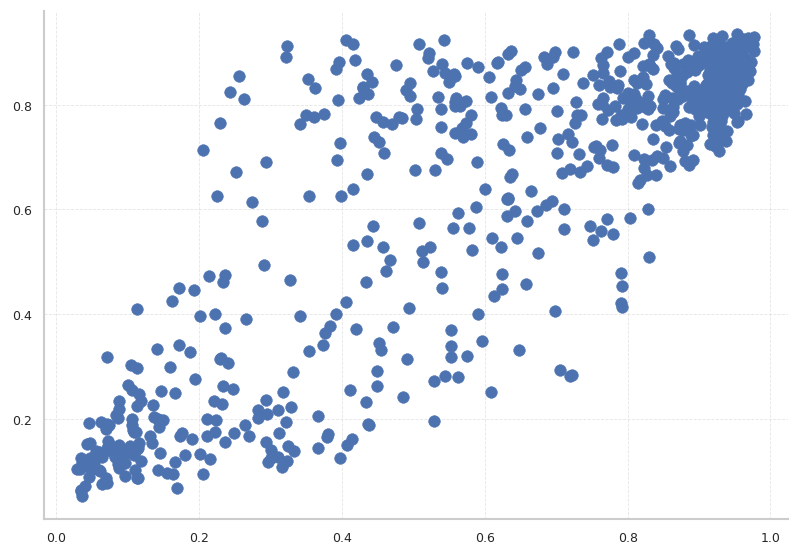

In [64]:
plt.scatter(nn_cnn_v0["rainfall"], nn_cat_v2["rainfall"])

In [65]:
df_subm_stack_ens = Config.submission.copy()
df_subm_stack_ens["rainfall"] = (nn_sub_v3["rainfall"].values + nn_lgbm_v2["rainfall"].values + nn_cnn_tab_v0["rainfall"].values)/3
df_subm_stack_ens.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_stack_all_ensemble_v5.csv")

#### **4.4.1 TabNetClassifier**

In [ ]:
%%capture
#!pip install optuna-integration-pytorch-tabnet
!pip install -qq pytorch_tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
tab_prob = {'eval_metric': "auc"}

In [ ]:
X_enc.sample(3)

In [ ]:
grouped_features = []
feature_cols = X_enc.columns.to_list()

group_1 = ['Wdsx',	'Wdsy']
#group_2 = ['loan_grade']
#group_3 = ['cb_person_default_on_file']

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [group_1]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

##### 4.2.2 Optuna Optimization:

In [ ]:
cate_feat = t.cat_features.copy()

for colset in [cate_feat]:
    cat_index_cols = [idx for idx, col in enumerate(feature_cols) if col in colset]

cat_index_cols

In [ ]:
def objective_tabnet(trial, X, y, n_splits, n_repeats, model=TabNetClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="StratKFold", metrics=tab_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'n_d': trial.suggest_categorical('n_d', [8,12,16]),
              'n_a': trial.suggest_categorical('n_d', [8,12,16]),
              'n_steps': trial.suggest_int('n_steps', 3, 5),
              'gamma': trial.suggest_float('gamma', 1.01, 2),
              'lambda_sparse':trial.suggest_float('lambda_sparse', 1e-5, 1e-1),
              "grouped_features":grouped_features,
#              'cat_idxs': cat_index_cols,
#              'cat_dims': [len(X_enc[col].unique()) for col in categorical_features],
              'n_independent': trial.suggest_int('n_independent', 2, 5),
              'n_shared': trial.suggest_int('n_shared', 2, 5),
              'mask_type': 'sparsemax', #trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
              'device_name': 'gpu' if use_gpu else 'cpu',
              'seed': rs,
              "optimizer_fn":torch.optim.Adam,
              "optimizer_params":dict(lr=0.01),
              "scheduler_params":{"patience":5, # how to use learning rate scheduler
                                "factor":0.5,
                                "min_lr":0.0001},
              "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train.values, y_train,
                  eval_set=[(X_valid.values, y_valid)],
                  batch_size=256,
                  eval_metric=['auc']  # Use 'auc' as the eval_metric
                  )

        y_pred = model.predict_proba(X_valid.values)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)


    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=False):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=TabNetClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params

* Trial 26 finished with value: 0.8768878597483415
* parameters: {'n_d': 16, 'n_steps': 4, 'gamma': 1.175711336460615, 'lambda_sparse': 0.03734291281338116, 'n_independent': 4, 'n_shared': 5}. Best is trial 26 with value: 0.8768878597483415.

#### 4.5.1 Yggdrasil - RandomForest

In [ ]:
#!pip install ydf -U

In [ ]:
y.head()

##### 4.5.2 Optuna Optimization:

[HyperParameters Link](https://ydf.readthedocs.io/en/stable/hyperparameters/#lambda_loss)

In [ ]:
# import ydf

# def objective_ydf_gbt(trial, X, y, n_splits, n_repeats, model_ = ydf.GradientBoostedTreesLearner, rs=42, fit_scaling=False, cv_strategy="KFold", use_gpu=False):

#     model_class = model_  # Use ydf's GradientBoostedTreesLearner

#     categorical_features = t.cat_features.copy()  # Assuming 't' is defined somewhere with categorical features

#     num_cols = [col for col in X.columns if col not in categorical_features]
#     auc_scores = []

#     params = {
#         'loss':"BINOMIAL_LOG_LIKELIHOOD",
#         'num_trees': trial.suggest_int('num_trees', 100, 1000),  # Number of trees in the forest
#         'max_depth': trial.suggest_int('max_depth', 3, 10),  # Maximum depth of the trees
#         'min_examples': trial.suggest_int('min_examples', 1, 10),  # Minimum number of samples required to split an internal node
#         'l1_regularization': trial.suggest_float('l1_regularization', 1e-5, 10.0, log=True),
#         'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 10.0, log=True),
# #         'shrinkage': trial.suggest_float('shrinkage', 0.01, 0.3, log=True),  # Similar to learning rate, but applied after each tree is trained
#          'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Fraction of samples used for training each tree
# # #        'max_categorical_cardinality': trial.suggest_int('max_categorical_cardinality', 10, 100),  # Maximum number of unique values for categorical features
# #         'categorical_algorithm': trial.suggest_categorical('categorical_algorithm', ['CART', 'RANDOM']),  # Algorithm used for categorical splits
# #         'split_axis': trial.suggest_categorical('split_axis', ['AXIS_ALIGNED', 'SPARSE_OBLIQUE']),  # How to split numerical features
# #         'sparse_oblique_normalization': trial.suggest_categorical('sparse_oblique_normalization', ['NONE', 'STANDARD_DEVIATION', 'MIN_MAX']),  # Normalization for sparse oblique splits
# #         'sparse_oblique_num_projections_exponent': trial.suggest_float('sparse_oblique_num_projections_exponent', 0.5, 1.0),  # Exponent for the number of projections in sparse oblique splits
#         'random_seed': rs,  # Random seed for reproducibility
#         'early_stopping':"LOSS_INCREASE",  # Enable early stopping
#         'early_stopping_num_trees_look_ahead': 30,  # Number of trees to look ahead for early stopping
# #        'weights': {0:1,1:sample_pos_weight},
#         "label" : "loan_status",
#         }


#     if cv_strategy == 'RepKFold':
#         kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
#     elif cv_strategy == 'KFold':
#         kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
#     elif cv_strategy == "StratKFold":
#         kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
#     elif cv_strategy == "RepStratKFold":
#         kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

#     for idx_train, idx_valid in kf.split(X, y):

#         # Split the data
#         X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#         X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#         if fit_scaling:
#             scaler = StandardScaler()
#             X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
#             X_valid[num_cols] = scaler.transform(X_valid[num_cols])

#         X_train["loan_status"] = y_train.values
#         X_valid["loan_status"] = y_valid.values

#         # Train the model with early stopping
#         model = model_class(task=ydf.Task.CLASSIFICATION, **params)
#         model.train(X_train, valid=(X_valid))  # Use ydf's fit method with early stopping

#         # Make predictions
#         y_pred = model.get_predictions(X_valid)["loan_status_probability_1"]

#         # Calculate AUC
#         auc_score = roc_auc_score(y_valid, y_pred)
#         auc_scores.append(auc_score)

#     # Calculate the mean AUC
#     key_metric = np.mean(auc_scores)

#     return key_metric

In [ ]:
# # Step 2: Tuning Hyperparameters with Optuna
# def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
#     study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
#     study.optimize(lambda trial: objective_ydf_gbt(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model_=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
#     return study  # Return the study object

# # Step 3: Saving Best Results and Models
# def save_results(study, model_class, model_name):
#     best_params_file = f"{model_name}_best_params.joblib"
#     joblib.dump(study.best_params, best_params_file)
#     print(f"Best parameters for {model_name} saved to {best_params_file}")

#     verbose_file = f"{model_name}_ydf_verbose.log"
#     with open(verbose_file, "w") as f:
#         f.write(str(study.trials))
#     print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
# cat_study = tune_hyperparameters(X_enc, y, model_class=ydf.GradientBoostedTreesLearner, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
# save_results(cat_study, TabNetClassifier, "ydf_ext")
# cat_params = cat_study.best_params

#### **4.6.1 NeuralNetwork**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
tab_prob = {'eval_metric': "auc"}

In [ ]:
X_enc.sample(3)

In [ ]:
grouped_features = []
feature_cols = X_enc.columns.to_list()

group_1 = ['person_home_ownership', 'loan_intent']
#group_2 = ['loan_grade']
#group_3 = ['cb_person_default_on_file']

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [group_1]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

##### 4.2.2 Optuna Optimization:

In [ ]:
cate_feat = t.cat_features.copy()

for colset in [cate_feat]:
    cat_index_cols = [idx for idx, col in enumerate(feature_cols) if col in colset]

cat_index_cols

In [ ]:
def objective_tabnet(trial, X, y, n_splits, n_repeats, model=TabNetClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=tab_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'n_d': trial.suggest_categorical('n_d', [8,12,16]),
              'n_a': trial.suggest_categorical('n_d', [8,12,16]),
              'n_steps': trial.suggest_int('n_steps', 3, 5),
              'gamma': trial.suggest_float('gamma', 1.01, 2),
              'lambda_sparse':trial.suggest_float('lambda_sparse', 1e-5, 1e-1),
              "grouped_features":grouped_features,
              'cat_idxs': cat_index_cols,
              'cat_dims': [len(X_enc[col].unique()) for col in categorical_features],
              'n_independent': trial.suggest_int('n_independent', 2, 5),
              'n_shared': trial.suggest_int('n_shared', 2, 5),
              'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
              'device_name': 'gpu' if use_gpu else 'cpu',
              'seed': rs,
              "optimizer_fn":torch.optim.Adam,
              "optimizer_params":dict(lr=0.01),
              "scheduler_params":{"patience":5, # how to use learning rate scheduler
                                "factor":0.5,
                                "min_lr":0.0001},
              "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train.values, y_train,
                  eval_set=[(X_valid.values, y_valid)],
                  batch_size=256,
                  eval_metric=[tab_prob["eval_metric"]])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=TabNetClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params